# **CUSTOMER VALUE & RETENTION ANALYSIS FOR A UK ONLINE RETAILER**

# **Background and Overview**
This project analyses two years of transaction-level data from a UK-based online retailer (gifts & home decoration). The goal is to surface business-critical findings and propose targeted, measurable actions to improve retention, increase customer lifetime value, and reduce revenue risk.

Dataset scope: two-year transaction history (item-level: invoice, SKU, qty, unit price, customer identifier, timestamp, country).

# **PART I: DATA PREPARATION**

# 1. Data Loading

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from datetime import timedelta
import sqlite3 as sql
import warnings
warnings.filterwarnings("ignore")
import regex as re

sns.set(style="whitegrid")

In [2]:
from google.colab import files
uploaded = files.upload()

Saving ONLINE_RETAIL.xlsx to ONLINE_RETAIL.xlsx


In [3]:
# Load Dataset
df = pd.read_excel('ONLINE_RETAIL.xlsx')

In [4]:
df_raw = df.copy()

# 2. Data Overview

In [5]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1044843,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1044844,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1044845,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1044846,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044848 entries, 0 to 1044847
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   InvoiceNo    1044848 non-null  object        
 1   StockCode    1044848 non-null  object        
 2   Description  1040573 non-null  object        
 3   Quantity     1044848 non-null  int64         
 4   InvoiceDate  1044848 non-null  datetime64[ns]
 5   UnitPrice    1044848 non-null  float64       
 6   CustomerID   809561 non-null   float64       
 7   Country      1044848 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 63.8+ MB


**Finding:**
Only the `Description` column contains missing values, which can be resolved by referencing the corresponding `StockCode` entries. Missing values in `CustomerID` will be retained because they are required for subsequent analysis. Therefore, no records will be removed due to null values in this dataset.

In [7]:
df.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,1044848.0,1044848,1040573,1.044848e+06,1044848,1.044848e+06,809561.000000,1044848
unique,53628.0,5305,5698,NaN,NaN,NaN,NaN,43
top,573585.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,NaN,United Kingdom
freq,1114.0,5711,5798,NaN,NaN,NaN,NaN,959983
mean,NaN,NaN,NaN,9.993649e+00,2011-01-03 11:44:15.916841728,4.590546e+00,15319.760422,NaN
min,NaN,NaN,NaN,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000e+00,2010-07-05 11:11:00,1.250000e+00,13969.000000,NaN
50%,NaN,NaN,NaN,3.000000e+00,2010-12-08 16:34:00,2.100000e+00,15248.000000,NaN
75%,NaN,NaN,NaN,1.000000e+01,2011-07-27 13:42:00,4.130000e+00,16792.000000,NaN
max,NaN,NaN,NaN,8.099500e+04,2011-12-09 12:50:00,3.897000e+04,18287.000000,NaN


**Finding:**
1. The count of unique values in `StockCode` does not match the count in Description, suggesting inconsistencies between product codes and their descriptions.

2. The `UnitPrice` and `Quantity` columns contain negative values.

3. Both `InvoiceNo` and `StockCode` include purely numeric entries as well as alphanumeric ones.

4. The minimum and maximum values in `Quantity` look unusual, as they mirror each other with opposite signs.

5. Several products appear with multiple unit prices despite no additional attributes that would justify price variation.

Some of these findings require deeper investigation.

In [8]:
df.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
UnitPrice,float64
CustomerID,float64
Country,object


| Columns     | Data Type      | Comments                                 |
| ----------- | -------------- | ----------------------------------------- |
| InvoiceNo   | object         | Already correct; keep as string           |
| StockCode   | object         | Already correct; keep as string           |
| Description | object         | Already correct; keep as string           |
| Quantity    | int64          | Already correct                           |
| InvoiceDate | datetime64[ns] | Already correct                           |
| UnitPrice   | float64        | Already correct                           |
| CustomerID  | float64        | Should be converted to object/string      |
| Country     | object         | Better represented as a categorical field |

In [9]:
# Create additional analytical features
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Standardize string-based fields
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
df['StockCode'] = df['StockCode'].astype(str)
df['Description'] = df['Description'].astype(str)
df['CustomerID'].fillna(0, inplace=True)
df['CustomerID'] = df['CustomerID'].astype(int)

df['InvoiceNo'] = df['InvoiceNo'].str.upper()
df['StockCode'] = df['StockCode'].str.upper()
df['Description'] = df['Description'].str.upper()

display(df['Country'].unique()) # Verify country names are consistent and typo-free

array(['United Kingdom', 'France', 'USA', 'Belgium', 'Australia', 'EIRE',
       'Germany', 'Portugal', 'Japan', 'Denmark', 'Nigeria',
       'Netherlands', 'Poland', 'Spain', 'Channel Islands', 'Italy',
       'Cyprus', 'Greece', 'Norway', 'Austria', 'Sweden',
       'United Arab Emirates', 'Finland', 'Switzerland', 'Unspecified',
       'Malta', 'Bahrain', 'RSA', 'Bermuda', 'Hong Kong', 'Singapore',
       'Thailand', 'Israel', 'Lithuania', 'West Indies', 'Lebanon',
       'Korea', 'Brazil', 'Canada', 'Iceland', 'Saudi Arabia',
       'Czech Republic', 'European Community'], dtype=object)

In [10]:
df['CustomerID'] = df['CustomerID'].astype(str)
df['Country'] = df['Country'].astype('category')

In [11]:
# Check missing values

df.isnull().sum().sort_values(ascending=False)

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0
YearMonth,0
TotalPrice,0


In [12]:
# Saving raw copy
df_raw = df.copy()

# 3. Initial Validation

In [13]:
# Check whether each InvoiceNo corresponds to a single CustomerID
incorrect_invoiceno = df.groupby('InvoiceNo')['CustomerID'].nunique().sort_values(ascending=False)
incorrect_invoiceno[incorrect_invoiceno > 1].shape[0]

0

In [14]:
# Check duplicates

df.duplicated().sum()

np.int64(11812)

In [15]:
# Investigate odd columns
odd_columns = ['InvoiceNo', 'StockCode']
for col in odd_columns:
  print(f'{col} with not only numbers: ',df[df[col].str.contains(r'^(?!\d+$).+', na=False)].shape[0])
  print(f'{col} with only numbers: ',df[df[col].str.contains(r'\d', na=False)].shape[0])
  print(f'{col} without numbers: ',df[~df[col].str.contains(r'\d', na=False)].shape[0])
  print(f'{col} with strange character: ',df[df[col].str.contains('[^a-zA-Z0-9]', na=False)].shape[0], '\n')

InvoiceNo with not only numbers:  19171
InvoiceNo with only numbers:  1044848
InvoiceNo without numbers:  0
InvoiceNo with strange character:  0 

StockCode with not only numbers:  132237
StockCode with only numbers:  1039364
StockCode without numbers:  5484
StockCode with strange character:  201 



In [16]:
# Investigate 'InvoiceNo' column
invoice_with_letter = df[df['InvoiceNo'].str.contains(r'[a-zA-Z]', na=False)]
display(invoice_with_letter)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearMonth,TotalPrice
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321,Australia,2009-12,-35.40
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321,Australia,2009-12,-9.90
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321,Australia,2009-12,-17.00
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321,Australia,2009-12,-12.60
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321,Australia,2009-12,-35.40
...,...,...,...,...,...,...,...,...,...,...
1043387,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom,2011-12,-9.13
1044479,C581499,M,MANUAL,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom,2011-12,-224.69
1044653,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom,2011-12,-54.75
1044654,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom,2011-12,-1.25


In [17]:
invoice_with_letter[invoice_with_letter['Quantity'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearMonth,TotalPrice
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321,Australia,2009-12,-35.40
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321,Australia,2009-12,-9.90
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321,Australia,2009-12,-17.00
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321,Australia,2009-12,-12.60
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321,Australia,2009-12,-35.40
...,...,...,...,...,...,...,...,...,...,...
1043387,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom,2011-12,-9.13
1044479,C581499,M,MANUAL,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom,2011-12,-224.69
1044653,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom,2011-12,-54.75
1044654,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom,2011-12,-1.25


In [18]:
invoice_with_letter[invoice_with_letter['Quantity'] > 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearMonth,TotalPrice
76799,C496350,M,MANUAL,1,2010-02-01 08:24:00,373.57,0,United Kingdom,2010-02,373.57
179403,A506401,B,ADJUST BAD DEBT,1,2010-04-29 13:36:00,-53594.36,0,United Kingdom,2010-04,-53594.36
276274,A516228,B,ADJUST BAD DEBT,1,2010-07-19 11:24:00,-44031.79,0,United Kingdom,2010-07,-44031.79
403472,A528059,B,ADJUST BAD DEBT,1,2010-10-20 12:04:00,-38925.87,0,United Kingdom,2010-10,-38925.87
802920,A563185,B,ADJUST BAD DEBT,1,2011-08-12 14:50:00,11062.06,0,United Kingdom,2011-08,11062.06
802921,A563186,B,ADJUST BAD DEBT,1,2011-08-12 14:51:00,-11062.06,0,United Kingdom,2011-08,-11062.06
802922,A563187,B,ADJUST BAD DEBT,1,2011-08-12 14:52:00,-11062.06,0,United Kingdom,2011-08,-11062.06


**Findings**:
1. Invoice numbers containing letters are consistently linked to one of the following: negative Quantity, negative UnitPrice, or a StockCode that is not numeric.
2. Invoice numbers beginning with **C** appear to correspond to cancellation or return transactions, which need to be separated for additional investigation.
3. Invoice numbers starting with **A** represent unclear adjustment entries and will be removed from the dataset.

Addition: Invoices beginning with the letter **C** most likely represent return transactions or cancellations resulting from data entry mistakes, system errors, or other issues that indicate the purchase never actually occurred. These will be classified as **Canceled Transactions**.

In [19]:
# Make seperated data of Cancellation/Return transactions for further analysis
cancellation_df = df[df['InvoiceNo'].str.startswith('C')]

In [20]:
# Investigate 'StockCode' column
stock_not_only_number = df[df['StockCode'].str.contains(r'^(?!\d+$).+', na=False)]
stock_without_number = df[~df['StockCode'].str.contains(r'\d', na=False)]
stock_with_strange_char = df[df['StockCode'].str.contains('[^a-zA-Z0-9]', na=False)]
stock_with_letter_and_number = stock_not_only_number[(~stock_not_only_number['StockCode'].isin(stock_with_strange_char['StockCode'])) &
                              (~stock_not_only_number['StockCode'].isin(stock_without_number['StockCode']))]
stock_starts_with_letter = stock_with_letter_and_number[stock_with_letter_and_number['StockCode'].str.contains(r'^[A-Za-z]')]
stock_starts_with_number = stock_with_letter_and_number[stock_with_letter_and_number['StockCode'].str.contains(r'^[\d]')]
stock_with_only_number = df[df['StockCode'].str.contains(r'^\d+$')]

In [21]:
stock_with_only_number.groupby('StockCode')['Description'].unique()

,Description
StockCode,
10002,"[INFLATABLE POLITICAL GLOBE , NAN]"
10080,"[GROOVY CACTUS INFLATABLE, NAN, CHECK]"
10109,"[BENDY COLOUR PENCILS, NAN]"
10120,"[DOGGY RUBBER, ZEBRA INVCING ERROR]"
10125,[MINI FUNKY DESIGN TAPES]
...,...
90192,"[JADE DROP EARRINGS W FILIGREE, NAN]"
90194,"[SILVER LARIAT BLACK STONE EARRINGS, NAN]"
90203,"[SILVER CHARM NECKLACE 70CM, NAN]"


**Finding:**
It appears that numeric StockCode values represent standard product identifiers in this Online Store.

In [22]:
# Investigate 'StockCode' column
stock_not_only_number = df[df['StockCode'].str.contains(r'^(?=.*[0-9])(?!^[0-9]*$).*$', na=False)]
stock_without_number = df[~df['StockCode'].str.contains(r'\d', na=False)]
stock_with_strange_char = df[df['StockCode'].str.contains('[^a-zA-Z0-9]', na=False)]
stock_starts_with_letter = stock_not_only_number[stock_not_only_number['StockCode'].str.contains(r'^[A-Za-z]')]
stock_starts_with_number = stock_not_only_number[stock_not_only_number['StockCode'].str.contains(r'^[\d]')]
stock_starts_with_strange_char = stock_not_only_number[(~stock_not_only_number['StockCode'].isin(stock_starts_with_number['StockCode'])) &
                                 (~stock_not_only_number['StockCode'].isin(stock_starts_with_letter['StockCode']))]
stock_with_number = df[df['StockCode'].str.contains(r'[\d]', na=False)]

In [23]:
stock_starts_with_letter.groupby('StockCode')['Description'].unique()

,Description
StockCode,
ADJUST2,[ADJUSTMENT BY PETER ON JUN 25 2010 ]
C2,"[CARRIAGE, NAN]"
C3,[NAN]
DCGS0003,"[BOXED GLASS ASHTRAY, EBAY]"
DCGS0004,"[HAYNES CAMPER SHOULDER BAG, NAN]"
DCGS0006,[NAN]
DCGS0016,[NAN]
DCGS0027,[NAN]
DCGS0036,[NAN]


| StockCode | Comments                        |
| --------- | ------------------------------- |
| ADJUST2   | Adjustment entry                |
| C2 & C3   | Carriage charges                |
| SP1002    | Children's chalkboard (product) |
| TEST...   | Test product                    |

In [24]:
stock_starts_with_letter = stock_starts_with_letter[(~stock_starts_with_letter['StockCode'].str.startswith('DCGS')) &
                                                    (stock_starts_with_letter['StockCode'] != 'SP1002')]

In [25]:
stock_starts_with_number.groupby('StockCode')['Description'].unique().tail(20)

,Description
StockCode,
90214E,"[LETTER ""E"" BLING KEY RING]"
90214F,"[LETTER ""F"" BLING KEY RING]"
90214G,"[LETTER ""G"" BLING KEY RING]"
90214H,"[LETTER ""H"" BLING KEY RING]"
90214I,"[LETTER ""I"" BLING KEY RING]"
90214J,"[LETTER ""J"" BLING KEY RING]"
90214K,"[LETTER ""K"" BLING KEY RING]"
90214L,"[LETTER ""L"" BLING KEY RING]"
90214M,"[LETTER ""M"" BLING KEY RING]"


**Comments**:
Valid Product

In [26]:
stock_starts_with_strange_char.groupby('StockCode')['Description'].unique().tail(20)

,Description
StockCode,


In [27]:
stock_without_number.groupby('StockCode')['Description'].unique()

,Description
StockCode,
ADJUST,"[ADJUSTMENT BY JOHN ON 26/01/2010 16, ADJUSTME..."
AMAZONFEE,[AMAZON FEE]
B,[ADJUST BAD DEBT]
BANK CHARGES,"[ BANK CHARGES, BANK CHARGES]"
CRUK,[CRUK COMMISSION]
D,[DISCOUNT]
DCGSLBOY,[NAN]
DCGSLGIRL,[NAN]
DCGSSBOY,"[NAN, UPDATE, BOYS PARTY BAG]"


**Comments:**

| StockCode    | Comments                                                                       |
| ------------ | ------------------------------------------------------------------------------ |
| ADJUST       | Additional adjustment entry — do not delete; prepare a separate matching table |
| AMAZONFEE    | Amazon platform fee                                                            |
| B            | Bad debt adjustment                                                            |
| BANK CHARGES | Bank-related fees                                                              |
| CRUK         | Donation to Cancer Research UK                                                 |
| D            | Discount                                                                       |
| DCGS..       | Party bag (product)                                                            |
| DOT          | Postage fee                                                                    |
| GIFT         | One-off transaction; likely a complimentary item for a customer                |
| M            | Manually entered transaction; unclear details, excluded for now                |
| PADS         | As labeled; customer charged nothing                                           |
| POST         | Additional postage                                                             |
| S            | Product sample                                                                 |

In [28]:
df_adjustment = df[(df['StockCode'].str.startswith('ADJUST')) | (df['StockCode'] == 'M')]
df_discount = df[df['StockCode'] == ('D')]
stock_without_number = stock_without_number[(~stock_without_number['StockCode'].str.startswith('DCGS')) &
                                            (stock_without_number['StockCode'] != 'D')]

In [29]:
stock_with_strange_char.groupby('StockCode')['Description'].unique()

,Description
StockCode,
47503J,[SET/3 FLORAL GARDEN TOOLS IN BAG]
BANK CHARGES,"[ BANK CHARGES, BANK CHARGES]"
GIFT_0001_10,"[DOTCOMGIFTSHOP GIFT VOUCHER £10.00, NAN]"
GIFT_0001_20,"[DOTCOMGIFTSHOP GIFT VOUCHER £20.00, NAN, TO P..."
GIFT_0001_30,"[DOTCOMGIFTSHOP GIFT VOUCHER £30.00, NAN]"
GIFT_0001_40,"[NAN, DOTCOMGIFTSHOP GIFT VOUCHER £40.00]"
GIFT_0001_50,"[DOTCOMGIFTSHOP GIFT VOUCHER £50.00, NAN]"
GIFT_0001_60,[NAN]
GIFT_0001_70,"[NAN, DOTCOMGIFTSHOP GIFT VOUCHER £70.00]"


**Comments:**

| StockCode | Comments           |
| --------- | ------------------ |
| GIFT_...  | Gift voucher sales |
| BANK CHARGES  | Bank charges |
| 47503J  | Typo on valid products |

In [30]:
# Fix the typo on valid StockCode

df.loc[260886, 'StockCode'] = '47503J'

**Findings:**
Some StockCodes correspond to non-merchandise entries—such as bags, shipping charges, fees, or adjustments—that do not represent real customer purchases and could distort revenue-related metrics if included.

In [31]:
print(invoice_with_letter[invoice_with_letter['InvoiceNo'].str.contains('C', na=False)].shape[0])
print(invoice_with_letter[~invoice_with_letter['InvoiceNo'].str.contains('C', na=False)].shape[0])

19165
6


In [32]:
deleted_stockcode = df[(df['StockCode'].isin(stock_without_number['StockCode'])) |
                      (df['StockCode'].isin(stock_with_strange_char['StockCode'])) |
                      (df['StockCode'].isin(stock_starts_with_letter['StockCode'])) |
                      (df['InvoiceNo'].str.startswith('A'))
                      ]

# 4. Data Cleaning and Transformation

In [33]:
df.shape[0]

1044848

In [34]:
# Delete Duplicates
df.drop_duplicates(inplace=True)

In [35]:
df.shape[0]

1033036

In [36]:
df[df['InvoiceNo'].str.startswith('C')].shape[0]

19104

In [37]:
# Handling Canceled Transactions
# Note: Each cancellation must match an original transaction
# Note: Treat Canceled Transactions as those reversed on the same date as their original entries

# Create invoice-date-only column and an absolute value column for matching
df['AbsTotalPrice'] = df['TotalPrice'].abs()
df['InvoiceDateOnly'] = df['InvoiceDate'].dt.date

# Self-merge to identify matching positive and negative transactions
pairs = df.merge(
    df,
    on=['CustomerID', 'Country', 'InvoiceDateOnly', 'AbsTotalPrice'],  # matching keys
    suffixes=('_pos', '_neg')
)

# Keep only pairs with opposite TotalPrice and correct chronological order
cancel_pairs = pairs[
    (pairs['TotalPrice_pos'] == -pairs['TotalPrice_neg']) &
    (pairs['InvoiceDate_pos'] < pairs['InvoiceDate_neg'])  # cancellations occur after the original transaction
]

# Retain only records with positive values
cancel_pairs = cancel_pairs[cancel_pairs['AbsTotalPrice'] > 0]

display(cancel_pairs[['StockCode_pos', 'InvoiceNo_pos', 'StockCode_pos', 'InvoiceNo_neg',
                      'CustomerID', 'StockCode_neg', 'Quantity_pos', 'Quantity_neg']])

,StockCode_pos,InvoiceNo_pos,StockCode_pos,InvoiceNo_neg,CustomerID,StockCode_neg,Quantity_pos,Quantity_neg
341,22087,C489449,22087,489450,16321,22087,-12,12
342,22087,C489449,22087,489450,16321,22083,-12,12
343,22087,C489449,22087,489450,16321,22090,-12,12
345,85206A,C489449,85206A,489450,16321,85206A,-6,6
347,21895,C489449,21895,489450,16321,21895,-4,4
...,...,...,...,...,...,...,...,...
8104262,23494,581166,23494,C581178,15525,23494,1,-1
8104362,23079,581166,23079,C581178,15525,23079,1,-1
8197083,16169E,581325,16169E,C581330,15877,16169E,100,-100
8197085,22959,581325,22959,C581330,15877,22959,25,-25


In [38]:
cancel_pairs = cancel_pairs[(cancel_pairs['StockCode_pos'] == cancel_pairs['StockCode_neg']) # There are some cancelation transactions with 'M' StockCode.
              | (cancel_pairs['StockCode_neg'].isin(df_adjustment['StockCode']))]
cancel_pairs = cancel_pairs[(~cancel_pairs['InvoiceNo_pos'].str.startswith("C")) # We need to ensure that these are pairs between canceled transactions and cancellation transactions
              & (cancel_pairs['InvoiceNo_neg'].str.startswith("C"))]
cancel_pairs = cancel_pairs[(~cancel_pairs['StockCode_pos'].isin(deleted_stockcode['StockCode']))]
cancel_pairs.shape[0]

1335

In [39]:
# Create a unique identifier for each transaction in cancel_pairs
cancel_pairs['PosID'] = cancel_pairs.apply(lambda row: f"{row['InvoiceNo_pos']}_{row['StockCode_pos']}_{row['Description_pos']}_{row['Quantity_pos']}_{row['InvoiceDate_pos']}_{row['UnitPrice_pos']}_{row['CustomerID']}_{row['Country']}_{row['TotalPrice_pos']}",axis=1)
cancel_pairs['NegID'] = cancel_pairs.apply(lambda row: f"{row['InvoiceNo_neg']}_{row['StockCode_neg']}_{row['Description_neg']}_{row['Quantity_neg']}_{row['InvoiceDate_neg']}_{row['UnitPrice_neg']}_{row['CustomerID']}_{row['Country']}_{row['TotalPrice_neg']}",axis=1)


In [40]:
## Finding transactions that were canceled but later re-purchased
unique_pos_pairs = cancel_pairs.groupby('PosID')['NegID'].nunique()
unique_neg_pairs = cancel_pairs.groupby('NegID')['PosID'].nunique()

non_unique_PosID = unique_pos_pairs[unique_pos_pairs == 2].index
non_unique_NegID = unique_neg_pairs[unique_neg_pairs == 2].index

double_neg = cancel_pairs['NegID'].value_counts()[cancel_pairs['NegID'].value_counts() == 2].index
double_pos = cancel_pairs['PosID'].value_counts()[cancel_pairs['PosID'].value_counts() == 2].index

double_pairs = cancel_pairs[(cancel_pairs['NegID'].isin(non_unique_NegID)) &
                            (cancel_pairs['PosID'].isin(non_unique_PosID))]

non_unique_pairs = cancel_pairs[(cancel_pairs['NegID'].isin(non_unique_NegID)) |
                                (cancel_pairs['PosID'].isin(non_unique_PosID))]

non_unique_repurchased = non_unique_pairs[(~cancel_pairs['NegID'].isin(double_pairs['NegID'])) |
                                          (~cancel_pairs['PosID'].isin(double_pairs['PosID']))]

repurchased_transaction = non_unique_repurchased.groupby('NegID')['InvoiceDate_pos'].idxmax()

# Drop these rows from the repurchased_transaction DataFrame
delete_pairs = cancel_pairs.drop(repurchased_transaction)
delete_pairs.shape[0]

1255

In [41]:
df.shape[0]

1033036

In [42]:
# Create a unique identifier for each transaction in df
df['TransactionID'] = df.apply(lambda row: f"{row['InvoiceNo']}_{row['StockCode']}_{row['Description']}_{row['Quantity']}_{row['InvoiceDate']}_{row['UnitPrice']}_{row['CustomerID']}_{row['Country']}_{row['TotalPrice']}", axis=1)

# Filter out the rows from df that are in cancel_transaction_ids
df = df[~df['TransactionID'].isin(delete_pairs['PosID'])]
df = df[~df['TransactionID'].isin(delete_pairs['NegID'])]

# Drop the temporary TransactionID column
df = df.drop(columns=['TransactionID'])

In [43]:
df.shape[0]

1030578

In [44]:
df = df.drop(columns=['InvoiceDateOnly','AbsTotalPrice'])

In [45]:
# Delete every non-product 'StockCode'
df = df[~df['StockCode'].isin(deleted_stockcode['StockCode'])]

In [46]:
df.shape[0]

1024937

In [47]:
df = df[df['UnitPrice'] != 0]

In [48]:
df.loc[df['StockCode'] == 'D', 'Quantity'] = 0

df[df['StockCode'] == 'D'].sort_values('Quantity')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearMonth,TotalPrice
735,C489535,D,DISCOUNT,0,2009-12-01 12:11:00,9.00,15299,United Kingdom,2009-12,-9.00
736,C489535,D,DISCOUNT,0,2009-12-01 12:11:00,19.00,15299,United Kingdom,2009-12,-19.00
24675,C491428,D,DISCOUNT,0,2009-12-10 20:23:00,9.10,15494,United Kingdom,2009-12,-9.10
29414,C491845,D,DISCOUNT,0,2009-12-14 14:54:00,1.59,0,United Kingdom,2009-12,-1.59
29958,C491962,D,DISCOUNT,0,2009-12-14 16:38:00,0.59,13206,United Kingdom,2009-12,-0.59
...,...,...,...,...,...,...,...,...,...,...
982806,C577227,D,DISCOUNT,0,2011-11-18 12:06:00,19.82,14527,United Kingdom,2011-11,-19.82
982807,C577227,D,DISCOUNT,0,2011-11-18 12:06:00,16.76,14527,United Kingdom,2011-11,-16.76
996551,C578239,D,DISCOUNT,0,2011-11-23 12:29:00,26.33,14912,Italy,2011-11,-26.33
1019159,C579884,D,DISCOUNT,0,2011-11-30 17:34:00,20.53,14527,United Kingdom,2011-11,-20.53


# 5. Validation After Cleaning

In [49]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearMonth,TotalPrice
count,1018975,1018975,1018975,1018975.00,1018975,1018975.00,1018975,1018975,1018975,1018975.00
unique,46673,4735,5388,NaN,NaN,NaN,5875,43,25,NaN
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,0,United Kingdom,2011-11,NaN
freq,1112,5736,5727,NaN,NaN,NaN,226955,937100,82610,NaN
mean,NaN,NaN,NaN,10.52,2011-01-04 03:07:52.600446720,3.37,NaN,NaN,NaN,18.52
min,NaN,NaN,NaN,-9360.00,2009-12-01 07:45:00,0.01,NaN,NaN,NaN,-6539.40
25%,NaN,NaN,NaN,1.00,2010-07-05 16:48:00,1.25,NaN,NaN,NaN,3.75
50%,NaN,NaN,NaN,3.00,2010-12-09 14:09:00,2.10,NaN,NaN,NaN,9.95
75%,NaN,NaN,NaN,10.00,2011-07-28 10:14:00,4.13,NaN,NaN,NaN,17.70
max,NaN,NaN,NaN,19152.00,2011-12-09 12:50:00,1867.86,NaN,NaN,NaN,15818.40


In [50]:
df.sort_values('UnitPrice', ascending=False).head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearMonth,TotalPrice
653529,C549452,D,DISCOUNT,0,2011-04-08 14:17:00,1867.86,17940,United Kingdom,2011-04,-1867.86
450818,C532255,D,DISCOUNT,0,2010-11-11 12:50:00,1269.51,14088,United Kingdom,2010-11,-1269.51
192196,507637,84016,FLAG OF ST GEORGE CAR FLAG,1,2010-05-10 14:55:00,1157.15,0,United Kingdom,2010-05,1157.15
95554,C498420,D,DISCOUNT,0,2010-02-18 16:25:00,947.08,14646,Netherlands,2010-02,-947.08
136403,502451,84016,FLAG OF ST GEORGE CAR FLAG,1,2010-03-24 14:14:00,867.79,0,United Kingdom,2010-03,867.79
725620,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.50,15098,United Kingdom,2011-06,649.50
399358,C527516,D,DISCOUNT,0,2010-10-18 13:03:00,619.92,18102,United Kingdom,2010-10,-619.92
318602,C520413,D,DISCOUNT,0,2010-08-26 09:38:00,591.43,15498,United Kingdom,2010-08,-591.43
803889,C563225,D,DISCOUNT,0,2011-08-14 14:35:00,434.51,14911,EIRE,2011-08,-434.51
365920,C524867,D,DISCOUNT,0,2010-10-01 09:33:00,413.40,14912,Italy,2010-10,-413.40


In [51]:
df[df['StockCode'] == '84016'].sort_values('UnitPrice', ascending=False).head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearMonth,TotalPrice
192196,507637,84016,FLAG OF ST GEORGE CAR FLAG,1,2010-05-10 14:55:00,1157.15,0,United Kingdom,2010-05,1157.15
136403,502451,84016,FLAG OF ST GEORGE CAR FLAG,1,2010-03-24 14:14:00,867.79,0,United Kingdom,2010-03,867.79
180997,506571,84016,FLAG OF ST GEORGE CAR FLAG,1,2010-04-30 13:04:00,408.40,0,United Kingdom,2010-04,408.40
114155,500315,84016,FLAG OF ST GEORGE CAR FLAG,1,2010-03-07 11:56:00,280.75,0,United Kingdom,2010-03,280.75
248762,513439,84016,FLAG OF ST GEORGE CAR FLAG,1,2010-06-24 14:17:00,272.27,0,United Kingdom,2010-06,272.27
117876,500586,84016,FLAG OF ST GEORGE CAR FLAG,2,2010-03-09 10:02:00,93.61,0,United Kingdom,2010-03,187.22
136494,502469,84016,FLAG OF ST GEORGE CAR FLAG,1,2010-03-24 15:39:00,93.61,0,United Kingdom,2010-03,93.61
200664,508649,84016,FLAG OF ST GEORGE CAR FLAG,2,2010-05-17 15:45:00,25.53,0,United Kingdom,2010-05,51.06
181647,506647,84016,FLAG OF ST GEORGE CAR FLAG,1,2010-04-30 16:21:00,25.53,0,United Kingdom,2010-04,25.53
179302,506393,84016,FLAG OF ST GEORGE CAR FLAG,1,2010-04-29 13:10:00,25.53,0,United Kingdom,2010-04,25.53


**Finding:**
I cannot determine whether the unusually high `UnitPrice` values associated with the product code **84016** are real or the result of data-entry issues. Since these records also lack identifiable customer information, they will be removed from the dataset.

In [52]:
deleted = df[(df['StockCode'] == '84016') & (df['UnitPrice'] > 25)].index
df.drop(deleted, inplace=True)

In [53]:
# Ensure there are no more null values in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1018963 entries, 0 to 1044846
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   InvoiceNo    1018963 non-null  object        
 1   StockCode    1018963 non-null  object        
 2   Description  1018963 non-null  object        
 3   Quantity     1018963 non-null  int64         
 4   InvoiceDate  1018963 non-null  datetime64[ns]
 5   UnitPrice    1018963 non-null  float64       
 6   CustomerID   1018963 non-null  object        
 7   Country      1018963 non-null  category      
 8   YearMonth    1018963 non-null  period[M]     
 9   TotalPrice   1018963 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(2), int64(1), object(4), period[M](1)
memory usage: 78.7+ MB


In [54]:
df.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearMonth,TotalPrice
count,1018963,1018963,1018963,1018963.00,1018963,1018963.00,1018963,1018963,1018963,1018963.00
unique,46661,4735,5388,NaN,NaN,NaN,5875,43,25,NaN
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,0,United Kingdom,2011-11,NaN
freq,1112,5736,5727,NaN,NaN,NaN,226943,937088,82610,NaN
mean,NaN,NaN,NaN,10.52,2011-01-04 03:12:16.277195520,3.37,NaN,NaN,NaN,18.52
min,NaN,NaN,NaN,-9360.00,2009-12-01 07:45:00,0.01,NaN,NaN,NaN,-6539.40
25%,NaN,NaN,NaN,1.00,2010-07-05 16:48:00,1.25,NaN,NaN,NaN,3.75
50%,NaN,NaN,NaN,3.00,2010-12-09 14:09:00,2.10,NaN,NaN,NaN,9.95
75%,NaN,NaN,NaN,10.00,2011-07-28 10:14:00,4.13,NaN,NaN,NaN,17.70
max,NaN,NaN,NaN,19152.00,2011-12-09 12:50:00,1867.86,NaN,NaN,NaN,15818.40


**Finding:**
The maximum values in `UnitPrice`, `Quantity`, and `TotalPrice` appear unusually high, so these transactions will be examined further.

In [55]:
df.sort_values('Quantity', ascending=False).head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearMonth,TotalPrice
90857,497946,37410,BLACK AND WHITE PAISLEY FLOWER MUG,19152,2010-02-15 11:57:00,0.10,13902,Denmark,2010-02,1915.20
127166,501534,21099,SET/6 STRAWBERRY PAPER CUPS,12960,2010-03-17 13:09:00,0.10,13902,Denmark,2010-03,1296.00
127168,501534,21091,SET/6 WOODLAND PAPER PLATES,12960,2010-03-17 13:09:00,0.10,13902,Denmark,2010-03,1296.00
127169,501534,21085,SET/6 WOODLAND PAPER CUPS,12744,2010-03-17 13:09:00,0.10,13902,Denmark,2010-03,1274.40
127167,501534,21092,SET/6 STRAWBERRY PAPER PLATES,12480,2010-03-17 13:09:00,0.10,13902,Denmark,2010-03,1248.00
135030,502269,21981,PACK OF 12 WOODLAND TISSUES,10000,2010-03-23 15:36:00,0.25,17940,United Kingdom,2010-03,2500.00
135029,502269,21980,PACK OF 12 RED SPOTTY TISSUES,10000,2010-03-23 15:36:00,0.25,17940,United Kingdom,2010-03,2500.00
135028,502269,21982,PACK OF 12 SUKI TISSUES,10000,2010-03-23 15:36:00,0.25,17940,United Kingdom,2010-03,2500.00
135027,502269,21984,PACK OF 12 PINK PAISLEY TISSUES,10000,2010-03-23 15:36:00,0.25,17940,United Kingdom,2010-03,2500.00
93677,498152,85220,SMALL FAIRY CAKE FRIDGE MAGNETS,9456,2010-02-17 10:51:00,0.30,13902,Denmark,2010-02,2836.80


**Finding:**
It appears that large `Quantity` values are typical for this store, so no specific action will be taken for those transactions.

In [56]:
df.sort_values('UnitPrice', ascending=False).head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearMonth,TotalPrice
653529,C549452,D,DISCOUNT,0,2011-04-08 14:17:00,1867.86,17940,United Kingdom,2011-04,-1867.86
450818,C532255,D,DISCOUNT,0,2010-11-11 12:50:00,1269.51,14088,United Kingdom,2010-11,-1269.51
95554,C498420,D,DISCOUNT,0,2010-02-18 16:25:00,947.08,14646,Netherlands,2010-02,-947.08
725620,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.50,15098,United Kingdom,2011-06,649.50
399358,C527516,D,DISCOUNT,0,2010-10-18 13:03:00,619.92,18102,United Kingdom,2010-10,-619.92
318602,C520413,D,DISCOUNT,0,2010-08-26 09:38:00,591.43,15498,United Kingdom,2010-08,-591.43
803889,C563225,D,DISCOUNT,0,2011-08-14 14:35:00,434.51,14911,EIRE,2011-08,-434.51
365920,C524867,D,DISCOUNT,0,2010-10-01 09:33:00,413.40,14912,Italy,2010-10,-413.40
392470,C527108,D,DISCOUNT,0,2010-10-14 17:17:00,350.60,17389,United Kingdom,2010-10,-350.60
283393,516949,22656,VINTAGE BLUE KITCHEN CABINET,1,2010-07-25 15:32:00,295.00,16556,United Kingdom,2010-07,295.00


**Finding:**
Since the highest non-adjustment `UnitPrice` corresponds to a 60-unit purchase of product **22502**, we will correct both the `UnitPrice` and the `Quantity` values.

In [57]:
df.loc[df['UnitPrice'] == 649.5, 'Quantity'] = 60
df.loc[df['UnitPrice'] == 649.5, 'UnitPrice'] = 649.5 / 60

In [58]:
df.sort_values('TotalPrice')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearMonth,TotalPrice
663083,C550456,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,-3114,2011-04-18 13:08:00,2.10,15749,United Kingdom,2011-04,-6539.40
663081,C550456,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-1930,2011-04-18 13:08:00,2.55,15749,United Kingdom,2011-04,-4921.50
663079,C550456,48185,DOORMAT FAIRY CAKE,-670,2011-04-18 13:08:00,6.75,15749,United Kingdom,2011-04,-4522.50
852688,C567527,23113,PANTRY CHOPPING BOARD,-756,2011-09-21 09:16:00,5.06,17450,United Kingdom,2011-09,-3825.36
663082,C550456,21175,GIN + TONIC DIET METAL SIGN,-2000,2011-04-18 13:08:00,1.85,15749,United Kingdom,2011-04,-3700.00
...,...,...,...,...,...,...,...,...,...,...
555649,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-01-11 12:55:00,2.10,15749,United Kingdom,2011-01,6539.40
663484,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-04-18 13:20:00,2.10,15749,United Kingdom,2011-04,6539.40
851263,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412,2011-09-20 11:05:00,5.06,17450,United Kingdom,2011-09,7144.72
228042,511465,15044A,PINK PAPER PARASOL,3500,2010-06-08 12:59:00,2.55,18008,United Kingdom,2010-06,8925.00


**Finding:**
The gap between the highest and second-highest `TotalPrice` values is unusually large. This requires a closer examination of the transaction with the highest `TotalPrice`.

In [59]:
df[df['CustomerID'] == '15838'].sort_values('Quantity')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearMonth,TotalPrice
507206,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2010-12-02 14:23:00,0.03,15838,United Kingdom,2010-12,-280.80
303677,C519002,21833,CAMOUFLAGE LED TORCH,-118,2010-08-12 18:43:00,1.49,15838,United Kingdom,2010-08,-175.82
215487,C510293,21843,RED RETROSPOT CAKE STAND,-1,2010-05-28 11:50:00,9.95,15838,United Kingdom,2010-05,-9.95
816298,C564487,D,DISCOUNT,0,2011-08-25 14:07:00,11.52,15838,United Kingdom,2011-08,-11.52
799206,562880,21428,SET3 BOOK BOX GREEN GINGHAM FLOWER,16,2011-08-10 10:53:00,3.75,15838,United Kingdom,2011-08,60.00
...,...,...,...,...,...,...,...,...,...,...
326848,521315,17003,BROCADE RING PURSE,3960,2010-09-03 12:01:00,0.19,15838,United Kingdom,2010-09,752.40
379876,525968,17003,BROCADE RING PURSE,4752,2010-10-08 10:10:00,0.19,15838,United Kingdom,2010-10,902.88
432177,530715,17003,BROCADE RING PURSE,6336,2010-11-04 11:36:00,0.19,15838,United Kingdom,2010-11,1203.84
326847,521315,17003,BROCADE RING PURSE,7128,2010-09-03 12:01:00,0.19,15838,United Kingdom,2010-09,1354.32


In [60]:
df[(df['StockCode'] == '84347')].sort_values('UnitPrice')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearMonth,TotalPrice
507206,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2010-12-02 14:23:00,0.03,15838,United Kingdom,2010-12,-280.80
69897,C495585,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-3,2010-01-26 10:17:00,1.25,18223,United Kingdom,2010-01,-3.75
326846,521315,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,1920,2010-09-03 12:01:00,1.66,15838,United Kingdom,2010-09,3187.20
379875,525968,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,3120,2010-10-08 10:10:00,1.66,15838,United Kingdom,2010-10,5179.20
432176,530715,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,9360,2010-11-04 11:36:00,1.69,15838,United Kingdom,2010-11,15818.40
...,...,...,...,...,...,...,...,...,...,...
408679,528577,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,21,2010-10-22 13:13:00,5.91,0,United Kingdom,2010-10,124.11
393540,527174,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,16,2010-10-15 11:40:00,5.91,0,United Kingdom,2010-10,94.56
381093,526109,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,18,2010-10-08 12:58:00,5.91,0,United Kingdom,2010-10,106.38
970755,576365,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,135,2011-11-14 17:55:00,5.95,0,United Kingdom,2011-11,803.25


**Finding:**
 It appears that the transaction with the highest `TotalPrice` has a corresponding return, but the `UnitPrice` differs between the two. This discrepancy suggests a strong likelihood of a data entry error.

In [61]:
df.loc[(df['Quantity'] == -9360) & (df['TotalPrice'] == -280.80), 'UnitPrice'] = 1.69
df.loc[(df['Quantity'] == -9360) & (df['TotalPrice'] == -280.80), 'TotalPrice'] = -15818.4

In [62]:
df.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearMonth,TotalPrice
count,1018963,1018963,1018963,1018963.00,1018963,1018963.00,1018963,1018963,1018963,1018963.00
unique,46661,4735,5388,NaN,NaN,NaN,5875,43,25,NaN
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,0,United Kingdom,2011-11,NaN
freq,1112,5736,5727,NaN,NaN,NaN,226943,937088,82610,NaN
mean,NaN,NaN,NaN,10.52,2011-01-04 03:12:16.277195520,3.37,NaN,NaN,NaN,18.51
min,NaN,NaN,NaN,-9360.00,2009-12-01 07:45:00,0.01,NaN,NaN,NaN,-15818.40
25%,NaN,NaN,NaN,1.00,2010-07-05 16:48:00,1.25,NaN,NaN,NaN,3.75
50%,NaN,NaN,NaN,3.00,2010-12-09 14:09:00,2.10,NaN,NaN,NaN,9.95
75%,NaN,NaN,NaN,10.00,2011-07-28 10:14:00,4.13,NaN,NaN,NaN,17.70
max,NaN,NaN,NaN,19152.00,2011-12-09 12:50:00,1867.86,NaN,NaN,NaN,15818.40


In [63]:
# Normalize the Description column based on the most frequent value for each StockCode
def normalize_description(df):

    # Ensure descriptions have consistent casing and no extra whitespace
    df['Description'] = df['Description'].str.strip().str.upper()

    # Compute the most common (mode) Description for each StockCode
    desc_mode = (
        df.groupby('StockCode')['Description']
          .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
          .reset_index()
          .rename(columns={'Description': 'NormalizedDescription'})
    )

    # Merge normalized descriptions back into the main dataframe
    df = df.drop(columns=['Description'], errors='ignore') \
          .merge(desc_mode, on='StockCode', how='left')

    # (Optional) Rename the normalized column back to 'Description'
    df = df.rename(columns={'NormalizedDescription': 'Description'})

    # Move the Description column directly after StockCode
    cols = list(df.columns)
    if 'StockCode' in cols and 'Description' in cols:
        cols.remove('Description')
        stock_idx = cols.index('StockCode')
        cols.insert(stock_idx + 1, 'Description')
        df = df[cols]

In [64]:
normalize_description(df)

In [65]:
cleaned_df = df.copy()

In [66]:
df.sort_values('InvoiceDate')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearMonth,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,2009-12,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009-12,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009-12,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,2009-12,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,2009-12,30.00
...,...,...,...,...,...,...,...,...,...,...
1044834,581587,22555,PLASTERS IN TIN STRONGMAN,12,2011-12-09 12:50:00,1.65,12680,France,2011-12,19.80
1044833,581587,22556,PLASTERS IN TIN CIRCUS PARADE,12,2011-12-09 12:50:00,1.65,12680,France,2011-12,19.80
1044845,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,2011-12,16.60
1044838,581587,22730,ALARM CLOCK BAKELIKE IVORY,4,2011-12-09 12:50:00,3.75,12680,France,2011-12,15.00


**Finding:**
I found that the dataset covers a fixed period from 01-12-2010 to 09-12-2011. Because the final month contains only nine days, I excluded it from the analysis for the following reasons:

1. December is a key sales month, especially toward the end. A partial month (only the first nine days) does not represent typical December performance.
2. The incomplete final month cannot be meaningfully compared to the fully recorded months, making any month-to-month evaluation unreliable.

In [67]:
df = df[df['InvoiceDate'] < '2011-12-01 00:00:00']

# **PART II: EXPLORATORY DATA ANALYSIS (WHAT: Key findings)**

In [71]:
# Add 'period' feature to the dataset for analysis on each period
def assign_period(dt):
    start_y1 = pd.Timestamp("2009-12-01")
    end_y1   = pd.Timestamp("2010-11-30 23:59:59")
    start_y2 = pd.Timestamp("2010-12-01")
    end_y2   = pd.Timestamp("2011-11-30 23:59:59")
    if pd.isnull(dt):
        return None
    if start_y1 <= dt <= end_y1:
        return 'year1'
    if start_y2 <= dt <= end_y2:
        return 'year2'
    return None

df['period'] = df['InvoiceDate'].apply(assign_period)

# Add 'OrderCount' feature to the dataset to differentiate Purchase and Cancellation Transactions
def order_count(data):
  if data['TotalPrice'] < 0:
    return 0
  else:
    return 1

df['OrderCount'] = df.apply(order_count, axis=1)

df['Month'] = df['InvoiceDate'].dt.strftime('%m')

# Add 'Season' feature to see seasonal performance
def month_to_season(month):
    if month in ['12', '01', '02']:
        return 'Winter'
    elif month in ['03', '04', '05']:
        return 'Spring'
    elif month in ['06', '07', '08']:
        return 'Summer'
    elif month in ['09', '10', '11']:
        return 'Fall'

df['Season'] = df['Month'].apply(month_to_season)

In [72]:
# Identified Customers Dataset
id_df = df[df['CustomerID'] != '0']
non_id_df = df[df['CustomerID'] == '0']

# International Customers (non UK Customers) Dataset
all_int_df = df[df['Country'] != 'United Kingdom']
int_df = all_int_df[all_int_df['CustomerID'] != '0'] # Only for the identified

# UK Customers Dataset
all_uk_df = df[df['Country'] == 'United Kingdom']
uk_df = all_uk_df[all_uk_df['CustomerID'] != '0'] # Only for the identified

In [73]:
# Ivoice-level metrics
def transaction_metrics(data):
    transaction_metric = data.groupby('InvoiceNo').agg({
    'CustomerID': 'first',
    'StockCode': 'nunique',
    'InvoiceDate': 'first',
    'TotalPrice': 'sum',
    'Quantity': 'sum',
    'Country': 'first',
    'Season': 'first',
    'OrderCount': 'first',
    'Month': 'first'
    }).reset_index()

    transaction_metric.columns = ['InvoiceNo', 'CustomerID', 'UniqueProducts',
                                   'InvoiceDate', 'TotalRevenue', 'TotalQuantity',
                                   'Country', 'Season', 'OrderCount', 'Month']

    return transaction_metric

In [74]:
def customer_metrics(data):
    # Ensure the InvoiceDate column is properly converted to datetime
    data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], errors='coerce')

    # Compute the average number of days between purchases

    # Extract every purchase date for each invoice
    purchase_dates = (
        data.groupby(['CustomerID', 'InvoiceNo'])['InvoiceDate']
        .min()
        .reset_index()
    ).sort_values(['CustomerID', 'InvoiceDate'])

    # Calculate the day differences between consecutive purchases
    purchase_dates['purchase_gap_days'] = (
        purchase_dates.groupby('CustomerID')['InvoiceDate']
        .diff()
        .dt.days
    )

    # Determine each customer's average purchase interval
    avg_gap = (
        purchase_dates.groupby('CustomerID')['purchase_gap_days']
        .mean()
        .reset_index()
        .rename(columns={'purchase_gap_days': 'avg_purchase_gap_days'})
    )

    # Replace missing gaps with 0 for customers who bought only once
    avg_gap['avg_purchase_gap_days'] = avg_gap['avg_purchase_gap_days'].fillna(0)

    # Generate the original set of customer-level metrics
    last_date = data['InvoiceDate'].max()

    invoice_metric = transaction_metrics(data)
    customer_metrics_df = invoice_metric.groupby('CustomerID').agg({
        'InvoiceDate': [
            lambda x: (x.max() - x.min()).days,  # Tenure
            lambda x: (last_date - x.max()).days  # Recency
        ],
        'InvoiceNo': 'nunique',       # Frequency
        'TotalRevenue': ['sum', 'mean'],
        'TotalQuantity': ['sum', 'mean'],
        'Season': 'nunique',
        'Country': 'first'
    }).reset_index()

    customer_metrics_df.columns = [
        'CustomerID', 'ActiveDays', 'Recency', 'Frequency',
        'Monetary', 'AvgOrderValue',
        'TotalQuantity', 'AvgQuantity', 'Seasons', 'Country'
    ]
    customer_metrics_df['AvgRevenueperUser'] = customer_metrics_df['Monetary'] / customer_metrics_df['Frequency']
    # Unique product count
    unique_product = data.groupby('CustomerID')['StockCode'].nunique().reset_index()
    unique_product = unique_product.rename(columns={'StockCode': 'UniqueProducts'})
    customer_metrics_df = pd.merge(customer_metrics_df, unique_product, on='CustomerID', how='left')

    # Attach the average purchase gap metric to the final dataset
    customer_metrics_df = pd.merge(customer_metrics_df, avg_gap, on='CustomerID', how='left')
    customer_metrics_df.rename(columns={'avg_purchase_gap_days': 'AvgPurchaseGapDays'}, inplace=True)

    return customer_metrics_df

In [75]:
# Make first year and second year dataset
first_year_df = id_df[id_df['period'] == 'year1']
second_year_df = id_df[id_df['period'] == 'year2']

# Make all transactions, first year transactions, second year transactions metrics
first_year_metrics = customer_metrics(first_year_df)
second_year_metrics = customer_metrics(second_year_df)
all_customer_metrics = customer_metrics(id_df)

In [76]:
all_customer_metrics

,CustomerID,ActiveDays,Recency,Frequency,Monetary,AvgOrderValue,TotalQuantity,AvgQuantity,Seasons,Country,AvgRevenueperUser,UniqueProducts,AvgPurchaseGapDays
0,12346,215,422,3,168.36,56.12,24,8.00,3,United Kingdom,56.12,25,107.50
1,12347,364,30,7,4696.71,670.96,2775,396.43,4,Iceland,670.96,123,60.33
2,12348,362,66,5,1658.40,331.68,2704,540.80,3,Finland,331.68,24,90.50
3,12349,716,9,4,3654.54,913.63,1616,404.00,3,Italy,913.63,138,238.67
4,12350,0,301,1,294.40,294.40,196,196.00,1,Norway,294.40,16,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5841,18283,648,0,21,2450.95,116.71,1535,73.10,4,United Kingdom,116.71,347,31.95
5842,18284,0,422,1,411.68,411.68,493,493.00,1,United Kingdom,411.68,27,0.00
5843,18285,0,651,1,377.00,377.00,144,144.00,1,United Kingdom,377.00,11,0.00
5844,18286,247,467,3,1138.43,379.48,591,197.00,2,United Kingdom,379.48,66,123.00


# 1. Yearly Metrics Overview


In [77]:
# Table comparing total KPIs between the first and second year

def yoy_comparison(data):
  # Split dataset into two periods based on the invoice date threshold
  first_year_data = data[data['InvoiceDate'] < '2010-12-01 00:00:00']
  second_year_data = data[data['InvoiceDate'] >= '2010-12-01 00:00:00']

  first_year_metrics = customer_metrics(first_year_data)
  second_year_metrics = customer_metrics(second_year_data)
  # Build a summary table containing year-over-year KPI comparisons
  yoy_comparison = pd.DataFrame({
                  'Year': ['First Year', 'Second Year'],
                  'TotalRevenue': [first_year_metrics['Monetary'].sum(),
                                  second_year_metrics['Monetary'].sum()],
                  'TotalCustomer': [first_year_data['CustomerID'].nunique(),
                                    second_year_data['CustomerID'].nunique()],
                  'TotalTransactions': [first_year_metrics['Frequency'].sum(),
                                        second_year_metrics['Frequency'].sum()],
                  'TotalQuantity': [first_year_metrics['TotalQuantity'].sum(),
                                    second_year_metrics['TotalQuantity'].sum()],
                  'AvgOrderValue': [first_year_metrics['AvgOrderValue'].mean(),
                                    second_year_metrics['AvgOrderValue'].mean()],
                  'AvgRevenueperUser': [first_year_metrics['AvgRevenueperUser'].mean(),
                                        second_year_metrics['AvgRevenueperUser'].mean()]
                  })
  return yoy_comparison

In [78]:
yoy_comparison(df)

,Year,TotalRevenue,TotalCustomer,TotalTransactions,TotalQuantity,AvgOrderValue,AvgRevenueperUser
0,First Year,9145521.96,4265,23581,5428922,318.92,318.92
1,Second Year,9270725.61,4321,22132,5062150,321.12,321.12


In [79]:
yoy_comparison(id_df)

,Year,TotalRevenue,TotalCustomer,TotalTransactions,TotalQuantity,AvgOrderValue,AvgRevenueperUser
0,First Year,8086061.14,4264,21974,5160372,318.84,318.84
1,Second Year,7867131.92,4320,20772,4671671,320.96,320.96


In [80]:
print('Lost Customers:', first_year_metrics[~first_year_metrics['CustomerID'].isin(second_year_metrics['CustomerID'])].shape[0])
print('Gained Customers:', second_year_metrics[~second_year_metrics['CustomerID'].isin(first_year_metrics['CustomerID'])].shape[0])

Lost Customers: 1526
Gained Customers: 1582


**Findings**
1. The second year shows only a **marginal uplift in revenue** (around 1.4%) along with a modest **improvement in average order value** (about 5.6%) when **compared to the first year**.
2. At the same time, the business experienced slight **declines in customer count**, **transaction volume**, and **total units sold**.
3. The simultaneous drop in **customers**, **transactions**, and **product quantity**, paired with an increase in **AOV**, suggests that the small revenue growth was likely driven by **higher prices** rather than improved sales activity or customer engagement.

In [84]:
def customer_lost_gain(data, percentile=0):
  # Divide Data into 2 year
  first_year_data = data[data['InvoiceDate'] < '2010-12-01 00:00:00']
  second_year_data = data[data['InvoiceDate'] >= '2010-12-01 00:00:00']

  # Customers on each year
  first_year_customer = first_year_data['CustomerID'].unique()
  second_year_customer = second_year_data['CustomerID'].unique()

  # Calculate the number of customer's gain and lost in the second year
  customer_gain = np.setdiff1d(second_year_customer, first_year_customer)
  customer_lost = np.setdiff1d(first_year_customer, second_year_customer)

  # Calculate the number of top customers who are gained and lost
  first_year_metrics = customer_metrics(first_year_data)
  second_year_metrics = customer_metrics(second_year_data)

  # Determine percentile
  top_first_year = first_year_metrics['Monetary'].quantile(percentile)
  top_second_year = second_year_metrics['Monetary'].quantile(percentile)

  # Customers in each years
  first_year_customer = first_year_data['CustomerID'].unique()
  second_year_customer = second_year_data['CustomerID'].unique()

  top_first_year_customers = first_year_metrics['CustomerID'][first_year_metrics['Monetary'] >= top_first_year].unique()
  top_second_year_customers = second_year_metrics['CustomerID'][second_year_metrics['Monetary'] >= top_second_year].unique()

  # Gained, Lost, and Retained Customers
  gained_customers = np.intersect1d(second_year_customer, customer_gain)
  lost_customers = np.intersect1d(first_year_customer, customer_lost)
  retained_customers = np.intersect1d(second_year_customer, first_year_customer)

  gained_top_customers = np.intersect1d(top_second_year_customers, customer_gain)
  lost_top_customers = np.intersect1d(top_first_year_customers, customer_lost)
  retained_top_customers = np.intersect1d(retained_customers, top_second_year_customers)

  # Customer Share
  gained_customer_share = len(gained_customers) / len(second_year_customer) * 100
  lost_customer_share = len(lost_customers) / len(first_year_customer) * 100
  retained_customer_share = len(retained_customers) / len(second_year_customer) * 100

  gained_top_customer_share = len(gained_top_customers) / len(top_second_year_customers) * 100
  lost_top_customer_share = len(lost_top_customers) / len(top_first_year_customers) * 100
  retained_top_customer_share = len(retained_top_customers) / len(top_second_year_customers) * 100

  # Total Revenue in each years
  first_year_revenue = first_year_data['TotalPrice'].sum()
  second_year_revenue = second_year_data['TotalPrice'].sum()

  first_year_top_revenue = first_year_data[first_year_data['CustomerID'].isin(top_first_year_customers)]['TotalPrice'].sum()
  second_year_top_revenue = second_year_data[second_year_data['CustomerID'].isin(top_second_year_customers)]['TotalPrice'].sum()

  # Customers revenue
  gained_revenue = second_year_data[second_year_data['CustomerID'].isin(gained_customers)]['TotalPrice'].sum()
  lost_revenue = first_year_data[first_year_data['CustomerID'].isin(lost_customers)]['TotalPrice'].sum()
  retained_revenue = second_year_data[second_year_data['CustomerID'].isin(retained_customers)]['TotalPrice'].sum()

  gained_top_revenue = second_year_data[second_year_data['CustomerID'].isin(gained_top_customers)]['TotalPrice'].sum()
  lost_top_revenue = first_year_data[first_year_data['CustomerID'].isin(lost_top_customers)]['TotalPrice'].sum()
  retained_top_revenue = second_year_data[second_year_data['CustomerID'].isin(retained_top_customers)]['TotalPrice'].sum()

  # Customer revenue share
  gained_revenue_share = (gained_revenue / second_year_revenue) * 100
  lost_revenue_share = (lost_revenue / first_year_revenue) * 100
  retained_revenue_share = (retained_revenue / second_year_revenue) * 100

  gained_top_revenue_share = (gained_top_revenue / second_year_revenue) * 100
  lost_top_revenue_share = (lost_top_revenue / first_year_revenue) * 100
  retained_top_revenue_share = (retained_top_revenue / second_year_revenue) * 100

  # Retain Customer in the first year
  first_year_top_retain_customer = np.intersect1d(retained_customers, top_first_year_customers)
  second_year_top_retain_customer = np.intersect1d(retained_customers, top_second_year_customers)

  first_year_retain_revenue = first_year_data[first_year_data['CustomerID'].isin(retained_customers)]['TotalPrice'].sum()
  first_year_retain_top_revenue = first_year_data[first_year_data['CustomerID'].isin(first_year_top_retain_customer)]['TotalPrice'].sum()
  second_year_retain_top_revenue = second_year_data[second_year_data['CustomerID'].isin(first_year_top_retain_customer)]['TotalPrice'].sum()

  # AOV and ARPU
  arpu_gained = gained_revenue / len(gained_customers)
  arpu_lost = lost_revenue / len(lost_customers)
  arpu_retained = retained_revenue / len(retained_customers)
  arpu_first_year_retained = first_year_retain_revenue / len(retained_customers)

  total = pd.DataFrame({
        'Year': ['First Year', 'Second Year'],
        'TotalCustomers': [len(first_year_customer), len(second_year_customer)],
        'TotalTopCustomers': [len(top_first_year_customers), len(top_second_year_customers)],
        'TotalRevenue': [first_year_revenue, second_year_revenue],
        'TopCustomerRevenue': [first_year_top_revenue, second_year_top_revenue],
        'RetainedCustomersOnTop': [len(first_year_top_retain_customer), len(second_year_top_retain_customer)],
        'RetainedRevenue': [first_year_retain_revenue, retained_revenue],
        'RetainedTopFirstYearRevenue': [first_year_retain_top_revenue, second_year_retain_top_revenue],
        'ARPU': [arpu_first_year_retained, arpu_retained]
    })

  result = pd.DataFrame({
        'Customer': ['Gained', 'Lost', 'Retained'],
        'TotalCustomers': [len(gained_customers), len(lost_customers), len(retained_customers)],
        'CustomerShare': [gained_customer_share, lost_customer_share, retained_customer_share],
        'TotalTopCustomer': [len(gained_top_customers), len(lost_top_customers), len(retained_top_customers)],
        'TopCustomerShare': [gained_top_customer_share, lost_top_customer_share, retained_top_customer_share],
        'TotalRevenue': [gained_revenue, lost_revenue, retained_revenue],
        'RevenueShare': [gained_revenue_share, lost_revenue_share, retained_revenue_share],
        'TotalTopRevenue': [gained_top_revenue, lost_top_revenue, retained_top_revenue],
        'TopRevenueShare': [gained_top_revenue_share, lost_top_revenue_share, retained_top_revenue_share],
        'ARPU': [arpu_gained, arpu_lost, arpu_retained]
    })

  return result, total, gained_customers, lost_customers, retained_customers

In [85]:
customer_data, total, gained_customer, lost_customer, retained_customer = customer_lost_gain(id_df, 0.8)
display(total)
display(customer_data)

,Year,TotalCustomers,TotalTopCustomers,TotalRevenue,TopCustomerRevenue,RetainedCustomersOnTop,RetainedRevenue,RetainedTopFirstYearRevenue,ARPU
0,First Year,4264,853,8086061.14,5920554.57,777,7101778.87,5582033.19,2593.78
1,Second Year,4320,864,7867131.92,5796944.57,727,6516936.74,4813770.98,2380.18


,Customer,TotalCustomers,CustomerShare,TotalTopCustomer,TopCustomerShare,TotalRevenue,RevenueShare,TotalTopRevenue,TopRevenueShare,ARPU
0,Gained,1582,36.62,137,15.86,1350195.18,17.16,579425.19,7.37,853.47
1,Lost,1526,35.79,76,8.91,984282.27,12.17,338521.38,4.19,645.01
2,Retained,2738,63.38,727,84.14,6516936.74,82.84,5217519.38,66.32,2380.18


In [86]:
customer_data1, total1, gained_customer, lost_customer, retained_customer = customer_lost_gain(id_df, 0.98)
display(total1)
display(customer_data1)

,Year,TotalCustomers,TotalTopCustomers,TotalRevenue,TopCustomerRevenue,RetainedCustomersOnTop,RetainedRevenue,RetainedTopFirstYearRevenue,ARPU
0,First Year,4264,86,8086061.14,2906976.06,81,7101778.87,2817279.88,2593.78
1,Second Year,4320,87,7867131.92,2901745.28,81,6516936.74,2551677.41,2380.18


,Customer,TotalCustomers,CustomerShare,TotalTopCustomer,TopCustomerShare,TotalRevenue,RevenueShare,TotalTopRevenue,TopRevenueShare,ARPU
0,Gained,1582,36.62,6,6.90,1350195.18,17.16,155525.14,1.98,853.47
1,Lost,1526,35.79,5,5.81,984282.27,12.17,89696.18,1.11,645.01
2,Retained,2738,63.38,81,93.10,6516936.74,82.84,2746220.14,34.91,2380.18


**Findings**:

1. The store exhibits a concerning trend where an increase in total customer count in the second year corresponds with a decrease in both total revenue and Average Revenue Per User (ARPU), indicating a decrease of customer value.
2. The core issue lies with the **retained customer** segment. Even the high-value customers (74 customers from the top 20% and 5 from the top 2%) from the first year significantly reduced their spending in the second year, their churn highlights a significant failure in retention strategy for the most valuable segment.
3. While the **new customers** acquired in the second year have a higher spend than the **lost customers** from the first year, this gain is insufficient to compensate for the substantial spending drop from the retained segment, resulting in an overall net revenue decline.

**Additional Insights from Power BI Dashboard Analysis:**

1. A key distinction exists between domestic and international customers. While **Domestic** customers allocate the majority of their spending to **Top-tier** products, **International** customers show a stronger preference for **Mid-tier** items, indicating a difference in purchasing behavior or value perception across markets.

In [87]:
# VISUALIZATION
def cohort_waterfall(
    df,
    date_col='InvoiceDate',
    customer_col='CustomerID',
    amount_col='Amount',
    period_a=(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-12-31')),
    period_b=(pd.Timestamp('2020-01-01'), pd.Timestamp('2020-12-31')),
    title_suffix="(Period Y1 → Period Y2)"
):

    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    a_start, a_end = period_a
    b_start, b_end = period_b

    # Partition transactions
    df_a = df[(df[date_col] >= a_start) & (df[date_col] <= a_end)]
    df_b = df[(df[date_col] >= b_start) & (df[date_col] <= b_end)]

    # Revenue per customer in each period
    rev_a = df_a.groupby(customer_col)[amount_col].sum()
    rev_b = df_b.groupby(customer_col)[amount_col].sum()

    customers_a = set(rev_a.index)
    customers_b = set(rev_b.index)

    # Baseline
    baseline_rev = rev_a.sum()

    # Lost customers (A but not B)
    lost_customers = customers_a - customers_b
    lost_rev = rev_a.loc[list(lost_customers)].sum() if lost_customers else 0.0

    # Retained customers (A and B): compute per-customer delta
    retained_customers = customers_a & customers_b
    if retained_customers:
        rev_a_ret = rev_a.loc[list(retained_customers)].sort_index()
        rev_b_ret = rev_b.loc[list(retained_customers)].reindex(rev_a_ret.index).fillna(0.0)
        delta = rev_b_ret - rev_a_ret
        retained_increase = delta[delta > 0].sum() if not delta[delta > 0].empty else 0.0
        retained_decrease = -delta[delta < 0].sum() if not delta[delta < 0].empty else 0.0
    else:
        retained_increase = retained_decrease = 0.0

    # New customers (B but not A)
    new_customers = customers_b - customers_a
    new_rev = rev_b.loc[list(new_customers)].sum() if new_customers else 0.0

    # Final revenue (period B)
    total_rev_b = rev_b.sum()
    computed_final = baseline_rev - lost_rev - retained_decrease + retained_increase + new_rev

    # Build waterfall steps
    steps = [
        ("Baseline (Y1)", baseline_rev, "baseline"),
        ("Lost (Y1 customers lost)", -lost_rev, "negative"),
        ("Retained (decrease)", -retained_decrease, "negative"),
        ("Retained (increase)", retained_increase, "positive"),
        ("New (Y2 new)", new_rev, "positive"),
        ("Final (Y2)", computed_final, "baseline")
    ]

    labels = [s[0] for s in steps]
    values = np.array([s[1] for s in steps], dtype=float)

    # Compute bar bottoms so waterfall stacks correctly
    starts = [0.0]
    for v in values[:-1]:
        starts.append(starts[-1] + v)
    starts = np.array(starts, dtype=float)
    bottoms = np.where(values >= 0, starts, starts + values)

    # Colors mapping (explicitly set per your request)
    color_map = {"baseline": "tab:blue", "positive": "tab:green", "negative": "tab:red"}
    colors = [color_map[s[2]] for s in steps]

    # Plot
    x = np.arange(len(values))
    fig, ax = plt.subplots(figsize=(11,5))
    ax.bar(x, values, bottom=bottoms, color=colors, edgecolor='black')

    # Annotate numeric values
    for xi, v, b in zip(x, values, bottoms):
        y = b + v/2.0
        ax.text(xi, y, f"{v:,.0f}", ha='center', va='center', fontsize=9, fontweight='bold')

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=25, ha='right')
    ax.set_title(f"Cohort retention waterfall — separated components {title_suffix}")
    ax.set_ylabel("Revenue")
    plt.tight_layout()

    metrics = {
        "baseline_rev": baseline_rev,
        "lost_rev": lost_rev,
        "retained_decrease": retained_decrease,
        "retained_increase": retained_increase,
        "new_rev": new_rev,
        "final_from_components": computed_final,
        "total_rev_b": total_rev_b
    }

    return metrics, (fig, ax)

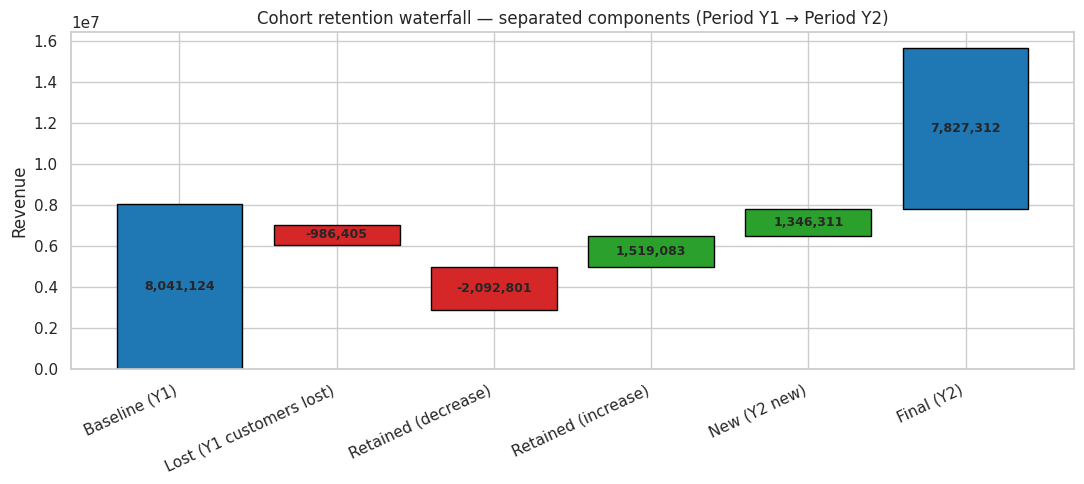

{'baseline_rev': np.float64(8041124.17), 'lost_rev': np.float64(986405.06), 'retained_decrease': np.float64(2092800.8199999998), 'retained_increase': np.float64(1519082.64), 'new_rev': np.float64(1346310.83), 'final_from_components': np.float64(7827311.759999999), 'total_rev_b': np.float64(7827311.76)}


In [88]:
metrics, (fig, ax) = cohort_waterfall(
    id_df,
    date_col='InvoiceDate',
    customer_col='CustomerID',
    amount_col='TotalPrice',
    period_a=(pd.Timestamp('2009-12-01'), pd.Timestamp('2010-11-30')),
    period_b=(pd.Timestamp('2010-12-01'), pd.Timestamp('2011-11-30'))
)
plt.show()   # tampilkan plot
print(metrics)

# 2. Geographic Analysis

In [81]:
# Revenue per Country
country_revenue = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)
country_revenue_share = country_revenue / country_revenue.sum() * 100
country_customers = df.groupby('Country')['CustomerID'].nunique().sort_values(ascending=False)
customer_percentage = country_customers / country_customers.sum() * 100


# Create a DataFrame from the calculated revenue and revenue share
country_revenue_df = pd.DataFrame({
    'Revenue per Country': country_revenue,
    'Revenue Share (%)': country_revenue_share,
})
country_customers_df = pd.DataFrame({
    'Number of Customers': country_customers,
    'Customer Percentage (%)': customer_percentage
})

# Display the table
display(country_revenue_df.style.format({"Revenue per Country": "{:,.2f}", "Revenue Share (%)": "{:.2f}%"}))
display(country_customers_df.style.format({"Number of Customers": "{:,.0f}", "Customer Percentage (%)": "{:.2f}%"}))

,Revenue per Country,Revenue Share (%)
Country,,
United Kingdom,"15,702,178.23",85.26%
EIRE,"595,463.89",3.23%
Netherlands,"532,986.34",2.89%
Germany,"367,728.81",2.00%
France,"287,039.93",1.56%
Australia,"166,282.15",0.90%
Switzerland,"92,918.06",0.50%
Spain,"84,568.13",0.46%
Sweden,"84,345.17",0.46%


,Number of Customers,Customer Percentage (%)
Country,,
United Kingdom,"5,337",90.87%
Germany,106,1.80%
France,93,1.58%
Spain,37,0.63%
Belgium,29,0.49%
Switzerland,23,0.39%
Portugal,23,0.39%
Netherlands,22,0.37%
Sweden,20,0.34%


**Findings**:

1. The customer base is heavily concentrated in the United Kingdom, which constitutes approximately 90% of all customers.
2. This geographic concentration is mirrored in the revenue, where UK customers contribute about 85% of the total income, highlighting a strong domestic market foundation.
3. While this indicates strong loyalty and market penetration domestically, it also reveals a significant opportunity for international expansion, as the global foothold remains limited.

In [82]:
yoy_comparison(all_uk_df)

,Year,TotalRevenue,TotalCustomer,TotalTransactions,TotalQuantity,AvgOrderValue,AvgRevenueperUser
0,First Year,7878660.16,3940,21725,4447237,298.98,298.98
1,Second Year,7823518.07,3908,19973,4180104,297.35,297.35


In [83]:
yoy_comparison(all_int_df)

,Year,TotalRevenue,TotalCustomer,TotalTransactions,TotalQuantity,AvgOrderValue,AvgRevenueperUser
0,First Year,1266861.80,326,1856,981685,560.79,560.79
1,Second Year,1447207.54,414,2159,882046,545.94,545.94


**Finding:**
A year-over-year customer geographic analysis reveals a strategic shift in the customer base. While the store experienced a decrease in domestic (UK) customers in its second year, this was successfully offset by a significant growth in its international customer segment.

# 3. Non-Identified Customers Analysis

In [89]:
def making_customers_distribution_chart(data):
  first_year_data = data[data['InvoiceDate'] < '2010-12-01 00:00:00']
  second_year_data = data[data['InvoiceDate'] >= '2010-12-01 00:00:00']

  # First Year
  non_member_pct_1 = first_year_data[first_year_data['CustomerID'] == '0'].shape[0] / first_year_data.shape[0] * 100
  member_pct_1 = first_year_data[first_year_data['CustomerID'] != '0'].shape[0] / first_year_data.shape[0] * 100

  # Second Year
  non_member_pct_2 = second_year_data[second_year_data['CustomerID'] == '0'].shape[0] / second_year_data.shape[0] * 100
  member_pct_2 = second_year_data[second_year_data['CustomerID'] != '0'].shape[0] / second_year_data.shape[0] * 100

  fig, axs = plt.subplots(1, 2, figsize=(10, 4))

  # Chart 1: First Year
  axs[0].pie(
        [member_pct_1, non_member_pct_1],
        labels=['Member', 'Non-Member'],
        autopct='%1.1f%%',
        startangle=90,
        counterclock=False
    )
  axs[0].set_title("First Year Customer Type Distribution")

  # Chart 2: Second Year
  axs[1].pie(
        [member_pct_2, non_member_pct_2],
        labels=['Member', 'Non-Member'],
        autopct='%1.1f%%',
        startangle=90,
        counterclock=False
    )
  axs[1].set_title("Second Year Customer Type Distribution")

  plt.tight_layout()
  plt.show()

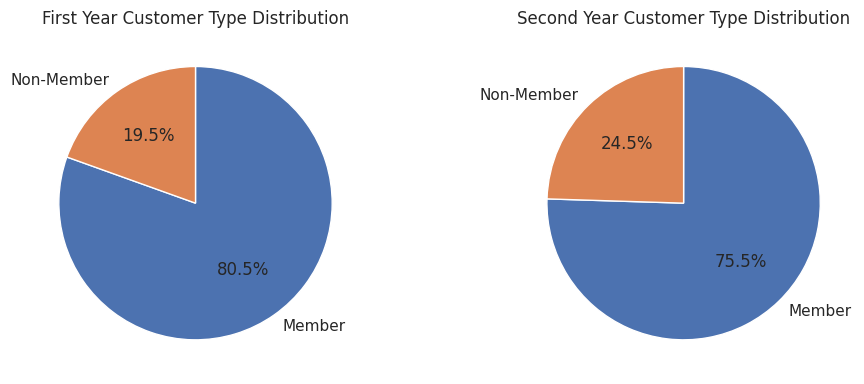

In [90]:
making_customers_distribution_chart(df)

In [91]:
def non_identified_revenue_share(data):
  first_year_data = data[data['InvoiceDate'] < '2010-12-01 00:00:00']
  second_year_data = data[data['InvoiceDate'] >= '2010-12-01 00:00:00']

  non_id_first_year = first_year_data[first_year_data['CustomerID'] == '0']
  non_id_second_year = second_year_data[second_year_data['CustomerID'] == '0']

  # Customer Metrics Table
  first_year_revenue = first_year_data['TotalPrice'].sum()
  second_year_revenue = second_year_data['TotalPrice'].sum()

  # Non-Identified Customer Revenue
  first_year_nonid_revenue = non_id_first_year['TotalPrice'].sum()
  second_year_nonid_revenue = non_id_second_year['TotalPrice'].sum()

  # Non-Identified Customer Revenue Share
  first_year_nonid_revenue_share = first_year_nonid_revenue / first_year_revenue * 100
  second_year_nonid_revenue_share = second_year_nonid_revenue / second_year_revenue * 100

  print((f"Revenue Share of Non-Identified Customers in the first year: {first_year_nonid_revenue_share}"))
  print((f"Revenue Share of Non-Identified Customers in the second year: {second_year_nonid_revenue_share}"))

In [92]:
non_identified_revenue_share(df)

Revenue Share of Non-Identified Customers in the first year: 11.584476256618162
Revenue Share of Non-Identified Customers in the second year: 15.14006291466542


In [93]:
# Calculate total revenue for each dataset
total_id_revenue = id_df['TotalPrice'].sum()
total_nonid_revenue = non_id_df['TotalPrice'].sum()

# Calculate revenue share for identified customers
top_id = (
    id_df.groupby(['StockCode', 'Description'])['TotalPrice']
    .sum()
    .reset_index()
    .assign(RevenueShare=lambda x: (x['TotalPrice'] / total_id_revenue) * 100)
    .sort_values('RevenueShare', ascending=False)
    .head(10)
    .reset_index(drop=True)
)
top_id = top_id[['StockCode', 'Description', 'RevenueShare']]
top_id.columns = ['ID_StockCode', 'ID_Description', 'ID_RevenueShare(%)']

# Calculate revenue share for non-identified customers
top_nonid = (
    non_id_df.groupby(['StockCode', 'Description'])['TotalPrice']
    .sum()
    .reset_index()
    .assign(RevenueShare=lambda x: (x['TotalPrice'] / total_nonid_revenue) * 100)
    .sort_values('RevenueShare', ascending=False)
    .head(10)
    .reset_index(drop=True)
)
top_nonid = top_nonid[['StockCode', 'Description', 'RevenueShare']]
top_nonid.columns = ['NonID_StockCode', 'NonID_Description', 'NonID_RevenueShare(%)']

# Combine both tables
top_products_comparison = pd.concat([top_id, top_nonid], axis=1)
top_products_comparison

,ID_StockCode,ID_Description,ID_RevenueShare(%),NonID_StockCode,NonID_Description,NonID_RevenueShare(%)
0,22423,REGENCY CAKESTAND 3 TIER,1.61,22423,REGENCY CAKESTAND 3 TIER,2.09
1,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1.48,47566,PARTY BUNTING,1.81
2,85099B,JUMBO BAG RED RETROSPOT,0.82,22086,PAPER CHAIN KIT 50'S CHRISTMAS,1.54
3,84879,ASSORTED COLOUR BIRD ORNAMENT,0.76,22355,CHARLOTTE BAG SUKI DESIGN,1.10
4,47566,PARTY BUNTING,0.64,22114,HOT WATER BOTTLE TEA AND SYMPATHY,0.90
5,22086,PAPER CHAIN KIT 50'S CHRISTMAS,0.45,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,0.59
6,79321,CHILLI LIGHTS,0.42,85123A,WHITE HANGING HEART T-LIGHT HOLDER,0.56
7,85099F,JUMBO BAG STRAWBERRY,0.40,85099B,JUMBO BAG RED RETROSPOT,0.55
8,21137,BLACK RECORD COVER FRAME,0.36,21931,JUMBO STORAGE BAG SUKI,0.55
9,21621,VINTAGE UNION JACK BUNTING,0.34,84467,ENGLISH ROSE DESIGN QUILTED THROW,0.53


In [94]:
id_df[id_df['StockCode'].str.startswith('DCGS')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearMonth,TotalPrice,period,OrderCount,Month,Season


In [95]:
id_df[~id_df['StockCode'].isin(non_id_df['StockCode'])]['StockCode'].value_counts().head(20)

,count
StockCode,
16161P,435
21588,280
23232,231
22415,204
23233,159
71038,151
16169E,138
72232,118
22050,116


**Finding:**
Only non-identified customers buy products that has **DCGS** on their stock code.

In [96]:
# Metrics for Non-Identified Customers
non_id_metrics = non_id_df.groupby('period').agg({
                    'TotalPrice': 'sum',
                    'InvoiceNo': 'nunique',
                    'Quantity': 'sum',
                    'StockCode': 'nunique'
                 })
non_id_metrics.columns = ['TotalRevenue', 'TotalTransactions', 'TotalQuantity', 'UniqueProducts']

# Metrics for Identified Customers
id_metrics = id_df.groupby('period').agg({
                    'TotalPrice': 'sum',
                    'InvoiceNo': 'nunique',
                    'Quantity': 'sum',
                    'StockCode': 'nunique'
             })
id_metrics.columns = ['TotalRevenue', 'TotalTransactions', 'TotalQuantity', 'UniqueProducts']

metrics_table = pd.concat([non_id_metrics, id_metrics], axis=0)

# Create MultiIndex for columns
categories = ['Non-Identified', 'Identified']
years = ['year1', 'year2']

# Create MultiIndex columns using categories and years
columns = pd.MultiIndex.from_product([categories, years],
                                    names=['Category', 'Year'])

# Reorganize data to match the new column structure
data = []
for metric in ['TotalRevenue', 'TotalTransactions', 'TotalQuantity', 'UniqueProducts']:
    row = []
    # Add Non-Identified data for year1 and year2
    row.extend([non_id_metrics.loc['year1', metric], non_id_metrics.loc['year2', metric]])
    # Add Identified data for year1 and year2
    row.extend([id_metrics.loc['year1', metric], id_metrics.loc['year2', metric]])
    data.append(row)

# Create DataFrame with hierarchical (MultiIndex) columns
metrics_table = pd.DataFrame(data,
                           index=['TotalRevenue', 'TotalTransactions', 'TotalQuantity', 'UniqueProducts'],
                           columns=columns)

# metrics_table now shows aggregated metrics for both customer categories over two years
metrics_table

Category          Non-Identified            Identified           
Year                       year1      year2      year1      year2
TotalRevenue          1059460.82 1403593.69 8086061.14 7867131.92
TotalTransactions        1607.00    1360.00   21974.00   20772.00
TotalQuantity          268550.00  390479.00 5160372.00 4671671.00
UniqueProducts           3494.00    3277.00    4011.00    3669.00

# 4. Monthly Metrics Overview

In [97]:
def monthly_kpi(data):
    """
    Compute monthly key performance indicators (KPIs) from transaction-level data.
    """

    # Aggregate core KPIs by month:
    kpi_table = data.groupby('Month').agg({
        'TotalPrice': 'sum',
        'CustomerID': 'nunique',
        'Quantity': 'sum',
        'StockCode': 'nunique'
    }).reset_index()
    kpi_table.columns = ['Month', 'TotalRevenue', 'TotalCustomers', 'TotalQuantity', 'UniqueProducts']

    # Generate transaction-level metrics
    metrics_table = transaction_metrics(data)

    # Sum monthly transaction counts
    transactions_table = metrics_table.groupby('Month').agg({
        'OrderCount': 'sum'
    }).reset_index()
    transactions_table.columns = ['Month', 'TotalTransactions']

    # Merge core KPI table with transaction count table
    kpi_table = pd.merge(kpi_table, transactions_table, on='Month', how='left')

    # Calculate additional metrics
    kpi_table['AvgOrderValue'] = kpi_table['TotalRevenue'] / kpi_table['TotalTransactions']
    kpi_table['AvgRevenueperUser'] = kpi_table['TotalRevenue'] / kpi_table['TotalCustomers']

    return kpi_table

In [98]:
def monthly_kpi_chart(data):
    # Filter the dataset for the first and second year periods
    # Assumption: the dataset contains a column named 'period'
    first_year_data = data[data['period'] == 'year1']
    second_year_data = data[data['period'] == 'year2']

    # Compute monthly KPIs for each year using the monthly_kpi() function
    first_year_kpis = monthly_kpi(first_year_data)
    second_year_kpis = monthly_kpi(second_year_data)

    # List of KPI metrics to visualize
    kpi_list = [
        'TotalRevenue',
        'TotalCustomers',
        'TotalTransactions',
        'TotalQuantity',
        'UniqueProducts',
        'AvgOrderValue',
        'AvgRevenueperUser'
    ]

    # Loop through each KPI and generate a line chart comparing both years
    for kpi in kpi_list:
        plt.figure(figsize=(12, 6))

        # Plot KPI values for the first year
        plt.plot(
            first_year_kpis.index.astype(str),
            first_year_kpis[kpi],
            marker='o',
            label='First Year'
        )

        # Plot KPI values for the second year
        plt.plot(
            second_year_kpis.index.astype(str),
            second_year_kpis[kpi],
            marker='o',
            label='Second Year'
        )
        plt.title(f'{kpi} Comparison (First vs Second Year)')
        plt.xlabel('Month')
        plt.ylabel(kpi)
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

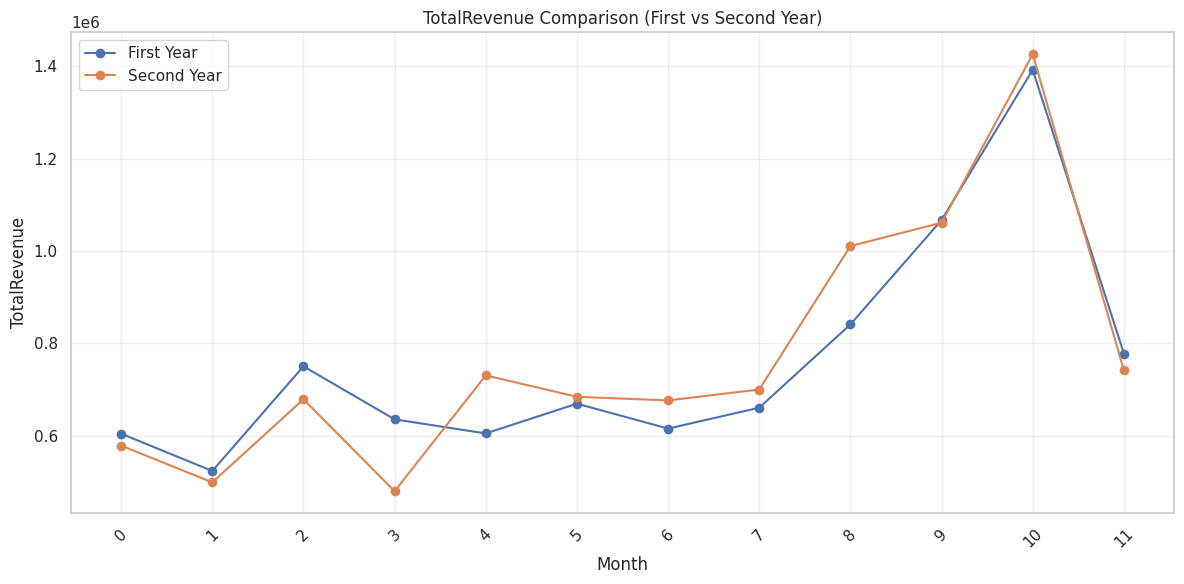

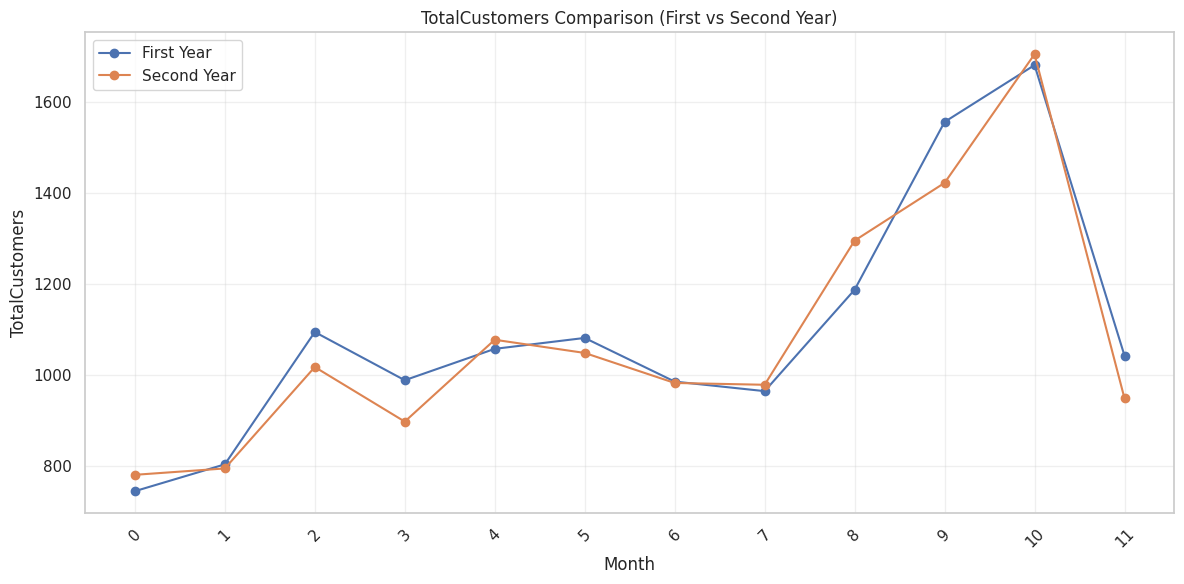

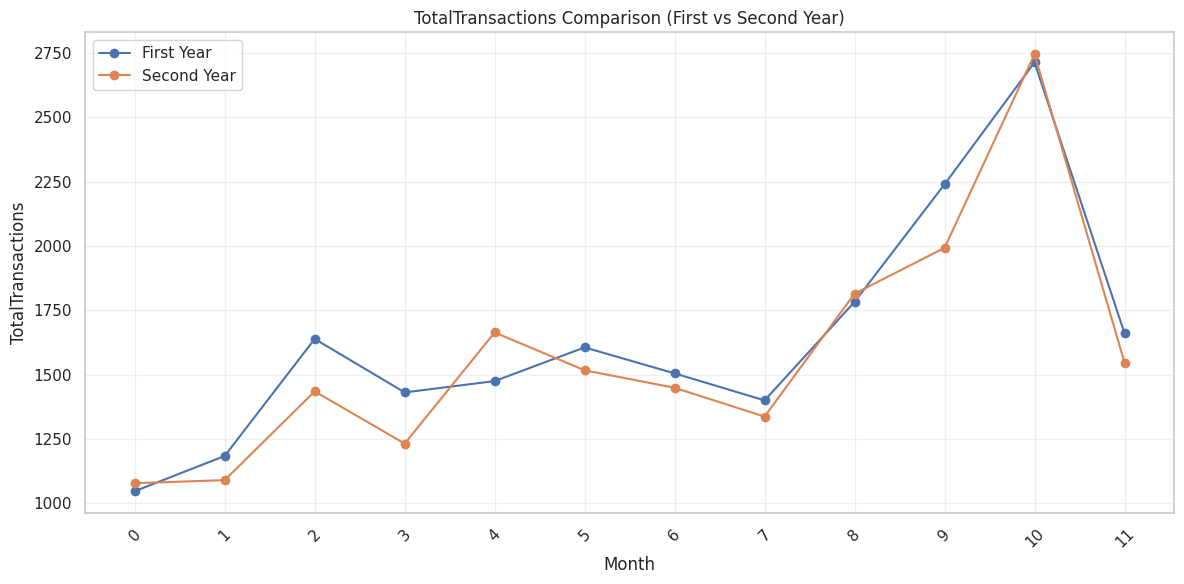

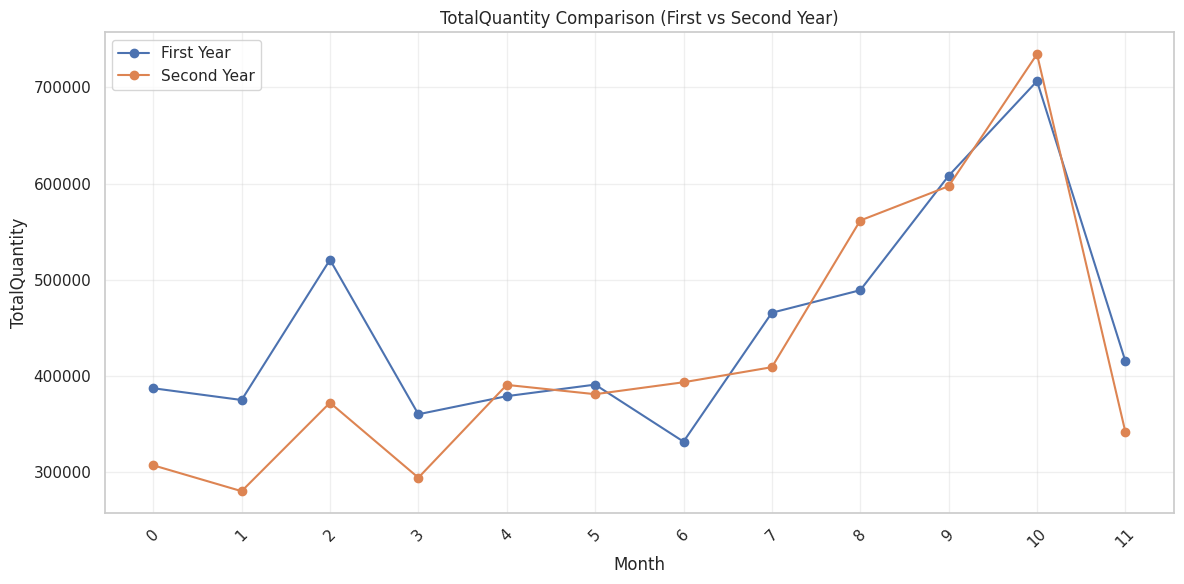

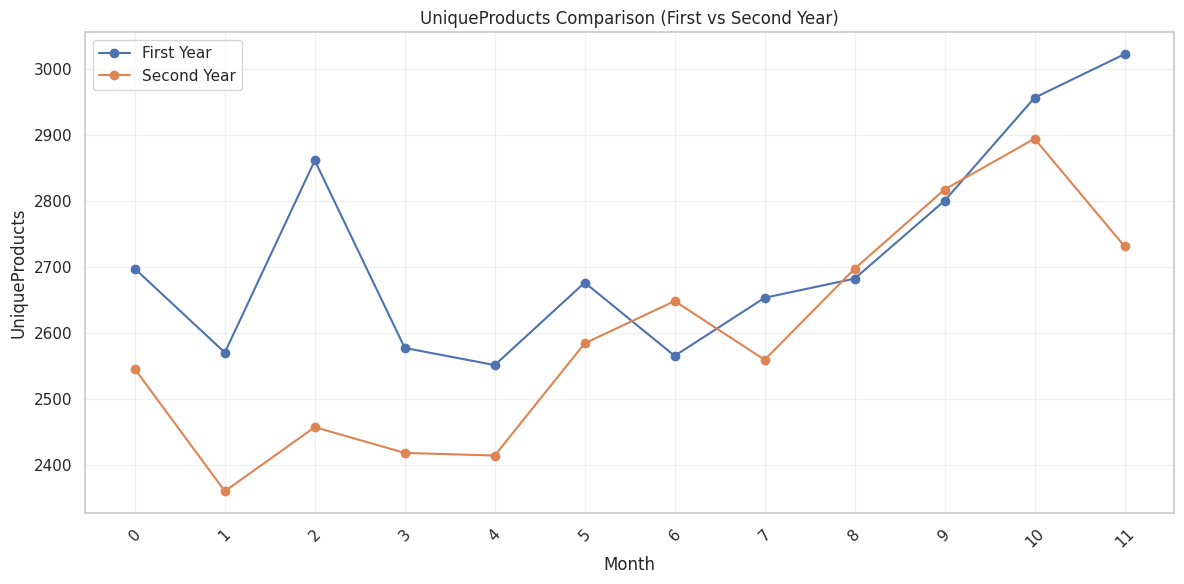

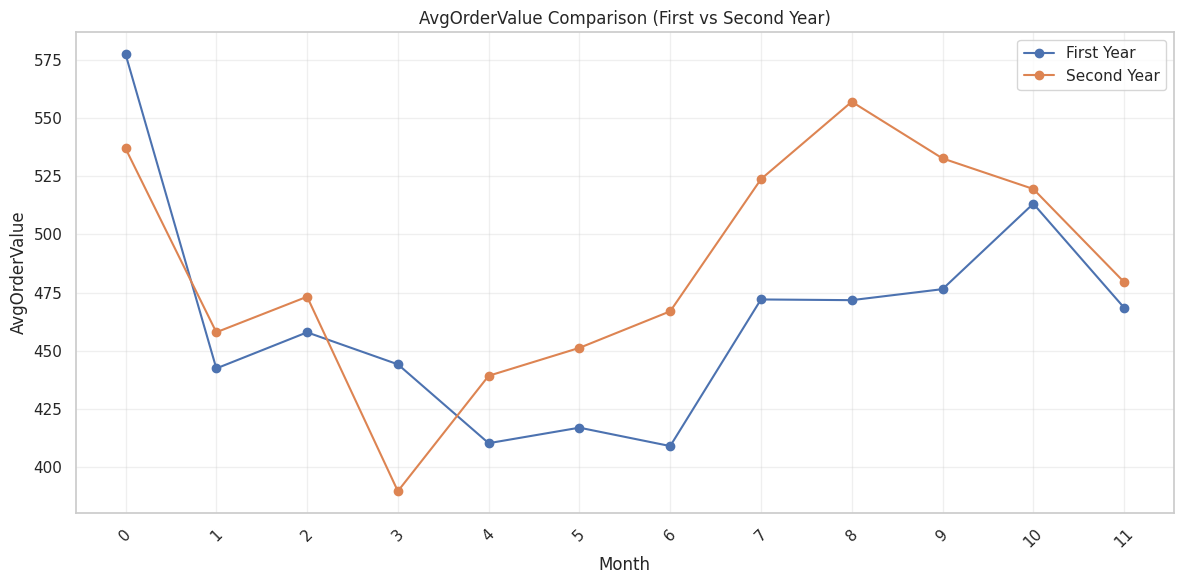

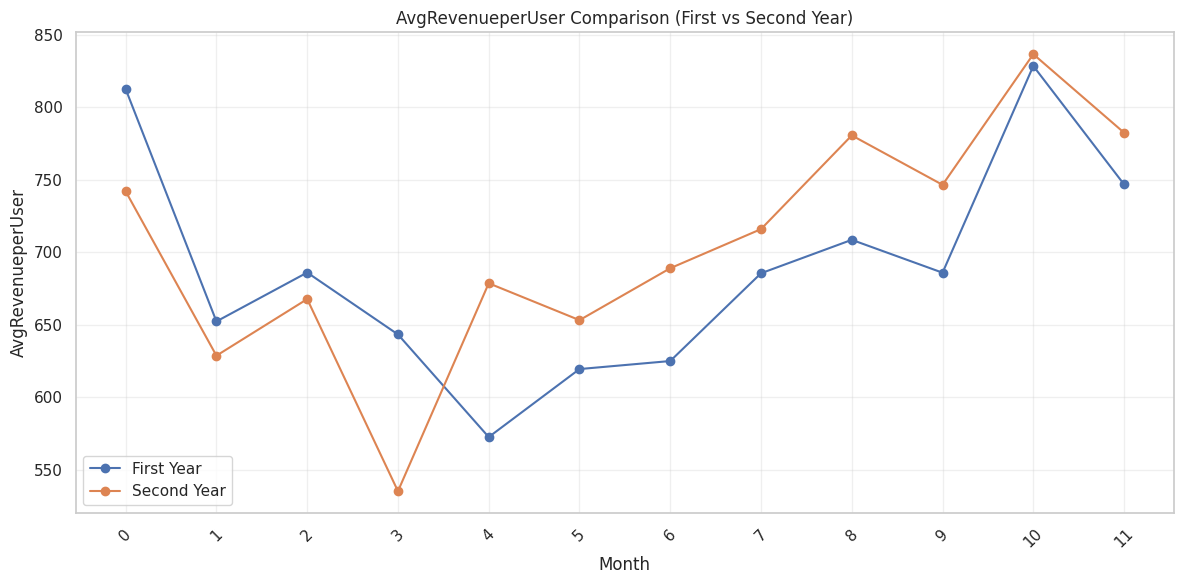

In [99]:
monthly_kpi_chart(df)

**Finding:**
1. There is no meaningful difference between the key performance indicators of the first and second year.
2. Found that there are noticable sales increases in the **revenue**, **customer**, and **product**'s quantity in **September**-**November** (**Fall Season**).

# 5. Seasonal Metrics Overview

In [100]:
def seasonal_non_id_kpi_chart(data):
  # Transaction-level metrics
  def transaction_metrics(data):
    first_year_data = data[data['InvoiceDate'] < '2010-12-01 00:00:00']
    second_year_data = data[data['InvoiceDate'] >= '2010-12-01 00:00:00']

    def invoice_metrics(datas):
      transaction_metric = datas.groupby('InvoiceNo').agg({
      'StockCode': 'nunique',
      'TotalPrice': 'sum',
      'Quantity': 'sum',
      'Country': 'first',
      'Season': 'first'
      }).reset_index()

      transaction_metric.columns = ['InvoiceNo', 'UniqueProducts',
                                    'TotalRevenue', 'TotalQuantity',
                                    'Country', 'Season']

      return transaction_metric

    # Metrics for each year
    first_year_transactions = invoice_metrics(first_year_data)
    second_year_transactions = invoice_metrics(second_year_data)

    return first_year_transactions, second_year_transactions

  first_year, second_year = transaction_metrics(data)

  first = first_year.groupby('Season')['TotalRevenue'].sum()
  second = second_year.groupby('Season')['TotalRevenue'].sum()

  first.name = 'FirstYear'
  second.name = 'SecondYear'

  # Combine both years into a single DataFrame for comparison
  seasonal_compare = pd.concat([first, second], axis=1)

  # Reorder index to display seasons in chronological order
  season_order = ['Spring', 'Summer', 'Fall', 'Winter']
  seasonal_compare = seasonal_compare.reindex(season_order)

  # Plot line chart for seasonal revenue comparison
  plt.figure(figsize=(8, 5))
  plt.plot(seasonal_compare.index, seasonal_compare['FirstYear'], marker='o', label='First Year')
  plt.plot(seasonal_compare.index, seasonal_compare['SecondYear'], marker='o', label='Second Year')

  # Aesthetic adjustments for clarity
  plt.title('Seasonal Revenue Comparison (YoY)')
  plt.xlabel('Season')
  plt.ylabel('Total Revenue')
  plt.legend()
  plt.grid(True, linestyle='--', alpha=0.6)
  plt.tight_layout()

  plt.show()

  # Return transaction-level data for both years
  return first_year, second_year

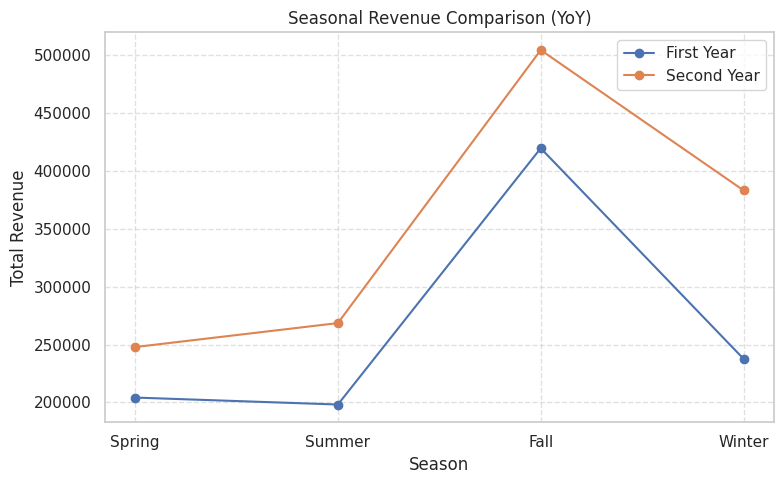

In [101]:
first, second = seasonal_non_id_kpi_chart(non_id_df)

In [102]:
def seasonal_kpi(data):

  kpi_table = data.groupby('Season').agg({
    'TotalPrice': 'sum',
    'CustomerID': 'nunique',
    'Quantity': 'sum',
    'StockCode': 'nunique'
  }).reset_index()
  kpi_table.columns = ['Season', 'TotalRevenue', 'TotalCustomers', 'TotalQuantity', 'UniqueProducts']

  metrics_table = transaction_metrics(data)
  transactions_table = metrics_table.groupby('Season').agg({
      'OrderCount':'sum'
  }).reset_index()

  transactions_table.columns = ['Season', 'TotalTransactions']

  kpi_table = pd.merge(kpi_table, transactions_table, on='Season', how='left')

  kpi_table['AvgOrderValue'] = kpi_table['TotalRevenue'] / kpi_table['TotalTransactions']
  kpi_table['AvgRevenueperUser'] = kpi_table['TotalRevenue'] / kpi_table['TotalCustomers']

  # Ensure consistent season order
  season_order = ['Spring', 'Summer', 'Fall', 'Winter']
  kpi_table['Season'] = pd.Categorical(kpi_table['Season'], categories=season_order, ordered=True)
  kpi_table = kpi_table.sort_values('Season')

  return kpi_table

In [103]:
# Analyzing Seasonal KPI

def seasonal_kpi_chart(data):

  first_year_data = data[data['InvoiceDate'] < '2010-12-01 00:00:00']
  second_year_data = data[data['InvoiceDate'] >= '2010-12-01 00:00:00']

  first_year_kpis = seasonal_kpi(first_year_data)
  second_year_kpis = seasonal_kpi(second_year_data)

  kpi_list = ['TotalRevenue', 'TotalCustomers', 'TotalTransactions',
              'TotalQuantity', 'UniqueProducts', 'AvgOrderValue',
              'AvgRevenueperUser']

  # KPI Line Chart
  for kpi in kpi_list:
      plt.figure(figsize=(12, 6))
      plt.plot(first_year_kpis['Season'], first_year_kpis[kpi], marker='o', label='First Year')
      plt.plot(second_year_kpis['Season'], second_year_kpis[kpi], marker='o', label='Second Year')
      plt.title(f'{kpi} Comparison (First vs Second Year)')
      plt.xlabel('Season')
      plt.ylabel(kpi)
      plt.xticks(rotation=45)
      plt.legend()
      plt.grid(True, alpha=0.3)
      plt.tight_layout()
      plt.show()

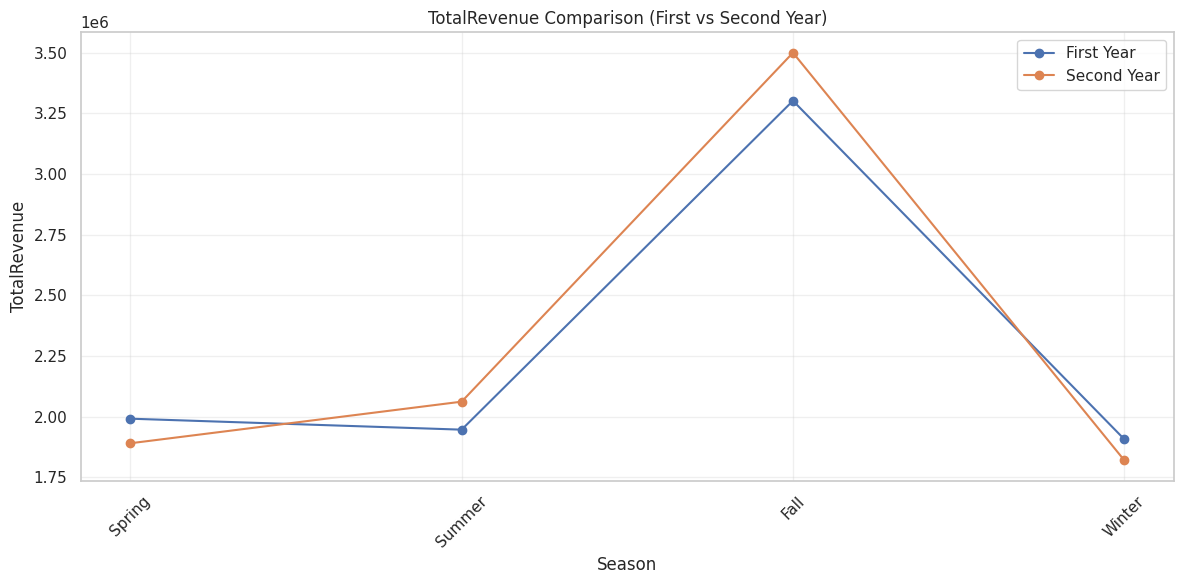

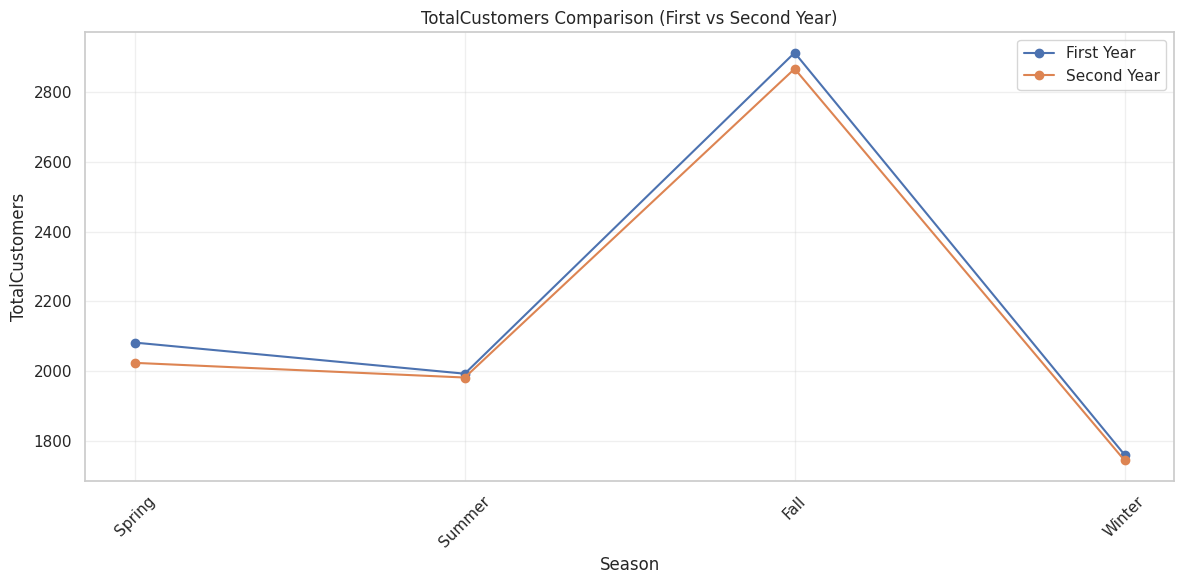

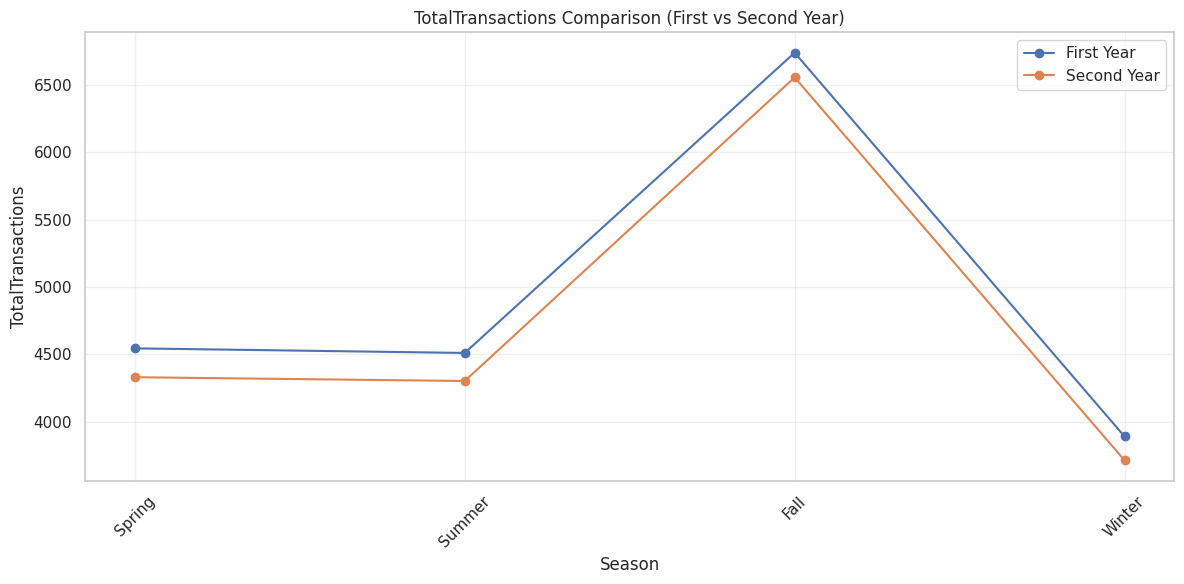

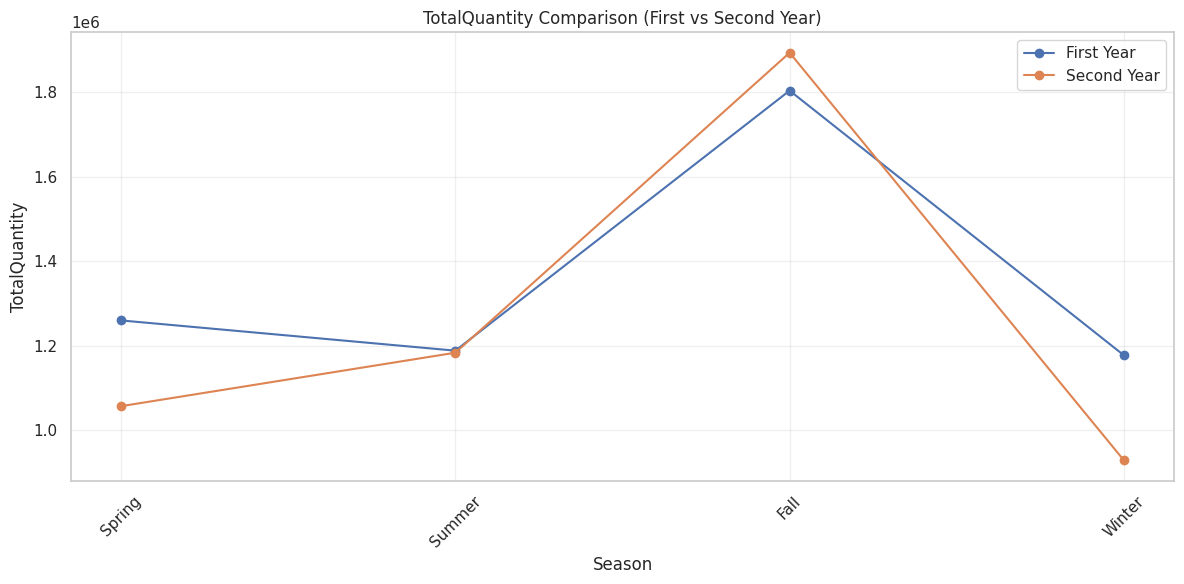

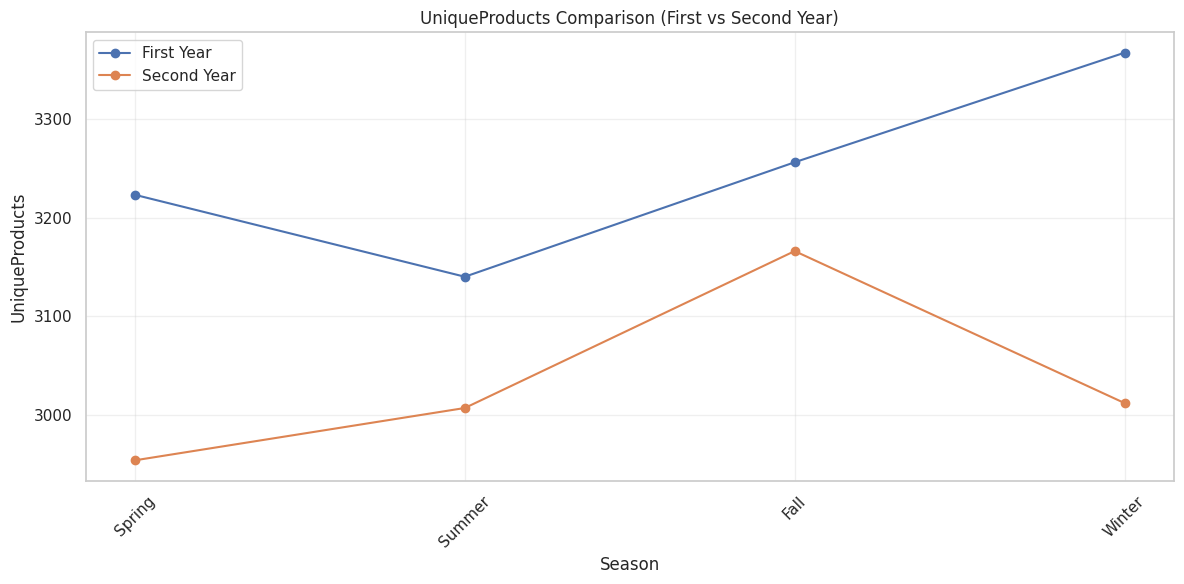

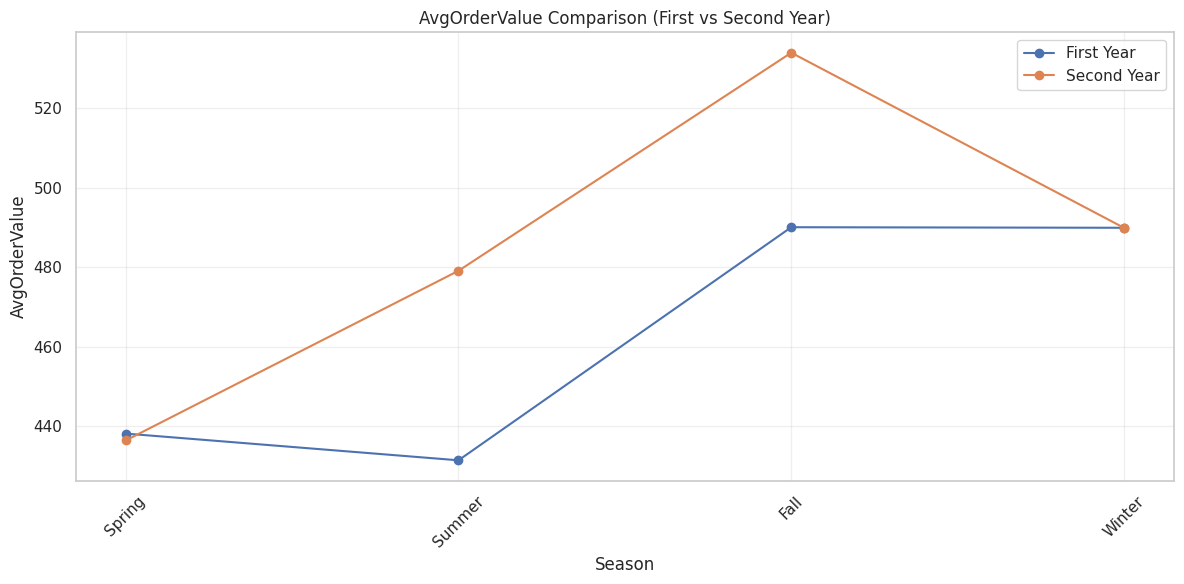

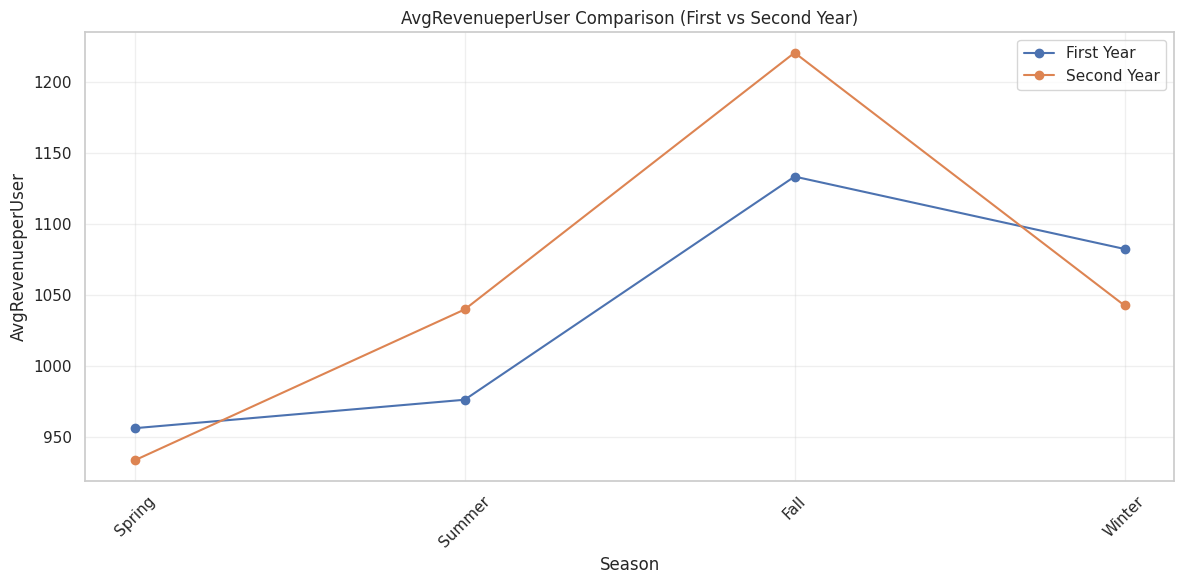

In [104]:
seasonal_kpi_chart(df)

**Finding:**
1. Performance analysis reveals a significant seasonal effect, with the **Fall** season demonstrating markedly higher values across almost all business metrics compared to **Spring**, **Summer**, and **Winter**.
2. **Unique Products** is the sole exception to this trend, showing no spike in **Fall**. This suggests that while sales volume and revenue increase, customer purchases are heavily concentrated on some specific category of products, rather than a wider variety.

# 6. Metrics Analysis

In [105]:
all_customer_metrics['MonetaryLog'] = np.log1p(all_customer_metrics['Monetary'])

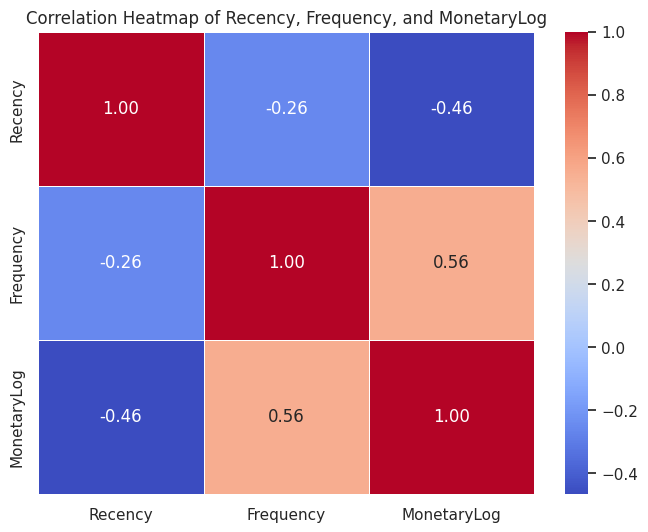

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_table = all_customer_metrics[['Recency', 'Frequency', 'MonetaryLog']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_table, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Recency, Frequency, and MonetaryLog')
plt.show()

**Finding:**

1. A significant positive correlation exists between Monetary value and Frequency, indicating that customers who spend more (Monetary) also tend to make purchases more often (Frequency).
2. A moderate positive correlation is observed between Monetary value and Recency, suggesting that customers with higher total spending (Monetary) have also shopped more recently (Recency).
3. No significant correlation was found between Recency and Frequency, meaning the time since a customer's last purchase does not predict how often they have purchased in the past, and vice-versa.

In [107]:
def customer_metrics_distribution(data):
  customer_metric = customer_metrics(data)
  customer_metric['Monetary_log'] = np.log1p(customer_metric['Monetary'])

  fig, axes = plt.subplots(2, 2, figsize=(14, 10)) # Changed to 3x2 grid

  sns.histplot(customer_metric['Monetary_log'], bins=100, kde=True, ax=axes[0, 0])
  axes[0, 0].set_title('Distribution of Monetary Value (Logarithmic Scale)')
  axes[0, 0].set_xlabel('Monetary (Logarithmic Scale)')
  axes[0, 0].set_ylabel('Count')

  sns.histplot(customer_metric['Monetary'], bins=100, kde=True, ax=axes[0, 1])
  axes[0, 1].set_title('Distribution of Monetary Value')
  axes[0, 1].set_xlabel('Monetary')
  axes[0, 1].set_ylabel('Count')

  sns.histplot(customer_metric['Recency'], bins=100, kde=True, ax=axes[1, 0])
  axes[1, 0].set_title('Distribution of Recency Value')
  axes[1, 0].set_xlabel('Recency')
  axes[1, 0].set_ylabel('Count')

  sns.histplot(customer_metric['Frequency'], bins=100, kde=True, ax=axes[1, 1])
  axes[1, 1].set_title('Distribution of Frequency Value')
  axes[1, 1].set_xlabel('Frequency')
  axes[1, 1].set_ylabel('Count')

  plt.tight_layout()
  plt.show()

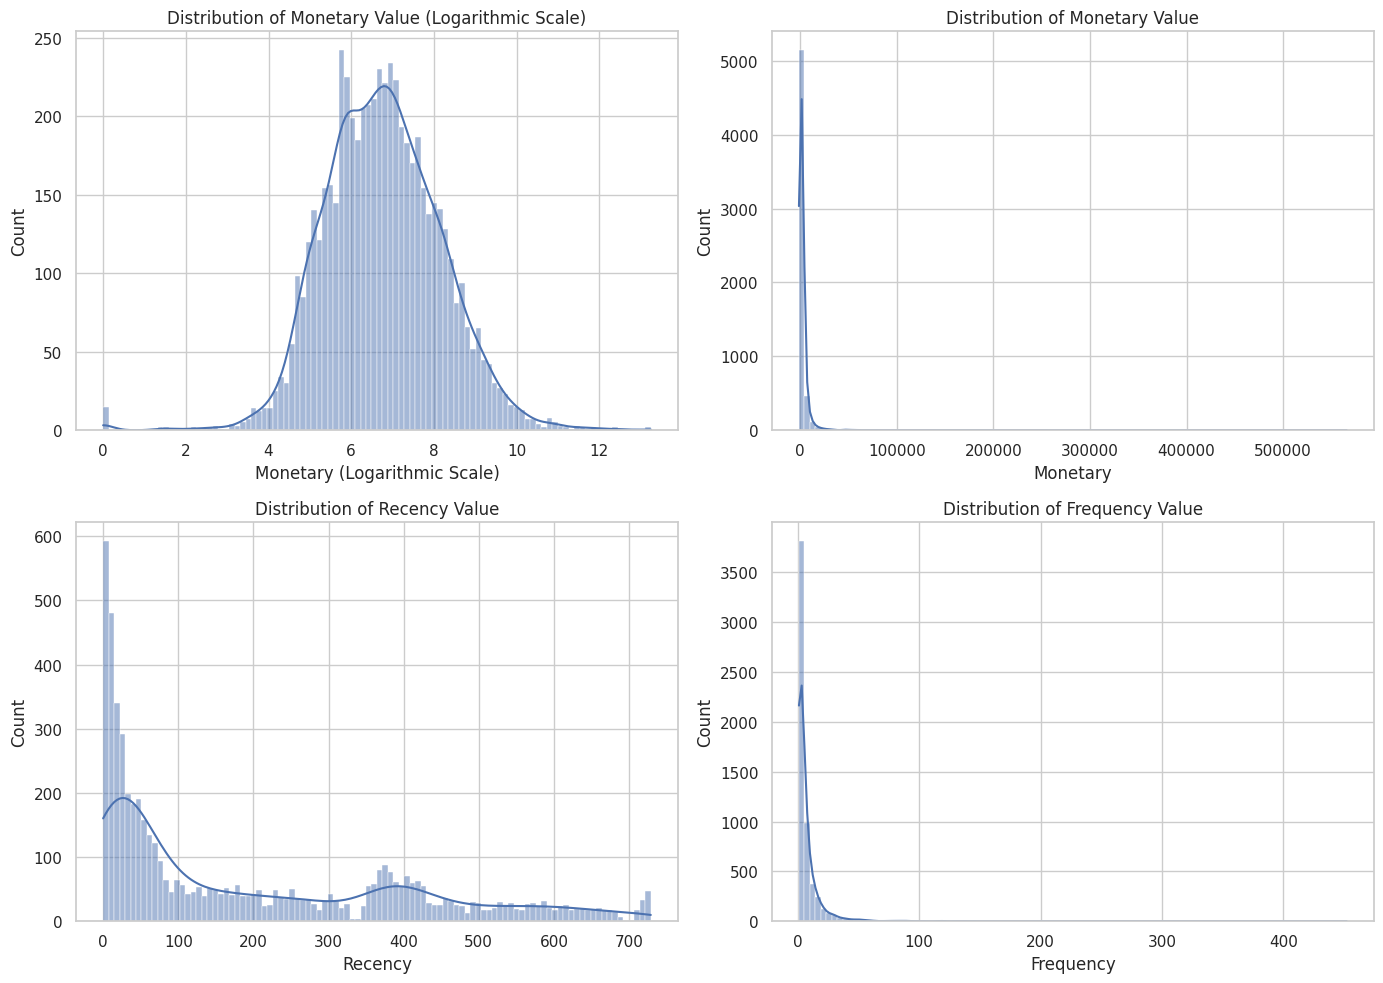

In [108]:
customer_metrics_distribution(id_df)

**Findings**:
The RFM analysis reveals significant skewness in the **Monetary** and **Frequency** distributions. This indicates that a vast majority of the customer base contributes relatively little value, while a very small segment of high-value customers is responsible for a disproportionately large share of purchases and revenue.

In [109]:
def pareto_chart(df, category_col, value_col):

    q100 = df['Monetary'].max()
    q95 = df['Monetary'].quantile(0.95)
    q80 = df['Monetary'].quantile(0.80)
    q50 = df['Monetary'].quantile(0.50)
    df['CustCategory'] = pd.cut(df['Monetary'], bins=[0,q50,q80,q95,q100], labels=['Bottom 50%','Top 20-50%','Top 5-20%','Top 0-5%'])

    data = df.groupby(category_col)[value_col].sum().sort_values(ascending=False)
    cumulative = data.cumsum() / data.sum()

    fig, ax1 = plt.subplots()

    # Bar chart (warna biru)
    ax1.bar(data.index, data.values, color='steelblue')
    ax1.set_ylabel('Value')
    ax1.set_xticklabels(data.index, rotation=45, ha='right')

    # Line chart cumulative % (warna oranye)
    ax2 = ax1.twinx()
    ax2.plot(data.index, cumulative.values, marker='o', color='darkorange')
    ax2.set_ylabel('Cumulative %')
    ax2.set_ylim(0, 1)

    # Add percentage annotations to the line chart
    for i, txt in enumerate(cumulative.values):
        ax2.annotate(f'{txt:.1%}', (data.index[i], cumulative.values[i]), textcoords="offset points", xytext=(0,10), ha='center')

    plt.title('Customer Pareto Chart Y1')
    plt.tight_layout()
    plt.show()

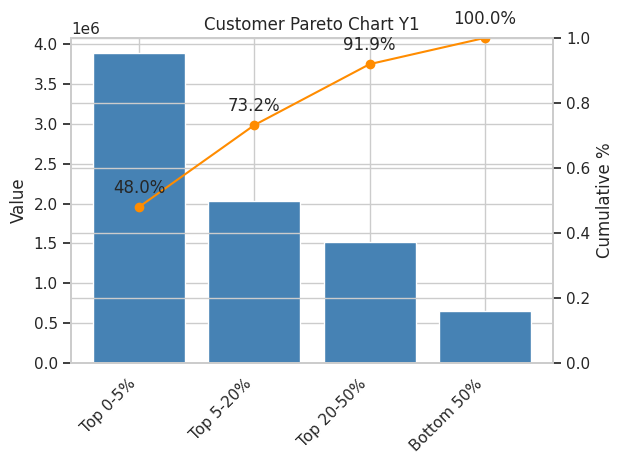

In [110]:
first_year_metrics_id = first_year_metrics[first_year_metrics['CustomerID'] != '0']
pareto_chart(first_year_metrics_id, 'CustCategory', 'Monetary')

In [111]:
def calculating_top_customers_revenue_share(data):
  customer_metricz = customer_metrics(data)
  total_revenue = data['TotalPrice'].sum()

  top_monetary = customer_metricz['Monetary'].quantile(0.98)
  top2_monetary = customer_metricz['Monetary'].quantile(0.95)
  top20_monetary = customer_metricz['Monetary'].quantile(0.80)
  bottom50_monetary = customer_metricz['Monetary'].quantile(0.50)

  top_revenue = customer_metricz[customer_metricz['Monetary'] >= top_monetary]['Monetary'].sum()
  top2_revenue = customer_metricz[customer_metricz['Monetary'] >= top2_monetary]['Monetary'].sum()
  top20_revenue = customer_metricz[customer_metricz['Monetary'] >= top20_monetary]['Monetary'].sum()
  bottom50_revenue = customer_metricz[customer_metricz['Monetary'] < top20_monetary]['Monetary'].sum()

  data_revenue_share = {
    'Category': ['Top 2%', 'Top 5%', 'Top 20%', 'Bottom 50%'],
    'Total Revenue': [top_revenue, top2_revenue, top20_revenue, bottom50_revenue],
    'Threshold': [top_monetary, top2_monetary, top20_monetary, bottom50_monetary],
    'Revenue Share (%)': [
        (top_revenue / total_revenue) * 100,
        (top2_revenue / total_revenue) * 100,
        (top20_revenue / total_revenue) * 100,
        (bottom50_revenue / total_revenue) * 100
    ]
  }

  data_revenue_share = pd.DataFrame(data_revenue_share)

  return data_revenue_share

In [112]:
first_year_id_df = id_df[id_df['period'] == 'year1']
second_year_id_df = id_df[id_df['period'] == 'year2']

display(calculating_top_customers_revenue_share(id_df))
display(calculating_top_customers_revenue_share(first_year_id_df))
display(calculating_top_customers_revenue_share(second_year_id_df))

,Category,Total Revenue,Threshold,Revenue Share (%)
0,Top 2%,6129657.13,16128.92,38.42
1,Top 5%,8150815.28,8727.16,51.09
2,Top 20%,12249433.55,2761.49,76.78
3,Bottom 50%,3703759.51,825.73,23.22


,Category,Total Revenue,Threshold,Revenue Share (%)
0,Top 2%,2906976.06,10986.51,35.95
1,Top 5%,3884257.21,5807.36,48.04
2,Top 20%,5920554.57,2005.37,73.22
3,Bottom 50%,2165506.57,655.82,26.78


,Category,Total Revenue,Threshold,Revenue Share (%)
0,Top 2%,2901745.28,10204.93,36.88
1,Top 5%,3819466.82,5463.83,48.55
2,Top 20%,5796944.57,1880.68,73.69
3,Bottom 50%,2070187.35,626.40,26.31


**Finding:**
The analysis validates the initial hypothesis, revealing a highly concentrated revenue distribution where the bulk of total income is generated by a large, low-value customer cohort, illustrating a classic long-tail revenue pattern.

# **THE SEGMENTATION**

**Rationale for a Custom Segmentation Approach**

A traditional RFM (Recency, Frequency, Monetary) model was deemed unsuitable for this customer base due to several key business characteristics identified in the data:

1.  **Seasonal Purchasing Behavior:** The significant spike in the Fall season indicates that many customers make purchases based on seasonal timing. This behavior artificially skews **Recency** scores, making them an unreliable standalone indicator of engagement, as a customer could be "recent" simply due to their seasonal cycle rather than consistent activity.

2.  **Predominance of Wholesaler (B2B) Customers:** The dataset note stating "many of the customers are wholesalers," combined with the seasonal pattern, strongly suggests a B2B purchasing model. This implies that **Frequency** is not a uniform metric; it varies significantly based on the wholesaler's type—some may make regular, frequent orders, while others only purchase during specific occasions or seasons.

3.  **Extreme Revenue Concentration:** The revenue distribution is highly concentrated, with the top 20% of customers contributing approximately 73% of the annual revenue, and the top 2% alone accounting for about 36%. The bottom 80% of customers generate only 27% of the revenue. This stark disparity confirms that a one-size-fits-all customer treatment strategy is ineffective and that segmentation must directly reflect this value hierarchy.

**Conclusion:**

Given these factors, a modified segmentation strategy was implemented. The primary segmentation is driven by **Monetary** value to directly reflect a customer's revenue contribution. Subsequently, secondary statuses and behavioral labels (e.g., "Seasonal," "High-Frequency Wholesaler," "At-Risk Top Client") are layered on based on their **Frequency**, **Recency**, and purchasing patterns to provide a more nuanced and actionable view of the customer base.

In [113]:
import pandas as pd
import numpy as np
from pathlib import Path

# ---------------- PARAMETERS ----------------
start_y1 = pd.Timestamp("2009-12-01")
end_y1   = pd.Timestamp("2010-11-30 23:59:59")
start_y2 = pd.Timestamp("2010-12-01")
end_y2   = pd.Timestamp("2011-11-30 23:59:59")
cutoff_date = end_y2  # recency measured to this date

MONETARY_PCT_FOR_POTENTIAL = 0.65
FREQ_FOR_POTENTIAL = 40
RECENCY_FOR_POTENTIAL_DAYS = 90
ONE_OFF_PCT_TH = 0.5

NEW_RECENCY_DAYS = 30
NEW_FREQ_TH = 3

SEASONAL_THRESH = 0.5   # >= this share in one season -> seasonal candidate (plus active)
REPETITIVE_PCTL = 0.25
USE_ABSOLUTE_REPETITIVE = True
ABS_REPETITIVE_TH = 50

# Active threshold (days)
ACTIVE_DAYS_THRESHOLD = 273  # strict: active > 273

# Elite / Premium percentiles
ELITE_PCT = 0.98
PREMIUM_PCT = 0.80

def run_segmentation_v3(id_df, export_dir="/mnt/data", save_csv=True, verbose=True):
    """
    Segmentation pipeline v3 with VIP insertion (final_segment).
    Inputs:
      - id_df: DataFrame with expected transactional columns.
      - export_dir: folder to save CSV outputs.
    Returns:
      dict of DataFrames (customer_segments_final, customer_metrics, customer_segments_light, gross_vs_net_comparison, order_level_flags)
    """
    export_dir = Path(export_dir)
    export_dir.mkdir(parents=True, exist_ok=True)

    df = id_df.copy()

    # Ensure TotalPrice exists
    if 'TotalPrice' not in df.columns:
        df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

    # Parse InvoiceDate
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

    # Basic flags on rows (kept for trace)
    df['positive_order_flag'] = (df['TotalPrice'] > 0).astype(int)
    df['return_flag'] = (df['TotalPrice'] < 0).astype(int)
    df['order_sign'] = df['TotalPrice'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

    # Assign period (year1/year2) based on InvoiceDate
    def assign_period(dt):
        if pd.isnull(dt):
            return None
        if start_y1 <= dt <= end_y1:
            return 'year1'
        if start_y2 <= dt <= end_y2:
            return 'year2'
        return None

    df['period'] = df['InvoiceDate'].apply(assign_period)
    df_period = df[~df['period'].isna()].copy()

    # Filter to identified customers only (id_df_filtered)
    id_df_filtered = df_period[df_period['CustomerID'].notna()].copy()

    # ---------- Invoice-level aggregation (canonical invoice) ----------
    inv = id_df_filtered.groupby(['InvoiceNo','CustomerID','period'], dropna=False).agg(
        invoice_value=('TotalPrice','sum'),
        invoice_qty=('Quantity','sum'),
        invoice_date=('InvoiceDate','max'),
        distinct_skus=('StockCode','nunique')
    ).reset_index()

    inv['inv_pos_flag'] = (inv['invoice_value'] > 0).astype(int)
    inv['inv_neg_flag'] = (inv['invoice_value'] < 0).astype(int)

    # ---------- Customer-period aggregation ----------
    cust_period = inv.groupby(['CustomerID','period']).agg(
        total_rev=('invoice_value','sum'),
        num_invoices=('InvoiceNo','nunique'),
        total_qty=('invoice_qty','sum'),
        last_invoice_date=('invoice_date','max'),
        first_invoice_date=('invoice_date','min'),
        max_invoice_value=('invoice_value','max')
    ).reset_index()

    # Pivot to wide (customer-level)
    cust_pivot = cust_period.pivot(index='CustomerID', columns='period').fillna(0)
    cust_pivot.columns = ['_'.join(col).strip() for col in cust_pivot.columns.values]
    cust_pivot = cust_pivot.reset_index()

    # Ensure expected columns exist
    for col in ['total_rev_year1','total_rev_year2','num_invoices_year1','num_invoices_year2',
                'total_qty_year1','total_qty_year2','last_invoice_date_year1','last_invoice_date_year2',
                'first_invoice_date_year1','first_invoice_date_year2',
                'max_invoice_value_year1','max_invoice_value_year2']:
        if col not in cust_pivot.columns:
            cust_pivot[col] = 0

    # helper fields
    cust_pivot['rev_y1'] = cust_pivot['total_rev_year1']
    cust_pivot['rev_y2'] = cust_pivot['total_rev_year2']
    cust_pivot['freq_total_y2'] = cust_pivot['num_invoices_year2'].astype(int)
    cust_pivot['freq_total_y1'] = cust_pivot['num_invoices_year1'].astype(int)

    # first/last overall invoice datetimes
    for col in ['first_invoice_date_year1', 'first_invoice_date_year2']:
        cust_pivot[col] = pd.to_datetime(cust_pivot[col], errors='coerce')
        cust_pivot.loc[cust_pivot[col] == pd.to_datetime('1970-01-01'), col] = pd.NaT

    cust_pivot['first_invoice_date_overall'] = cust_pivot.apply(
        lambda r: min([d for d in [pd.to_datetime(r['first_invoice_date_year1'], errors='coerce'),
                                   pd.to_datetime(r['first_invoice_date_year2'], errors='coerce')] if pd.notnull(d)], default=pd.NaT),
        axis=1
    )
    cust_pivot['last_invoice_date_overall'] = cust_pivot.apply(
        lambda r: max([d for d in [pd.to_datetime(r['last_invoice_date_year1'], errors='coerce'),
                                   pd.to_datetime(r['last_invoice_date_year2'], errors='coerce')] if pd.notnull(d)], default=pd.NaT),
        axis=1
    )

    # Active in days = last - first (overall)
    cust_pivot['active_days'] = cust_pivot.apply(
        lambda r: (r['last_invoice_date_overall'] - r['first_invoice_date_overall']).days
        if (pd.notnull(r['last_invoice_date_overall']) and pd.notnull(r['first_invoice_date_overall'])) else np.nan,
        axis=1
    )

    # Tenure in days = last date - first purchase
    cust_pivot['tenure_days'] = cust_pivot.apply(
        lambda r: (cutoff_date - r['first_invoice_date_overall']).days
        if pd.notnull(r['first_invoice_date_overall']) else np.nan,
        axis=1
    )

    cust_pivot['tenure_days_y1'] = cust_pivot.apply(
        lambda r: (end_y1 - r['first_invoice_date_year1']).days
        if pd.notnull(r['first_invoice_date_year1']) else np.nan,
        axis=1
    )

    cust_pivot['tenure_days_y2'] = cust_pivot.apply(
        lambda r: (cutoff_date - r['first_invoice_date_year2']).days
        if pd.notnull(r['first_invoice_date_year2']) else np.nan,
        axis=1
    )

    # ---------- Segment labels using net revenue (TotalPrice includes negatives) ----------
    active_y2 = cust_pivot.loc[cust_pivot['rev_y2']>0, 'rev_y2']
    if len(active_y2) == 0:
        raise ValueError("No active customers in year2 found. Check your period filters and data.")

    q98_y2 = active_y2.quantile(ELITE_PCT)
    q80_y2 = active_y2.quantile(PREMIUM_PCT)

    def seg_label_y2(x):
        if x == 0:
            return 'Hibernating'
        if x >= q98_y2:
            return 'Elite'
        if x >= q80_y2:
            return 'Premium'
        return 'Mass'
    cust_pivot['seg_y2'] = cust_pivot['rev_y2'].apply(seg_label_y2)

    # seg_y1 with same logic (p98 & p80) for consistency
    active_y1 = cust_pivot.loc[cust_pivot['rev_y1']>0, 'rev_y1']
    if len(active_y1) > 0:
        q98_y1 = active_y1.quantile(ELITE_PCT)
        q80_y1 = active_y1.quantile(PREMIUM_PCT)
    else:
        q98_y1 = q80_y1 = 0.0

    def seg_label_y1(x):
        if x == 0:
            return 'Hibernating'
        if x >= q98_y1:
            return 'Elite'
        if x >= q80_y1:
            return 'Premium'
        return 'Mass'
    cust_pivot['seg_y1'] = cust_pivot['rev_y1'].apply(seg_label_y1)

    # ---------- pct_top1 (one-off) for year2 ----------
    agg_y2 = inv[inv['period']=='year2'].groupby('CustomerID').agg(
        total_rev_y2=('invoice_value','sum'),
        max_inv_y2=('invoice_value','max')
    ).reset_index()
    agg_y2['pct_top1_y2'] = agg_y2.apply(lambda r: (r['max_inv_y2'] / r['total_rev_y2']) if r['total_rev_y2']>0 else 0, axis=1)
    cust_pivot = cust_pivot.merge(agg_y2[['CustomerID','pct_top1_y2']], on='CustomerID', how='left')
    if 'pct_top1_y2' not in cust_pivot.columns:
        cust_pivot['pct_top1_y2'] = 0.0
    else:
        cust_pivot['pct_top1_y2'] = cust_pivot['pct_top1_y2'].fillna(0.0)

    # ---------- pct_top1 (one-off) for year1 ----------
    agg_y1 = inv[inv['period']=='year1'].groupby('CustomerID').agg(
        total_rev_y1=('invoice_value','sum'),
        max_inv_y1=('invoice_value','max')
    ).reset_index()
    agg_y1['pct_top1_y1'] = agg_y1.apply(lambda r: (r['max_inv_y1'] / r['total_rev_y1']) if r['total_rev_y1']>0 else 0, axis=1)
    cust_pivot = cust_pivot.merge(agg_y1[['CustomerID','pct_top1_y1']], on='CustomerID', how='left')
    if 'pct_top1_y1' not in cust_pivot.columns:
      cust_pivot['pct_top1_y1'] = 0.0
    else:
      cust_pivot['pct_top1_y1'] = cust_pivot['pct_top1_y1'].fillna(0.0)

    # ---------- pct_top1 (one-off) for both year ----------
    agg_both = inv.groupby('CustomerID').agg(
        combined_rev = ('invoice_value','sum'),
        max_inv = ('invoice_value','max')
    ).reset_index()
    agg_both['pct_top1'] = agg_both.apply(lambda r: (r['max_inv'] / r['combined_rev']) if r['combined_rev']>0 else 0, axis=1)
    cust_pivot = cust_pivot.merge(agg_both[['CustomerID','pct_top1']], on='CustomerID', how='left')
    if 'pct_top1' not in cust_pivot.columns:
      cust_pivot['pct_top1'] = 0.0
    else:
      cust_pivot['pct_top1'] = cust_pivot['pct_top1'].fillna(0.0)

    cust_pivot['one_off_flag'] = (cust_pivot['pct_top1_y2'] >= ONE_OFF_PCT_TH) | (cust_pivot['pct_top1'] >= ONE_OFF_PCT_TH)

    # ---------- Recency unified (single recency) ----------
    cust_pivot['recency_days'] = cust_pivot['last_invoice_date_overall'].apply(
        lambda d: (cutoff_date - d).days if pd.notnull(d) else np.inf
    )
    cust_pivot['recency_days_y2'] = cust_pivot['recency_days']

    # ---------- monetary p60 (for potential) ----------
    monetary_p60 = active_y2.quantile(MONETARY_PCT_FOR_POTENTIAL)

    # ---------- Initial status assignment ----------
    def initial_status(row):
        in_y1 = row['rev_y1'] != 0
        in_y2 = row['rev_y2'] != 0
        if (not in_y1) and in_y2:
            if (row['recency_days'] <= NEW_RECENCY_DAYS) and (row['freq_total_y2'] < NEW_FREQ_TH):
                return 'New'
            else:
                return 'Active'
        if in_y1 and (not in_y2):
            return 'Hibernating'
        if not in_y1 and not in_y2:
            return 'Hibernating'
        seg1 = row['seg_y1']
        seg2 = row['seg_y2']
        order = {'Hibernating':0,'Mass':1,'Premium':2,'Elite':3}
        if seg1 == seg2:
            return 'Active'
        if order.get(seg2,0) > order.get(seg1,0):
            return 'Potential'
        return 'Active'

    cust_pivot['status'] = cust_pivot.apply(initial_status, axis=1)
    cust_pivot['status_change_reason'] = ''

    # ---------- Behavioral flags: seasonal & repetitive ----------
    if 'Season' not in id_df_filtered.columns:
        raise ValueError("Column 'Season' not found in id_df. Please ensure Season column exists.")

    season_sum = id_df_filtered.groupby(['CustomerID','Season'])['TotalPrice'].sum().unstack(fill_value=0)
    season_sum['total'] = season_sum.sum(axis=1)
    season_frac = season_sum.div(season_sum['total'], axis=0).fillna(0)

    best_season_series = season_frac.drop(columns='total').idxmax(axis=1).rename('best_season_candidate')
    best_season_share = season_frac.drop(columns='total').max(axis=1).rename('best_season_share')

    season_flag_df = pd.DataFrame({
        'CustomerID': season_frac.index,
        'best_season_candidate': best_season_series,
        'best_season_share': best_season_share
    }).reset_index(drop=True)

    cust_pivot = cust_pivot.merge(season_flag_df, on='CustomerID', how='left')
    # pastikan kolom ada lalu isi nilai default eksplisit
    if 'best_season_candidate' not in cust_pivot.columns:
        cust_pivot['best_season_candidate'] = None
    else:
        cust_pivot['best_season_candidate'] = cust_pivot['best_season_candidate'].where(pd.notnull(cust_pivot['best_season_candidate']), None)
    if 'best_season_share' not in cust_pivot.columns:
        cust_pivot['best_season_share'] = 0.0
    else:
        cust_pivot['best_season_share'] = cust_pivot['best_season_share'].fillna(0.0)

    cust_pivot['seasonal_flag'] = cust_pivot.apply(
        lambda r: (r['best_season_share'] >= SEASONAL_THRESH) and (pd.notnull(r['active_days']) and r['active_days'] > ACTIVE_DAYS_THRESHOLD),
        axis=1
    )

    cust_pivot['best_season'] = cust_pivot.apply(lambda r: r['best_season_candidate'] if r['seasonal_flag'] else None, axis=1)

    df_y2 = id_df_filtered[id_df_filtered['period']=='year2'].copy()
    unique_products_y2 = df_y2.groupby('CustomerID')['StockCode'].nunique().rename('n_unique_products_y2').reset_index()
    cust_pivot = cust_pivot.merge(unique_products_y2, on='CustomerID', how='left')
    if 'n_unique_products_y2' not in cust_pivot.columns:
        cust_pivot['n_unique_products_y2'] = 0
    else:
        cust_pivot['n_unique_products_y2'] = cust_pivot['n_unique_products_y2'].fillna(0).astype(int)

    active_nunique = cust_pivot.loc[cust_pivot['rev_y2']>0, 'n_unique_products_y2']
    if USE_ABSOLUTE_REPETITIVE:
        repetitive_th = ABS_REPETITIVE_TH
    else:
        pctl_val = int(np.ceil(active_nunique.quantile(REPETITIVE_PCTL))) if len(active_nunique)>0 else 0
        repetitive_th = max(1, pctl_val)
    cust_pivot['repetitive_flag'] = ((cust_pivot['n_unique_products_y2'] <= repetitive_th) & (cust_pivot['rev_y2']>0))

    # ---------- rev_drop_pct (only if rev_y1 > 0) ----------
    cust_pivot['rev_drop_pct'] = np.nan
    mask_rev1pos = cust_pivot['rev_y1'] > 0
    cust_pivot.loc[mask_rev1pos, 'rev_drop_pct'] = ((cust_pivot.loc[mask_rev1pos, 'rev_y1'] - cust_pivot.loc[mask_rev1pos, 'rev_y2']) / cust_pivot.loc[mask_rev1pos, 'rev_y1']) * 100.0

    # ---------- Frequency positive / negative (invoice-level) for both year ----------
    inv_y2 = inv[inv['period']=='year2'].copy()
    freq_pos = inv_y2[inv_y2['inv_pos_flag']==1].groupby('CustomerID')['InvoiceNo'].nunique().rename('freq_pos_y2').reset_index()
    freq_neg = inv_y2[inv_y2['inv_neg_flag']==1].groupby('CustomerID')['InvoiceNo'].nunique().rename('freq_neg_y2').reset_index()

    inv_y1 = inv[inv['period']=='year1'].copy()
    freq_pos_y1 = inv_y1[inv_y1['inv_pos_flag']==1].groupby('CustomerID')['InvoiceNo'].nunique().rename('freq_pos_y1').reset_index()
    freq_neg_y1 = inv_y1[inv_y1['inv_neg_flag']==1].groupby('CustomerID')['InvoiceNo'].nunique().rename('freq_neg_y1').reset_index()

    cust_pivot = cust_pivot.merge(freq_pos, on='CustomerID', how='left')
    if 'freq_pos_y2' not in cust_pivot.columns:
        cust_pivot['freq_pos_y2'] = 0
    else:
        cust_pivot['freq_pos_y2'] = cust_pivot['freq_pos_y2'].fillna(0).astype(int)

    cust_pivot = cust_pivot.merge(freq_neg, on='CustomerID', how='left')
    if 'freq_neg_y2' not in cust_pivot.columns:
        cust_pivot['freq_neg_y2'] = 0
    else:
        cust_pivot['freq_neg_y2'] = cust_pivot['freq_neg_y2'].fillna(0).astype(int)

    cust_pivot = cust_pivot.merge(freq_pos_y1, on='CustomerID', how='left')
    if 'freq_pos_y1' not in cust_pivot.columns:
        cust_pivot['freq_pos_y1'] = 0
    else:
        cust_pivot['freq_pos_y1'] = cust_pivot['freq_pos_y1'].fillna(0).astype(int)

    cust_pivot = cust_pivot.merge(freq_neg_y1, on='CustomerID', how='left')
    if 'freq_neg_y1' not in cust_pivot.columns:
        cust_pivot['freq_neg_y1'] = 0
    else:
        cust_pivot['freq_neg_y1'] = cust_pivot['freq_neg_y1'].fillna(0).astype(int)

    cust_pivot['freq_pos'] = cust_pivot['freq_pos_y1'] + cust_pivot['freq_pos_y2']
    cust_pivot['freq_neg'] = cust_pivot['freq_neg_y1'] + cust_pivot['freq_neg_y2']

    cust_pivot['freq_pos_y2'] = cust_pivot['freq_pos_y2'].astype(int)
    cust_pivot['freq_neg_y2'] = cust_pivot['freq_neg_y2'].astype(int)
    cust_pivot['freq_pos_y1'] = cust_pivot['freq_pos_y1'].astype(int)
    cust_pivot['freq_neg_y1'] = cust_pivot['freq_neg_y1'].astype(int)
    cust_pivot['freq_pos'] = cust_pivot['freq_pos'].astype(int)
    cust_pivot['freq_neg'] = cust_pivot['freq_neg'].astype(int)

    # ---------- Low-frequency flag ----------
    cust_pivot['freq_rate'] = cust_pivot.apply(lambda r: (r['tenure_days'] / r['freq_pos']) if r['freq_pos']>0 else None, axis=1)
    cust_pivot['freq_rate_y1'] = cust_pivot.apply(lambda r: (r['tenure_days_y1'] / r['freq_pos_y1']) if r['freq_pos_y1']>0 else None, axis=1)
    cust_pivot['freq_rate_y2'] = cust_pivot.apply(lambda r: (r['tenure_days_y2'] / r['freq_pos_y2']) if r['freq_pos_y2']>0 else None, axis=1)

    def assign_freq_flag(row):
        if row['freq_pos_y2'] >= 5:
            if row['freq_rate_y2'] <= 18.25:
              return 'High'
            elif row['freq_rate_y2'] <= 40:
              return 'Reguler'
            else:
              return 'Low'
        else:
            return 'Unknown'

    cust_pivot['freq_flag'] = cust_pivot.apply(assign_freq_flag, axis=1)

    def assign_freq_flag_y1(row):
        if row['freq_pos_y1'] >= 5:
            if row['freq_rate_y1'] <= 18.25:
              return 'High'
            elif row['freq_rate_y1'] <= 40:
              return 'Reguler'
            else:
              return 'Low'
        else:
            return 'Unknown'

    cust_pivot['freq_flag_y1'] = cust_pivot.apply(assign_freq_flag_y1, axis=1)

    # ---------- One-off flag (already calculated earlier), also avg invoice value y2 ----------
    cust_pivot['avg_invoice_value_y2'] = cust_pivot.apply(lambda r: (r['rev_y2'] / r['freq_total_y2']) if r['freq_total_y2']>0 else 0, axis=1)

    # ---------- Apply Mass -> Potential override ----------
    mask_mass = cust_pivot['seg_y2'] == 'Mass'
    mask_monetary = cust_pivot['rev_y2'] > monetary_p60
    mask_freq = cust_pivot['freq_rate_y2'] < FREQ_FOR_POTENTIAL
    mask_recency = cust_pivot['recency_days'] <= RECENCY_FOR_POTENTIAL_DAYS
    mask_not_oneoff = (cust_pivot['pct_top1_y2'] < ONE_OFF_PCT_TH) & (cust_pivot['pct_top1'] < ONE_OFF_PCT_TH)

    mask_potential_override = mask_mass & mask_monetary & mask_freq & mask_recency & mask_not_oneoff
    cust_pivot.loc[mask_potential_override, 'status'] = 'Potential'

    # ---------- New overrides for Elite & Premium with seg equality condition ----------
    recency_overrides = 0
    revdrop_overrides = 0
    both_overrides = 0
    elite_disappear_overrides = 0
    freq_drop_overrides = 0

    for idx, row in cust_pivot.iterrows():
        seg = row['seg_y2']
        seg1 = row['seg_y1']
        flag = row['one_off_flag']
        # case A: Elite -> Mass/Hibernating
        if seg1 == 'Elite' and seg in ['Mass', 'Hibernating'] and flag in [False]:
            cust_pivot.at[idx, 'status'] = "Can't Lose Them"
            existing = cust_pivot.at[idx, 'status_change_reason']
            reason_str = 'elite_disappear'
            if existing:
                cust_pivot.at[idx, 'status_change_reason'] = existing + "|" + reason_str
            else:
                cust_pivot.at[idx, 'status_change_reason'] = reason_str
            elite_disappear_overrides += 1

        # case B
        elif seg1 in ['Elite','Premium']:
            reasons = []
            if row['recency_days'] > 91 and row['best_season'] != 'Spring' and row['best_season'] != 'Winter' and row['best_season'] != 'Summer':
                if cust_pivot.at[idx, 'status'] != 'At Risk':
                    cust_pivot.at[idx, 'status'] = 'At Risk'
                reasons.append('recency>91')
            if not np.isnan(row['rev_drop_pct']) and row['rev_drop_pct'] >= 50.0:
                if cust_pivot.at[idx, 'status'] != 'At Risk':
                    cust_pivot.at[idx, 'status'] = 'At Risk'
                reasons.append('rev_drop>=50pct')
            if row['freq_flag_y1'] == 'High' and row['freq_flag'] == 'Low':
                if cust_pivot.at[idx, 'status'] != 'At Risk':
                    cust_pivot.at[idx, 'status'] = 'At Risk'
                reasons.append('freq_drop')
            if len(reasons) > 0:
                existing = cust_pivot.at[idx, 'status_change_reason']
                newr = "|".join(reasons)
                if existing:
                    cust_pivot.at[idx, 'status_change_reason'] = existing + "|" + newr
                else:
                    cust_pivot.at[idx, 'status_change_reason'] = newr
                if 'recency>91' in reasons and 'rev_drop>=50pct' in reasons:
                    both_overrides += 1
                elif 'recency>91' in reasons:
                    recency_overrides += 1
                elif 'rev_drop>=50pct' in reasons:
                    revdrop_overrides += 1


    # ---------- NEW: combine rev_y1 + rev_y2 into rev_combined ----------
    cust_pivot['rev_combined'] = cust_pivot['rev_y1'].fillna(0) + cust_pivot['rev_y2'].fillna(0)

    # ---------- NEW: VIP assignment (> 0.5% Total 2 year Revenue, recency <=91, seg_y2 == 'Elite') ----------
    vip_threshold = cust_pivot.loc[cust_pivot['rev_combined']>0, 'rev_combined'].sum() * 0.005
    cust_pivot['VIP_flag'] = (
        (cust_pivot['seg_y2'] == 'Elite') &
        (cust_pivot['recency_days'] <= 91) &
        (cust_pivot['rev_combined'] >= vip_threshold) &
        (cust_pivot['freq_pos_y2'] >= 12) &
        (cust_pivot['one_off_flag'] == False)
    )

    def assign_final_segment(row):
        if row.get('VIP_flag', False):
            return 'VIP'
        else:
            return row.get('seg_y2', None)

    cust_pivot['final_segment'] = cust_pivot.apply(assign_final_segment, axis=1)

    # ---------- Build customer_metrics (lifetime) ----------
    cust_lifetime = inv.groupby('CustomerID').agg(
        lifetime_rev=('invoice_value','sum'),
        lifetime_num_invoices=('InvoiceNo','nunique'),
        lifetime_total_qty=('invoice_qty','sum'),
        lifetime_max_invoice=('invoice_value','max'),
        first_invoice_date=('invoice_date','min'),
        last_invoice_date=('invoice_date','max')
    ).reset_index()

    gross_return = id_df_filtered.groupby('CustomerID').agg(
        gross_revenue=('TotalPrice', lambda s: s[s>0].sum()),
        return_value=('TotalPrice', lambda s: -s[s<0].sum())
    ).reset_index()
    gross_return['gross_revenue'] = gross_return['gross_revenue'].fillna(0)
    gross_return['return_value'] = gross_return['return_value'].fillna(0)
    gross_return['net_revenue'] = gross_return['gross_revenue'] - gross_return['return_value']

    customer_metrics = cust_lifetime.merge(gross_return, on='CustomerID', how='left').fillna(0)

    # Merge cust_pivot info into customer_metrics
    merge_cols = ['CustomerID','rev_y1','rev_y2','seg_y1','seg_y2','status',
                  'num_invoices_year1','num_invoices_year2',
                  'total_qty_year1','total_qty_year2',
                  'recency_days','freq_total_y2',
                  'pct_top1_y2','one_off_flag','seasonal_flag',
                  'n_unique_products_y2','repetitive_flag','avg_invoice_value_y2',
                  'status_change_reason','rev_drop_pct','active_days','best_season',
                  'rev_combined','VIP_flag','final_segment']
    to_merge = [c for c in merge_cols if c in cust_pivot.columns]
    customer_metrics = customer_metrics.merge(cust_pivot[to_merge], on='CustomerID', how='left')

    # ---------- gross vs net comparison ----------
    gvn = customer_metrics[['CustomerID','gross_revenue','return_value','net_revenue']].copy()
    gvn['pct_return_of_gross'] = gvn.apply(lambda r: (r['return_value'] / r['gross_revenue']) if r['gross_revenue']>0 else 0, axis=1)
    def categorize_return(p):
        if p == 0:
            return 'NoReturn'
        if p < 0.1:
            return 'Stable'
        if p < 0.3:
            return 'Moderate'
        return 'Risky'
    gvn['return_behavior_category'] = gvn['pct_return_of_gross'].apply(categorize_return)

    # ---------- order level flags (for audit) ----------
    order_level_flags = id_df_filtered.copy()
    audit_cols = ['InvoiceNo','CustomerID','InvoiceDate','StockCode','Description','Quantity','UnitPrice','TotalPrice','positive_order_flag','return_flag','order_sign','period','Season']
    order_level_flags = order_level_flags[[c for c in audit_cols if c in order_level_flags.columns]].copy()

    # ---------- customer_segments_light (compact) ----------
    # Requested order and names: CustomerID, final_segment, seg_y1, status, recency_days,
    # freq_pos_y2, freq_neg_y2, rev_y1, rev_y2, rev_combined, best_season, one_off_flag, repetitive_flag
    light_cols = ['CustomerID','final_segment','seg_y1','status','recency_days',
                  'freq_pos_y2','freq_rate','rev_y1','rev_y2','rev_combined',
                  'best_season','one_off_flag','repetitive_flag', 'freq_flag',
                  'status_change_reason']

    # Build light table from cust_pivot (final_segment & VIP_flag included)
    customer_segments_light = cust_pivot[ [c for c in light_cols if c in cust_pivot.columns] ].copy()

    # Ensure columns exist and in requested order (fill missing with None/0)
    for c in light_cols:
        if c not in customer_segments_light.columns:
            customer_segments_light[c] = None
    customer_segments_light = customer_segments_light[light_cols]

    # ---------- Save CSVs ----------
    if save_csv:
        customer_metrics.to_csv(Path(export_dir)/"customer_metrics_v3.csv", index=False)
        customer_segments_light.to_csv(Path(export_dir)/"customer_segments_light_v3.csv", index=False)
        gvn.to_csv(Path(export_dir)/"gross_vs_net_comparison_v3.csv", index=False)
        order_level_flags.to_csv(Path(export_dir)/"order_level_flags_v3.csv", index=False)
        cust_pivot.to_csv(Path(export_dir)/"customer_segments_final_v3.csv", index=False)

    results = {
        'customer_segments_final': cust_pivot,
        'customer_metrics': customer_metrics,
        'customer_segments_light': customer_segments_light,
        'gross_vs_net_comparison': gvn,
        'order_level_flags': order_level_flags
    }
    return results

In [114]:
results = run_segmentation_v3(id_df, export_dir="/mnt/data", save_csv=True, verbose=True)
cust_pivot = results['customer_segments_final']
cust_metrics = results['customer_metrics']
customer_segments_light = results['customer_segments_light']
gvn = results['gross_vs_net_comparison']
order_level_flags = results['order_level_flags']

In [115]:
cust_pivot = cust_pivot.merge(all_customer_metrics[['CustomerID', 'AvgPurchaseGapDays']], on='CustomerID', how='left')

In [116]:
y2_segments_core_metrics = cust_pivot.groupby('final_segment').agg({
          'recency_days': 'mean',
          'freq_pos_y2': 'mean',
          'rev_y2': 'mean',
          'total_qty_year2': 'mean',
          'n_unique_products_y2': 'mean',
          'avg_invoice_value_y2': 'mean',
          'AvgPurchaseGapDays': 'mean'
      }).reset_index()
y2_segments_core_metrics.rename(columns={'final_segment': 'Segment', 'recency_days': 'Recency', 'freq_pos_y2': 'Frequency',
                                         'rev_y2': 'Monetary', 'total_qty_year2':'Quantity', 'n_unique_products_y2':'UniqueProducts',
                                         'avg_invoice_value_y2':'AvgOrderValue'}, inplace=True)
y2_segments_core_metrics = y2_segments_core_metrics.sort_values('Monetary', ascending=False).reset_index()
y2_segments_core_metrics = y2_segments_core_metrics.drop(columns=['index'])
y2_segments_core_metrics

,Segment,Recency,Frequency,Monetary,Quantity,UniqueProducts,AvgOrderValue,AvgPurchaseGapDays
0,VIP,8.31,57.94,102108.13,57453.81,437.38,1996.89,6.94
1,Elite,12.86,26.84,17968.54,10181.27,212.70,931.20,18.97
2,Premium,32.78,8.79,3751.20,2245.71,132.89,506.53,41.20
3,Mass,105.27,2.31,602.84,378.55,38.72,260.09,85.33
4,Hibernating,496.85,0.00,0.00,0.00,0.09,0.00,32.27


In [117]:
cust_pivot = cust_pivot.merge(
    all_customer_metrics[['CustomerID', 'Country']],
    on='CustomerID',
    how='left'
)
cust_pivot['CountryCategory'] = cust_pivot['Country'].apply(
    lambda x: 'Domestic' if x in ['United Kingdom'] else 'International'
)

In [118]:
 # Categorizing customers

vip_customers = cust_pivot[cust_pivot['final_segment'] == 'VIP']
elite_customers = cust_pivot[cust_pivot['final_segment'] == 'Elite']
premium_customers = cust_pivot[cust_pivot['final_segment'] == 'Premium']
mass_customers = cust_pivot[cust_pivot['final_segment'] == 'Mass']

declining_customers = cust_pivot[((cust_pivot['status'] == 'At Risk') |
                                 (cust_pivot['status'] == "Can't Lose Them"))]
inclining_customers = cust_pivot[((cust_pivot['final_segment'] == 'VIP') |
                                 (cust_pivot['final_segment'] == 'Elite') |
                                 (cust_pivot['final_segment'] == 'Premium')) &
                                 ((cust_pivot['status'] == 'Potential'))]
stable_customers = cust_pivot[(cust_pivot['status'] == 'Active')]

lost_customers = cust_pivot[(cust_pivot['status'] == 'Hibernating') |
                            (cust_pivot['status'] == "Can't Lose Them")]
new_customers = cust_pivot[(cust_pivot['status'] == 'New')]

one_off_customers = cust_pivot[cust_pivot['one_off_flag'] == True]
repetitive_customers = cust_pivot[cust_pivot['repetitive_flag'] == True]
seasonal_customers = cust_pivot[cust_pivot['seasonal_flag'] == True]
low_freq_customers = cust_pivot[cust_pivot['freq_flag'] == 'Low']
reguler_freq_customers = cust_pivot[cust_pivot['freq_flag'] == 'Reguler']
high_freq_customers = cust_pivot[cust_pivot['freq_flag'] == 'High']

In [119]:
# Customer-categorized df

vip_df = df[df['CustomerID'].isin(vip_customers['CustomerID'])]
elite_df = df[df['CustomerID'].isin(elite_customers['CustomerID'])]
premium_df = df[df['CustomerID'].isin(premium_customers['CustomerID'])]
mass_df = df[df['CustomerID'].isin(mass_customers['CustomerID'])]
declining_df = df[df['CustomerID'].isin(declining_customers['CustomerID'])]
inclining_df = df[df['CustomerID'].isin(inclining_customers['CustomerID'])]
stable_df = df[df['CustomerID'].isin(stable_customers['CustomerID'])]
lost_df = df[df['CustomerID'].isin(lost_customers['CustomerID'])]
new_df = df[df['CustomerID'].isin(new_customers['CustomerID'])]
one_off_df = df[df['CustomerID'].isin(one_off_customers['CustomerID'])]
repetitive_df = df[df['CustomerID'].isin(repetitive_customers['CustomerID'])]
seasonal_df = df[df['CustomerID'].isin(seasonal_customers['CustomerID'])]
low_freq_df = df[df['CustomerID'].isin(low_freq_customers['CustomerID'])]
reguler_freq_df = df[df['CustomerID'].isin(reguler_freq_customers['CustomerID'])]
high_freq_df = df[df['CustomerID'].isin(high_freq_customers['CustomerID'])]

In [120]:
# Customers Revenue Share
vip_customers_rev = vip_customers['rev_y2'].sum()
elite_customers_rev = elite_customers['rev_y2'].sum()
premium_customers_rev = premium_customers['rev_y2'].sum()
mass_customers_rev = mass_customers['rev_y2'].sum()
declining_customers_rev = declining_customers['rev_y2'].sum()
inclining_customers_rev = inclining_customers['rev_y2'].sum()
stable_customers_rev = stable_customers['rev_y2'].sum()
new_customers_rev = new_customers['rev_y2'].sum()

vip_customers_cust = vip_customers['CustomerID'].nunique()
elite_customers_cust = elite_customers['CustomerID'].nunique()
premium_customers_cust = premium_customers['CustomerID'].nunique()
mass_customers_cust = mass_customers['CustomerID'].nunique()
declining_customers_cust = declining_customers['CustomerID'].nunique()
inclining_customers_cust = inclining_customers['CustomerID'].nunique()
stable_customers_cust = stable_customers['CustomerID'].nunique()
new_customers_cust = new_customers['CustomerID'].nunique()

pd.DataFrame({'Segment': ['VIP', 'Elite', 'Premium', 'Mass', 'Declining', 'Inclining', 'Stable', 'New'],
              'Revenue': [vip_customers_rev, elite_customers_rev, premium_customers_rev, mass_customers_rev, declining_customers_rev, inclining_customers_rev, stable_customers_rev, new_customers_rev],
              'RevenueShare': [vip_customers_rev / cust_metrics['rev_y2'].sum(),
                               elite_customers_rev / cust_metrics['rev_y2'].sum(),
                               premium_customers_rev / cust_metrics['rev_y2'].sum(),
                               mass_customers_rev / cust_metrics['rev_y2'].sum(),
                               declining_customers_rev / cust_metrics['rev_y2'].sum(),
                               inclining_customers_rev / cust_metrics['rev_y2'].sum(),
                               stable_customers_rev / cust_metrics['rev_y2'].sum(),
                               new_customers_rev / cust_metrics['rev_y2'].sum()],
              'Customers': [vip_customers_cust, elite_customers_cust, premium_customers_cust, mass_customers_cust, declining_customers_cust, inclining_customers_cust, stable_customers_cust, new_customers_cust],
              })

,Segment,Revenue,RevenueShare,Customers
0,VIP,1633730.08,0.21,16
1,Elite,1257797.72,0.16,70
2,Premium,2892174.08,0.37,771
3,Mass,2083430.04,0.26,3456
4,Declining,462191.43,0.06,329
5,Inclining,959260.31,0.12,234
6,Stable,6171391.75,0.78,3447
7,New,115565.67,0.01,268


# **PART III: DEEP DIVE ANALYSIS (WHY: Drivers & root causes)**

# 1. Price Change Analysis

In [121]:
def stock_metrics(data):
  first_year_data = data[data['InvoiceDate'] < '2010-12-01 00:00:00']
  second_year_data = data[data['InvoiceDate'] >= '2010-12-01 00:00:00']

  first_year_data = first_year_data[first_year_data['StockCode'].isin(second_year_data['StockCode'].unique())]
  second_year_data = second_year_data[second_year_data['StockCode'].isin(first_year_data['StockCode'].unique())]

  def stock_metric(datas):
    stock_df = datas.groupby('StockCode').agg({
                     'UnitPrice': ['median', 'mean', lambda x: x.mode().iloc[0], 'max', 'min'],
                     'InvoiceNo': 'nunique'}).reset_index()
    stock_df.columns = ['StockCode', 'Median', 'Mean', 'Mode', 'Max', 'Min', 'Frequency']

    return stock_df

  first_year = stock_metric(first_year_data)
  second_year = stock_metric(second_year_data)

  # Concat first and second year

  return first_year, second_year

In [122]:
first, second = stock_metrics(id_df)

In [123]:
# Concat firstt and secondd
stock_df = pd.concat(
    [first.add_suffix('_1'), second.add_suffix('_2')],
    axis=1
)

stock_df['Differences'] = stock_df['Mode_1'] - stock_df['Mode_2']
stock_df['FrequencyChange'] = stock_df['Frequency_1'] - stock_df['Frequency_2']

stock_df['DifferencePct'] = stock_df['Differences'] / stock_df['Mode_1'] * 100
top_stock_df = stock_df.sort_values('Frequency_2', ascending=False).head(500)

In [124]:
top_stock_df

,StockCode_1,Median_1,Mean_1,Mode_1,Max_1,Min_1,Frequency_1,StockCode_2,Median_2,Mean_2,Mode_2,Max_2,Min_2,Frequency_2,Differences,FrequencyChange,DifferencePct
2642,85123A,2.95,2.85,2.95,3.24,1.90,3004,85123A,2.95,2.89,2.95,5.79,2.40,1959,0.00,1045,0.00
1288,22423,12.75,12.41,12.75,12.75,10.85,1769,22423,12.75,12.43,12.75,24.96,4.00,1816,0.00,-47,0.00
2628,85099B,1.95,1.91,1.95,1.95,1.65,1694,85099B,2.08,2.01,2.08,4.13,1.65,1588,-0.13,106,-6.67
1999,47566,4.65,4.57,4.65,4.65,2.30,701,47566,4.95,4.87,4.95,10.79,3.74,1378,-0.30,-677,-6.45
2462,84879,1.69,1.67,1.69,1.69,1.45,1280,84879,1.69,1.68,1.69,1.69,1.45,1341,0.00,-61,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029,22131,1.95,1.94,1.95,1.95,1.65,319,22131,1.95,2.03,1.95,4.13,1.65,175,0.00,144,0.00
1071,22179,6.75,6.69,6.75,6.75,5.95,226,22179,6.75,6.73,6.75,13.29,5.95,175,0.00,51,0.00
1015,22115,2.95,2.92,2.95,2.95,1.49,168,22115,0.79,1.54,0.79,5.79,0.79,174,2.16,-6,73.22
1501,22649,4.95,4.91,4.95,4.95,4.25,271,22649,4.95,4.93,4.95,4.95,4.25,174,0.00,97,0.00


In [125]:
# Calculate correlation between FrequencyChange and Differences
corr_diff = top_stock_df['FrequencyChange'].corr(top_stock_df['Differences'])

# Calculate correlation between FrequencyChange and DifferencePct
corr_diffpct = top_stock_df['FrequencyChange'].corr(top_stock_df['DifferencePct'])

# Display correlation results
print("Correlation between FrequencyChange and Differences :", round(corr_diff, 4))
print("Correlation between FrequencyChange and DifferencePct:", round(corr_diffpct, 4))

Correlation between FrequencyChange and Differences : -0.112
Correlation between FrequencyChange and DifferencePct: -0.116


**Findings**:

The analysis reveals a negligible correlation between product price changes (`PriceChange`) and shifts in customer purchase frequency (`FrequencyChange`). This suggests that price adjustments, within the observed range, are not a primary driver of purchase behavior; customers tend to maintain their habitual buying patterns regardless of price fluctuations.

In [158]:
first_year_price = first[['StockCode', 'Mode', 'Frequency']]
second_year_price = second[['StockCode', 'Mode', 'Frequency']]
price_change = pd.merge(first_year_price, second_year_price, on='StockCode', suffixes=('_1', '_2'))
price_change['PriceDifference'] = price_change['Mode_1'] - price_change['Mode_2']
price_change['FrequencyChange'] = price_change['Frequency_1'] - price_change['Frequency_2']
price_change.sort_values('PriceDifference')

,StockCode,Mode_1,Frequency_1,Mode_2,Frequency_2,PriceDifference,FrequencyChange
1670,22828,145.00,5,165.00,7,-20.00,-2
2327,84616,12.75,17,29.95,8,-17.20,9
1666,22823,110.00,5,125.00,13,-15.00,-8
2353,84679,5.95,3,19.95,1,-14.00,2
463,21275,3.95,45,16.95,11,-13.00,34
...,...,...,...,...,...,...,...
2332,84629,21.95,3,4.95,11,17.00,-8
775,21769,79.95,50,52.77,2,27.18,48
2426,84823,39.95,5,7.95,25,32.00,-20
1507,22655,295.00,16,125.00,42,170.00,-26


# 2. Discount Analysis

In [159]:
# Make metrics for discounted transactions
discount_metrics = df_discount.groupby('CustomerID').agg({
                      'InvoiceNo': 'nunique',
                      'TotalPrice': 'sum'
                   }).reset_index()
discount_metrics.columns = ['CustomerID', 'NumInvoices', 'TotalRevenue']

# Add customer segments on the metrics
discount_metrics = discount_metrics.merge(customer_segments_light[['CustomerID', 'final_segment']], on='CustomerID', how='left')
discount_metrics.rename(columns={'final_segment': 'Segment'}, inplace=True)
discount_metrics.dropna(inplace=True)

# Metrics per segment
discount_metrics.groupby('Segment').agg({
    'NumInvoices': 'sum',
    'TotalRevenue': 'sum'
}).reset_index()

,Segment,NumInvoices,TotalRevenue
0,Elite,34,-4304.40
1,Hibernating,5,17.99
2,Mass,18,-2596.26
3,Premium,64,-1811.46
4,VIP,27,-4091.21


       segment  total_customers  discounted_customers  pct_discounted
0          VIP               16                     8           50.00
1        Elite               70                    13           18.57
2      Premium              771                    15            1.95
3         Mass             3456                    14            0.41
4  Hibernating             1533                     5            0.33


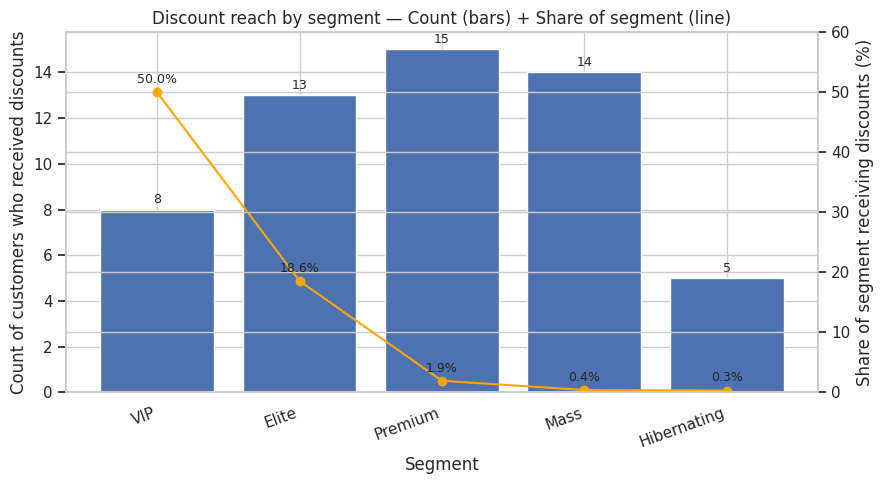

In [160]:
# Make discounted transactions metrics chart

# Make safe copies
dm = discount_metrics.copy()
cs = customer_segments_light.copy()

# Aggregations (distinct customer counts)
total_by_segment = cs.groupby("final_segment")["CustomerID"].nunique().rename("total_customers")
discounted_by_segment = dm.groupby("Segment")["CustomerID"].nunique().rename("discounted_customers")

summary = pd.concat([total_by_segment, discounted_by_segment], axis=1).fillna(0)
summary = summary.reset_index().rename(columns={"index":"segment"})
summary["discounted_customers"] = summary["discounted_customers"].astype(int)
summary["pct_discounted"] = summary["discounted_customers"] / summary["total_customers"] * 100

# Order segments (adjust preferred_order as you like)
preferred_order = ["VIP", "Elite", "Premium", "Mass", "Hibernating"]
existing = [s for s in preferred_order if s in summary["segment"].values]
others = [s for s in summary["segment"].unique() if s not in existing]
order = existing + others
summary["segment"] = pd.Categorical(summary["segment"], categories=order, ordered=True)
summary = summary.sort_values("segment").reset_index(drop=True)

# Display summary (if caas_jupyter_tools available)
try:
    display_dataframe_to_user("Discount reach by segment (summary)", summary[["segment","total_customers","discounted_customers","pct_discounted"]])
except Exception:
    print(summary[["segment","total_customers","discounted_customers","pct_discounted"]])

# Plot
fig, ax1 = plt.subplots(figsize=(9,5))
x = np.arange(len(summary))
counts = summary["discounted_customers"].values
pct = summary["pct_discounted"].values

# Bars: count of discounted customers
bars = ax1.bar(x, counts)
ax1.set_xlabel("Segment")
ax1.set_ylabel("Count of customers who received discounts")
ax1.set_xticks(x)
ax1.set_xticklabels(summary["segment"].astype(str), rotation=20, ha='right')

# Annotate counts above bars
for xi, c in zip(x, counts):
    ax1.text(xi, c + max(counts)*0.01, f"{c}", ha='center', va='bottom', fontsize=9)

# Secondary axis: percent of segment that received discounts
ax2 = ax1.twinx()
ax2.plot(x, pct, marker='o', linestyle='-', linewidth=1.5, color='orange')
ax2.set_ylabel("Share of segment receiving discounts (%)")
ax2.set_ylim(0, max(5, pct.max()*1.2))  # give headroom

# Annotate percentages
for xi, p in zip(x, pct):
    ax2.text(xi, p + max(pct)*0.02, f"{p:.1f}%", ha='center', va='bottom', fontsize=9)

plt.title("Discount reach by segment — Count (bars) + Share of segment (line)")
plt.tight_layout()
plt.show()

**Findings**:

1. The current discount strategy lacks proper segmentation. While VIP and Elite customer segments show a higher *percentage* of discount recipients, their absolute *count* is still lower than the combined total of all other segments. This indicates discounts are not being concentrated on the high-value customer base.
2. The most significant issue is the failure to ensure 100% discount coverage for all VIP and Elite customers. Failing to provide a discount to *every* transaction from these top-tier segments represents a major lapse in loyalty reinforcement and value recognition for the store's most profitable clients.

# 3. Product Analysis

In [128]:
# Find product's revenue distribution
def product_revenue_share(data):
  total_revenue = data['TotalPrice'].sum()
  product_metric = product_metrics(data)

  # Determine the thresholds
  threshold1 = product_metric['TotalRevenue'].quantile(0.95)
  threshold2 = product_metric['TotalRevenue'].quantile(0.80)
  threshold3 = product_metric['TotalRevenue'].quantile(0.50)

  # Apply the threshold
  top5products = product_metric[product_metric['TotalRevenue'] >= threshold1]['TotalRevenue'].sum()
  top20products = product_metric[product_metric['TotalRevenue'] >= threshold2]['TotalRevenue'].sum()
  bottom50products = product_metric[product_metric['TotalRevenue'] < threshold3]['TotalRevenue'].sum()

  # Count the revenue share
  top5_revenue_share = (top5products / total_revenue) * 100
  top20_revenue_share = (top20products / total_revenue) * 100
  bottom50_revenue_share = (bottom50products / total_revenue) * 100

  prod_revenue_share = pd.DataFrame({
    'Category': ['Top 5%', 'Top 20%', 'Bottom50%'],
    'TotalRevenue': [top5products, top20products, bottom50products],
    'RevenueShare': [top5_revenue_share, top20_revenue_share, bottom50_revenue_share]
  })

  return prod_revenue_share

In [156]:
product_revenue_share(df)

,Category,TotalRevenue,RevenueShare
0,Top 5%,8378534.62,45.50
1,Top 20%,14360063.07,77.97
2,Bottom50%,843394.58,4.58


In [130]:
# Make metrics for each products

# Separate 2 periods
def product_metrics(data):
  first_year_data = data[data['InvoiceDate'] < '2010-12-01 00:00:00']
  second_year_data = data[data['InvoiceDate'] >= '2010-12-01 00:00:00']
  # Determine the metrics
  def products_metric(data):
    metrics = data.groupby('StockCode').agg({
        'InvoiceNo': 'nunique',
        'TotalPrice': 'sum',
        'Quantity': 'sum',
        'CustomerID': 'nunique',
        'InvoiceDate': 'last'
    }).reset_index()
    metrics.columns = ['StockCode', 'NumInvoices', 'TotalRevenue', 'TotalQuantity', 'NumCustomers', 'LastPurchased']
    metrics = metrics[metrics['StockCode'] != 'D']

    return metrics
  # Apply the metrics on each period of data
  metric = products_metric(data)
  first_year_metrics = products_metric(first_year_data)
  second_year_metrics = products_metric(second_year_data)

  # Get the 'important' metrics from each period
  metric = metric.merge(first_year_metrics[['StockCode', 'TotalRevenue']].rename(columns={'TotalRevenue':'TotalRevenue_y1'}), on='StockCode', how='left')
  metric = metric.merge(second_year_metrics[['StockCode', 'TotalRevenue']].rename(columns={'TotalRevenue':'TotalRevenue_y2'}), on='StockCode', how='left')

  # Determine threshold for 'Product Category'
  TopProd_Thresh_y1 = metric['TotalRevenue_y1'].quantile(0.97)
  MidProd_Thresh_y1 = metric['TotalRevenue_y1'].quantile(0.87)

  TopProd_Thresh_y2 = metric['TotalRevenue_y2'].quantile(0.97)
  MidProd_Thresh_y2 = metric['TotalRevenue_y2'].quantile(0.87)

  # Apply the category
  def apply_products_category(row):
    if (row['TotalRevenue_y1'] >= TopProd_Thresh_y1) | (row['TotalRevenue_y2'] >= TopProd_Thresh_y2):
      return 'Top'
    elif (row['TotalRevenue_y1'] >= MidProd_Thresh_y1) | (row['TotalRevenue_y2'] >= MidProd_Thresh_y2):
      return 'Mid'
    else:
      return 'Bottom'

  metric['Category'] = metric.apply(apply_products_category, axis=1)
  return metric

In [131]:
prod_metrics = product_metrics(df)

In [132]:
q100 = prod_metrics['TotalRevenue'].max()
q95 = prod_metrics['TotalRevenue'].quantile(0.95)
q80 = prod_metrics['TotalRevenue'].quantile(0.80)
q50 = prod_metrics['TotalRevenue'].quantile(0.50)
prod_metrics['ParetoCategory'] = pd.cut(prod_metrics['TotalRevenue'], bins=[0,q50,q80,q95,q100], labels=['Bottom 50%','Top 20-50%','Top 5-20%','Top 0-5%'])

In [133]:
def prod_pareto_chart(df, category_col, value_col):
    q100 = prod_metrics['TotalRevenue'].max()
    q95 = prod_metrics['TotalRevenue'].quantile(0.95)
    q80 = prod_metrics['TotalRevenue'].quantile(0.80)
    q50 = prod_metrics['TotalRevenue'].quantile(0.50)
    df['ParetoCategory'] = pd.cut(prod_metrics['TotalRevenue'], bins=[0,q50,q80,q95,q100], labels=['Bottom 50%','Top 20-50%','Top 5-20%','Top 0-5%'])

    data = df.groupby(category_col)[value_col].sum().sort_values(ascending=False)
    cumulative = data.cumsum() / data.sum()

    fig, ax1 = plt.subplots()

    # Bar chart (warna biru)
    ax1.bar(data.index, data.values, color='steelblue')
    ax1.set_ylabel('Value')
    ax1.set_xticklabels(data.index, rotation=45, ha='right')

    # Line chart cumulative % (warna oranye)
    ax2 = ax1.twinx()
    ax2.plot(data.index, cumulative.values, marker='o', color='darkorange')
    ax2.set_ylabel('Cumulative %')
    ax2.set_ylim(0, 1)

    plt.title('Product Pareto Chart')
    plt.tight_layout()
    plt.show()

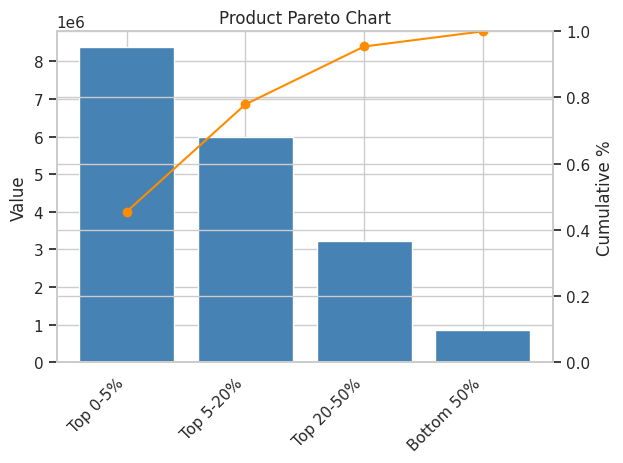

In [134]:
prod_pareto_chart(prod_metrics, 'ParetoCategory', 'TotalRevenue')

In [135]:
def seasonal_product(data):
    # Sum revenue per product per season
    seasonal = data.groupby(['StockCode', 'Season'])['TotalPrice'].sum().reset_index()

    # Pivot to wide format
    seasonal_pivot = seasonal.pivot(index='StockCode', columns='Season', values='TotalPrice').fillna(0)

    # Pastikan urutan nama kolom sesuai
    seasonal_pivot = seasonal_pivot.rename(columns={
        'Winter': 'Winter',
        'Spring': 'Spring',
        'Summer': 'Summer',
        'Fall': 'Fall'
    })

    # Tambahkan TotalRevenue
    seasonal_pivot['TotalRevenue'] = seasonal_pivot[['Winter', 'Spring', 'Summer', 'Fall']].sum(axis=1)

    # Hitung Top1 dan Top2 Share
    sorted_revs = (
        seasonal_pivot[['Winter', 'Spring', 'Summer', 'Fall']]
        .apply(lambda row: sorted(row, reverse=True), axis=1, result_type='expand')
    )
    seasonal_pivot['Top1Pct'] = sorted_revs.iloc[:, 0] / seasonal_pivot['TotalRevenue']
    seasonal_pivot['Top2Pct'] = (sorted_revs.iloc[:, 0] + sorted_revs.iloc[:, 1]) / seasonal_pivot['TotalRevenue']

    # Seasonal Dominance Flag
    seasonal_pivot['SeasonalFlag'] = (
        (seasonal_pivot['Top1Pct'] > 0.50) |
        (seasonal_pivot['Top2Pct'] > 0.85)
    )

    # Best Season
    seasonal_pivot['BestSeason'] = seasonal_pivot[['Winter', 'Spring', 'Summer', 'Fall']].idxmax(axis=1)

    return seasonal_pivot.reset_index()

In [136]:
product_per_season = seasonal_product(df)
prod_metrics = prod_metrics.merge(product_per_season[['StockCode', 'SeasonalFlag']], on='StockCode', how='left')

**Findings**:

**Product Category Spending Behavior by Customer Segment:**

The following insights are derived from a focused analysis within the Power BI dashboard, specifically from the 'Product Category Dashboard' view. They reveal distinct purchasing patterns aligned with customer value segments.

1.  **Hibernating** customers, characterized by low recent activity, concentrate the majority of their spending on **Bottom-tier** products. This aligns with their low overall engagement and value to the business.
2.  Customers with an "Unknown" frequency status (fewer than 5 purchases) predominantly spend on **Mid** and **Bottom-tier** products. This pattern is typical for new or infrequent shoppers who have yet to convert to higher-value offerings.
3.  **Premium, Elite, and VIP** customers demonstrate a clear preference for **Top-tier** products, allocating most of their budget to this category. This validates the customer segmentation model and explicitly identifies these segments as the primary drivers of revenue for high-margin items.

# 4. Cancellation Analysis

In [68]:
canceled_product = cancellation_df.groupby('StockCode')['InvoiceNo'].count().sort_values(ascending=False)

# canceled product using z-score
from scipy import stats
z_scores = stats.zscore(canceled_product)
canceled_outliers = canceled_product[np.abs(z_scores) > 3]
canceled_outliers

,InvoiceNo
StockCode,
M,535
22423,342
POST,228
22138,209
21232,189
D,168
21843,155
85123A,134
79323W,126


**Finding:**
A number of products show noticeably higher cancellation frequencies than the rest. This requires additional investigation.

In [69]:
product = df.groupby('StockCode')['InvoiceNo'].count().sort_values(ascending=False)
top_products = product[product > 500]
top_products.shape[0]

530

In [70]:
# 'StockCode' in canceled_outliers but not in top_products
stock_codes_to_investigate = canceled_outliers[~canceled_outliers.index.isin(top_products.index)]
display(stock_codes_to_investigate)

,InvoiceNo
StockCode,
M,535
POST,228
D,168
79323W,126
S,99
79323P,86
BANK CHARGES,66
85042,61
79323LP,60


**Finding:**
Most products with the highest cancellation counts are also the most frequently purchased items, so additional investigation is unnecessary for this case.

In [137]:
cancellation_df.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearMonth,TotalPrice
count,19165,19165,19165,19165.00,19165,19165.00,19165,19165,19165,19165.00
unique,8292,2898,3078,NaN,NaN,NaN,2573,36,25,NaN
top,C570867,M,MANUAL,NaN,NaN,NaN,0,United Kingdom,2011-10,NaN
freq,101,535,535,NaN,NaN,NaN,719,16349,1200,NaN
mean,NaN,NaN,NaN,-24.99,2010-12-11 16:37:14.250978560,42.73,NaN,NaN,NaN,-76.46
min,NaN,NaN,NaN,-80995.00,2009-12-01 10:33:00,0.01,NaN,NaN,NaN,-168469.60
25%,NaN,NaN,NaN,-6.00,2010-06-03 19:42:00,1.45,NaN,NaN,NaN,-17.85
50%,NaN,NaN,NaN,-2.00,2010-11-24 12:30:00,2.95,NaN,NaN,NaN,-8.95
75%,NaN,NaN,NaN,-1.00,2011-07-01 12:11:00,6.65,NaN,NaN,NaN,-3.75
max,NaN,NaN,NaN,1.00,2011-12-09 11:58:00,38970.00,NaN,NaN,NaN,373.57


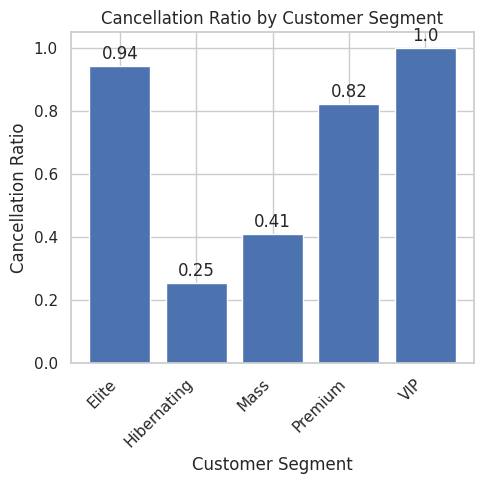

In [138]:
# Find cancellation transactions distribution based on Customers Segment
segments_distribution = cust_pivot['final_segment'].value_counts()
canceled_segments_distribution = cust_pivot[cust_pivot['CustomerID'].isin(cancellation_df['CustomerID'])]['final_segment'].value_counts()
canceled_segments_ratio = canceled_segments_distribution / segments_distribution

plt.figure(figsize=(5, 5))
bars = plt.bar(canceled_segments_ratio.index, canceled_segments_ratio.values)
plt.xlabel('Customer Segment')
plt.ylabel('Cancellation Ratio')
plt.title('Cancellation Ratio by Customer Segment')
plt.xticks(rotation=45, ha='right')

# Add numerical labels to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

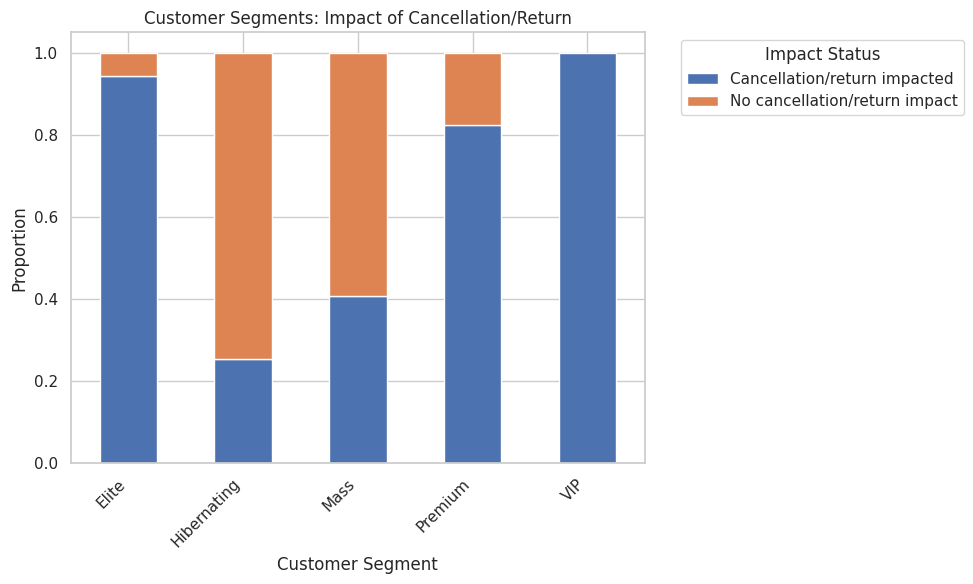

In [139]:
# Make the stacked chart

canceled_ratio = canceled_segments_ratio.copy()
no_impact_ratio = 1 - canceled_ratio

plot_df = pd.DataFrame({
    'Cancellation/return impacted': canceled_ratio,
    'No cancellation/return impact': no_impact_ratio
})

plot_df.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Customer Segments: Impact of Cancellation/Return')
plt.xlabel('Customer Segment')
plt.ylabel('Proportion')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Impact Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [140]:
# Define the 'cancellation group'
cancellation_df = df[df['InvoiceNo'].str.startswith('C')]
lost_declining_cancellation = cancellation_df[(cancellation_df['CustomerID'].isin(lost_customers['CustomerID'])) |
                                              (cancellation_df['CustomerID'].isin(declining_customers['CustomerID']))]
stable_inclining_cancellation = cancellation_df[(cancellation_df['CustomerID'].isin(stable_customers['CustomerID'])) |
                                                (cancellation_df['CustomerID'].isin(inclining_customers['CustomerID']))]
other_cancellation = cancellation_df[(~cancellation_df['CustomerID'].isin(stable_inclining_cancellation['CustomerID'])) &
                                     (~cancellation_df['CustomerID'].isin(lost_declining_cancellation['CustomerID']))]

# Find the total revenue of each group
lost_declining_cancellation_price = lost_declining_cancellation['TotalPrice'].sum()
stable_inclining_cancellation_price = stable_inclining_cancellation['TotalPrice'].sum()
other_cancellation_price = other_cancellation['TotalPrice'].sum()

# Find the total customers of each group
lost_declining_cancellation_cust = lost_declining_cancellation['CustomerID'].nunique()
stable_inclining_cancellation_cust = stable_inclining_cancellation['CustomerID'].nunique()
other_cancellation_cust = other_cancellation['CustomerID'].nunique()

# Find the total unique products of each group
lost_declining_cancellation_products = lost_declining_cancellation['StockCode'].nunique()
stable_inclining_cancellation_products = stable_inclining_cancellation['StockCode'].nunique()
other_cancellation_products = other_cancellation['StockCode'].nunique()

# Find the revenue share of each group
lost_declining_revenue_share = lost_declining_cancellation_price / cancellation_df['TotalPrice'].sum() * 100
stable_inclining_revenue_share = stable_inclining_cancellation_price / cancellation_df['TotalPrice'].sum() * 100
other_revenue_share = other_cancellation_price / cancellation_df['TotalPrice'].sum() * 100

# Make the table
cancellation_table = pd.DataFrame({
                     'Segment': ['Declining/Lost', 'Stable/Inclining', 'Other'],
                     'TotalRevenue': [lost_declining_cancellation_price, stable_inclining_cancellation_price, other_cancellation_price],
                     'RevenueShare': [lost_declining_revenue_share, stable_inclining_revenue_share, other_revenue_share],
                     'TotalCustomers': [lost_declining_cancellation_cust, stable_inclining_cancellation_cust, other_cancellation_cust],
                     'TotalProducts': [lost_declining_cancellation_products, stable_inclining_cancellation_products, other_cancellation_products]
                     })
cancellation_table

,Segment,TotalRevenue,RevenueShare,TotalCustomers,TotalProducts
0,Declining/Lost,-105378.63,26.19,561,1299
1,Stable/Inclining,-286428.97,71.18,1723,2395
2,Other,-10576.71,2.63,76,444


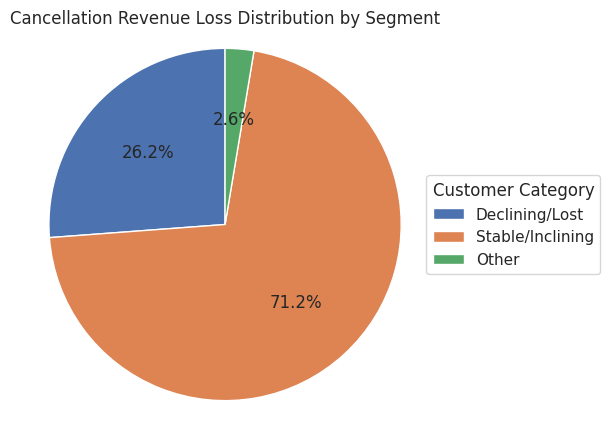

In [141]:
# Make the pie chart
plt.figure(figsize=(5,5))
plt.pie(cancellation_table['TotalRevenue'].abs(), autopct='%1.1f%%', startangle=90)
plt.title('Cancellation Revenue Loss Distribution by Segment')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(cancellation_table['Segment'], title='Customer Category', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

**Findings**:

1.  A disproportionately high percentage of VIP and Elite customers have experienced order cancellations or returns. In contrast, less than half of the customers in the Mass and Hibernating segments have such incidents in their history.
2.  The majority (>71%) of all cancellation/return transactions originate from customers with 'Stable' or 'Inclining' statuses. Customers classified as 'Declining' or 'Lost' contribute less than 27% of these negative events.

# **FINAL TABLE**

In [150]:
def customer_category(data):
  if data['CustomerID'] != '0':
    return 'Identified'
  else:
    return 'Non Identified'

df['CustomerCategory'] = df.apply(customer_category, axis=1)

In [151]:
df[df['CustomerID'] == '0']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearMonth,TotalPrice,period,OrderCount,Month,Season,CustomerCategory
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,0,United Kingdom,2009-12,0.55,year1,1,12,Winter,Non Identified
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,0,United Kingdom,2009-12,0.85,year1,1,12,Winter,Non Identified
1055,489548,22271,FELTCRAFT DOLL ROSIE,1,2009-12-01 12:32:00,2.95,0,United Kingdom,2009-12,2.95,year1,1,12,Winter,Non Identified
1056,489548,22254,FELT TOADSTOOL LARGE,12,2009-12-01 12:32:00,1.25,0,United Kingdom,2009-12,15.00,year1,1,12,Winter,Non Identified
1057,489548,22273,FELTCRAFT DOLL MOLLY,3,2009-12-01 12:32:00,2.95,0,United Kingdom,2009-12,8.85,year1,1,12,Winter,Non Identified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018801,579787,21888,BINGO SET,2,2011-11-30 15:33:00,7.46,0,United Kingdom,2011-11,14.92,year2,1,11,Fall,Non Identified
1018802,579787,21912,VINTAGE SNAKES & LADDERS,1,2011-11-30 15:33:00,7.46,0,United Kingdom,2011-11,7.46,year2,1,11,Fall,Non Identified
1018803,579787,21916,SET 12 RETRO WHITE CHALK STICKS,1,2011-11-30 15:33:00,0.79,0,United Kingdom,2011-11,0.79,year2,1,11,Fall,Non Identified
1018804,579787,21929,JUMBO BAG PINK VINTAGE PAISLEY,1,2011-11-30 15:33:00,4.13,0,United Kingdom,2011-11,4.13,year2,1,11,Fall,Non Identified


In [152]:
# FINAL TABLE for Dashboard

# 1. FACT TRANSACTION
fact_transactions = df.copy()
fact_transactions['InvoiceDate'] = pd.to_datetime(fact_transactions['InvoiceDate']).dt.normalize()
date_dim = fact_transactions.groupby('InvoiceDate').agg({
    'YearMonth': 'first',
    'Month': 'first',
    'period': 'first',
    'Season': 'first'
    }).reset_index()
fact_transactions.drop(columns=['YearMonth', 'Month', 'period', 'Season'], inplace=True)

# 2. CUSTOMER DIMENSION
## 2.1. CUSTOMER METRICS TABLE
customer_dim = cust_pivot

# 3. PRODUCT METRICS DIMENSION
product_dim = prod_metrics

# 4. DATE DIMENSION
date_dim = date_dim.rename(columns={'period':'FiscalYear'})
date_dim.loc[date_dim['FiscalYear'] == 'year1', 'FiscalYear'] = 1
date_dim.loc[date_dim['FiscalYear'] == 'year2', 'FiscalYear'] = 2
date_dim['SeasonOrder'] = date_dim['Season'].map({'Winter': 1, 'Spring': 2, 'Summer': 3, 'Fall': 4})
date_dim['YearMonthDate'] = date_dim['YearMonth'].dt.to_timestamp()

In [162]:
fact_transactions.to_excel('fact_transactions.xlsx', index=False)
customer_dim.to_excel('customer_dim.xlsx', index=False)
product_dim.to_excel('product_dim.xlsx', index=False)
date_dim.to_excel('date_dim.xlsx', index=False)